In [1]:
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

import math
import random
from copy import deepcopy
import json
import time
from tqdm import tqdm


# Dataset
from utils.dataset import CrowdAI
# Network
from models.backbone import DetectionBranch, R2U_Net, NonMaxSuppression
from models.matching import ScoreNet, AttentionalGNN
# Utils
from utils.utils import (graph_to_vertex_mask, polygon_to_vertex_mask, tensor_to_numpy, point_to_polygon, polygon_to_seg_mask,
                        scores_to_permutations, permutations_to_polygons)
from utils.utils import sort_sync_nsm_points, prepare_gt_vertices, angle_between_points, soft_winding_number
from utils.loss import cross_entropy_loss, iou_loss_function, compute_l_angle_loss

import matplotlib.pyplot as plt

from shapely.geometry import Polygon
from rasterio import features

from skimage import io
from skimage.transform import resize
import cv2
from PIL import Image


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
WINDOW_SIZE = 256
MAX_POINTS = 256

# Data

In [3]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [4]:
# Initiate the dataloader
batch_size = 8
dataset = CrowdAI(images_directory='data/val/images/', annotations_path='data/val/annotation.json', window_size=WINDOW_SIZE)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [ ]:
image, gt_vertex_mask, gt_seg_mask, gt_permutation_matrix, gt_polygons, gt_graph, gt_vertices, gt_dic = next(iter(dataloader))

In [ ]:
image = torch.stack(image)
gt_vertex_mask = torch.stack(gt_vertex_mask)
gt_seg_mask = torch.stack(gt_seg_mask)
gt_permutation_matrix = torch.stack(gt_permutation_matrix)
gt_graph = torch.stack(gt_graph)
# gt_vertices = torch.stack(gt_vertices)

In [ ]:
p = permutations_to_polygons(gt_permutation_matrix, gt_graph)
m = np.zeros((WINDOW_SIZE, WINDOW_SIZE), dtype=np.uint8)

cv2.fillPoly(m, [p[0][1].detach().cpu().numpy().astype(int)], 1)
plt.imshow(m)

In [ ]:
print('Image: ', image.shape)
print('Vertex: ', gt_vertex_mask.shape)
print('Segmentation: ', gt_seg_mask.shape)
print('Permutation: ', gt_permutation_matrix.shape)

In [ ]:
# plot all the masks and the images in the batch
B = len(image)
fig, axes = plt.subplots(B, 4, figsize=(21, 7*B))
for i in range(B):
    axes[i, 0].imshow(image[i])
    axes[i, 1].imshow(gt_seg_mask[i])
    axes[i, 2].imshow(gt_vertex_mask[i])
    axes[i, 3].imshow(gt_permutation_matrix[i])

    
plt.tight_layout()
plt.show()

In [ ]:
# plot all the images, vertex masks, and scatter plots in the batch
B = len(image)


fig, axes = plt.subplots(B, 3, figsize=(21, 7*B))

for i in range(B):
    # Original image
    axes[i, 0].imshow(image[i])
    axes[i, 0].set_title(f'Original Image {i+1}')
    axes[i, 0].axis('off')

    # Vertex mask as image
    axes[i, 1].imshow(gt_vertex_mask[i], cmap='viridis')
    axes[i, 1].set_title(f'Vertex Mask {i+1}')
    axes[i, 1].axis('off')

    # Scatter plot of vertex mask on original image
    axes[i, 2].imshow(image[i])
    y, x = np.nonzero(gt_vertex_mask[i].numpy())
    scatter = axes[i, 2].scatter(x, y, c=gt_vertex_mask[i].numpy()[y, x], s=20, alpha=0.5, cmap='Oranges_r')
    axes[i, 2].set_title(f'Overlay {i+1}')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

# Matching Network

In [5]:
class OptimalMatching(nn.Module):

    def __init__(self):
        super(OptimalMatching, self).__init__()
        
        # Default configuration settings
        self.descriptor_dim = 64
        self.sinkhorn_iterations = 100
        self.attention_layers = 4
        self.correction_radius = 0.05

        # Modules
        self.scorenet1 = ScoreNet(self.descriptor_dim * 2)
        self.scorenet2 = ScoreNet(self.descriptor_dim * 2)
        self.gnn = AttentionalGNN(self.descriptor_dim, self.attention_layers)
            

    def normalize_coordinates(self, graph, ws, input):
        if input == 'global':
            graph = (graph * 2 / ws - 1)
        elif input == 'normalized':
            graph = ((graph + 1) * ws / 2)
            graph = torch.round(graph).long()
            graph[graph < 0] = 0
            graph[graph >= ws] = ws - 1
        return graph




    def log_optimal_transport_batch(self, Z, iters):
        """
        Computes the optimal transport between all pairs of rows and columns of a batch of cost matrices Z in log space,
        using the Sinkhorn algorithm.

        Args:
            Z: a tensor of shape (batch_size, m, n) representing a batch of cost matrices, where m is the number of rows
            and n is the number of columns.
            iters: the number of Sinkhorn iterations to perform.

        Returns:
            A tensor of the same shape as Z, containing the optimal transport plan between all pairs of rows and columns
            in the batch.
        """
        batch_size, m, n = Z.shape
        log_mu = -torch.tensor(m).to(Z).log().expand(batch_size, m)
        log_nu = -torch.tensor(n).to(Z).log().expand(batch_size, n)
        u, v = torch.zeros_like(log_mu), torch.zeros_like(log_nu)

        for _ in range(iters):
            v = log_nu - torch.logsumexp(Z + u.unsqueeze(-1), dim=-2)
            u = log_mu - torch.logsumexp(Z + v.unsqueeze(-2), dim=-1)

        return Z + u.unsqueeze(-1) + v.unsqueeze(-2)





    def predict(self, image, descriptors, graph):
        B, _, H, W = image.shape
        B, N, _ = graph.shape
        
        for b in range(B):
            b_desc = descriptors[b]
            b_graph = graph[b]

            # Extract descriptors
            b_desc = b_desc[:, b_graph[:,0], b_graph[:,1]]

            # Concatenate descriptors in batches
            if b == 0:                    
                sel_desc = b_desc.unsqueeze(0)
            else:
                sel_desc = torch.cat((sel_desc, b_desc.unsqueeze(0)), dim=0)


        ''' AGNN '''
        # Multi-layer Transformer network. (Attentional Graph Neural Network)
        norm_graph = self.normalize_coordinates(graph, W, input="global") #out: normalized coordinate system [-1, 1]
        sel_desc, offset = self.gnn(sel_desc, norm_graph)

        # Correct points coordinates
        norm_graph = norm_graph + offset * self.correction_radius
        graph = self.normalize_coordinates(norm_graph, W, input="normalized") # out: global coordinate system [0, W]

        ''' Optimal Matching '''
        # Compute scores (Optimal connection Network)
        scores_1 = self.scorenet1(sel_desc) # Clockwise Scores
        scores_2 = self.scorenet2(sel_desc) # Counter-Clockwise Scores
        scores = scores_1 + torch.transpose(scores_2, 1, 2) # Permutation Matrix

        sinkhorn_scores = self.log_optimal_transport_batch(scores, self.sinkhorn_iterations)
        

        ''' Post-Processing '''
        permutation_mat = scores_to_permutations(sinkhorn_scores) # linear sum assignment
        poly = permutations_to_polygons(permutation_mat, graph, out='torch')
        
        graph = graph.float()
        graph.requires_grad = True


        return poly, permutation_mat, scores, sinkhorn_scores, graph

# Training

### Models

In [6]:
# Backbone
model = R2U_Net()
model = model.to(device)
model = model.train()
model.load_state_dict(torch.load('trained_weights/polyworld_backbone', map_location=device))

# Vertex Detection
head_ver = DetectionBranch()
head_ver = head_ver.to(device)
head_ver = head_ver.train()
head_ver.load_state_dict(torch.load('trained_weights/polyworld_seg_head', map_location=device))

# NMS
suppression = NonMaxSuppression()
suppression = suppression.to(device)

# Matching
matching = OptimalMatching()
matching = matching.to(device)
matching = matching.train()
# matching.load_state_dict(torch.load('trained_weights/polyworld_matching', map_location=device))

# Freeze 
for param in model.parameters():
    param.requires_grad = False

for param in head_ver.parameters():
    param.requires_grad = False

# for param in matching.parameters():
#     param.requires_grad = False

### Training Loop

In [7]:
# Optimizer
optimizer = torch.optim.Adam([
    # {'params': model.parameters()},
    # {'params': head_ver.parameters()},
    {'params': matching.parameters()}
], lr=1e-4)

In [8]:
w = 100
# detection_loss_function = nn.BCELoss(weight=torch.tensor([w])).to(device) # For Vertices # Cuda Error using this loss!
# detection_loss_function = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([w])).to(device) # For Vertices

# matching_loss_function = nn.CrossEntropyLoss().to(device)  # For Permutation Matrix
# matching_loss_function = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([w])).to(device)
# matching_loss_function = nn.NLLLoss().to(device)
# matching_loss_function = nn.BCELoss(weight=torch.tensor([w])).to(device)

In [9]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4, collate_fn=collate_fn)

  0%|          | 0/1 [00:00<?, ?it/s]

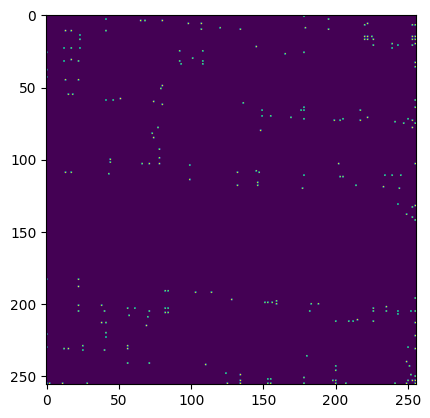

/home/amir/miniconda3/envs/poly/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 1/1 [00:02<00:00,  2.12s/it]


Segmentation Loss:  tensor(0.7314, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(11.1210, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 0 - Loss: 19.434673309326172


  0%|          | 0/1 [00:00<?, ?it/s]

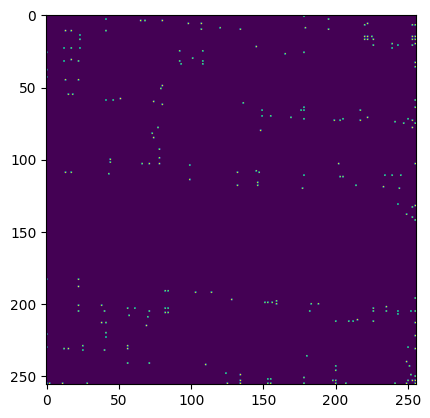

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Segmentation Loss:  tensor(0.7701, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(11.0072, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 1 - Loss: 19.70811653137207


  0%|          | 0/1 [00:00<?, ?it/s]

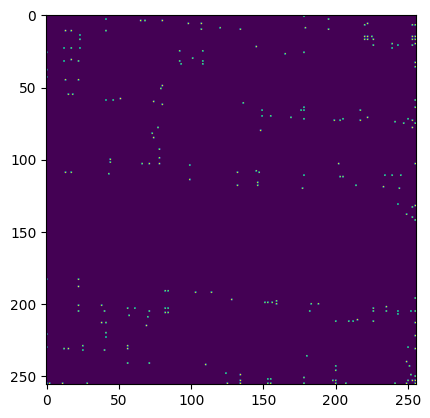

100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


Segmentation Loss:  tensor(0.7192, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(10.9135, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 2 - Loss: 19.105300903320312


  0%|          | 0/1 [00:00<?, ?it/s]

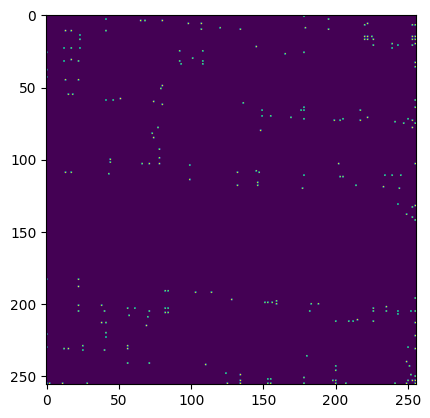

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Segmentation Loss:  tensor(0.7172, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(10.8342, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 3 - Loss: 19.006195068359375


  0%|          | 0/1 [00:00<?, ?it/s]

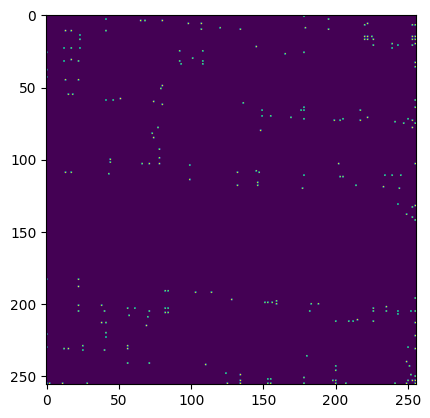

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Segmentation Loss:  tensor(0.6807, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(10.7632, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 4 - Loss: 18.569875717163086


  0%|          | 0/1 [00:00<?, ?it/s]

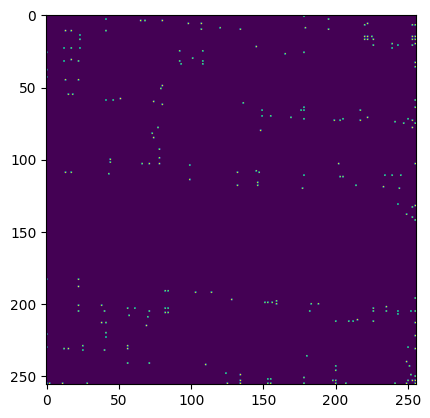

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Segmentation Loss:  tensor(0.7130, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(10.6957, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 5 - Loss: 18.82561683654785


  0%|          | 0/1 [00:00<?, ?it/s]

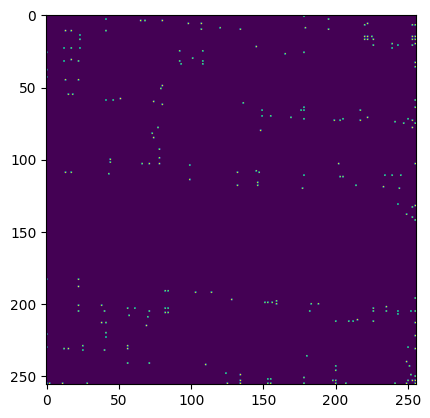

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Segmentation Loss:  tensor(0.7037, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(10.6323, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 6 - Loss: 18.669469833374023


  0%|          | 0/1 [00:00<?, ?it/s]

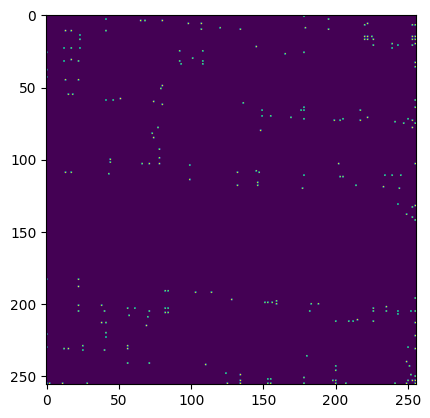

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Segmentation Loss:  tensor(0.7061, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(10.5728, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 7 - Loss: 18.634265899658203


  0%|          | 0/1 [00:00<?, ?it/s]

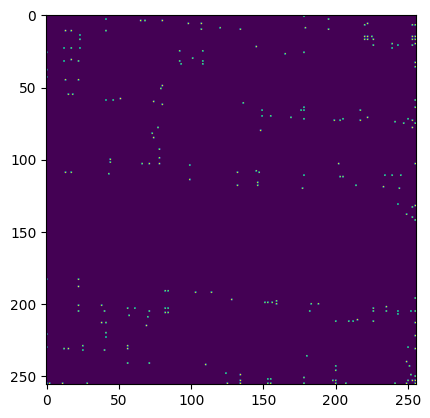

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Segmentation Loss:  tensor(0.6984, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(10.5164, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 8 - Loss: 18.50067138671875


  0%|          | 0/1 [00:00<?, ?it/s]

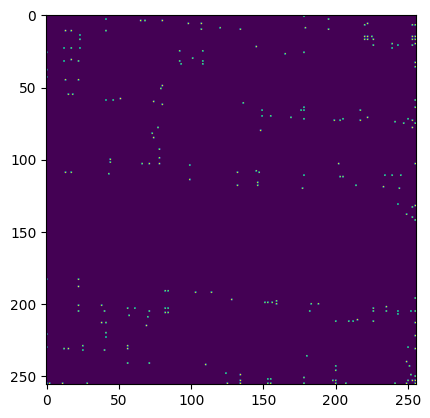

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Segmentation Loss:  tensor(0.6736, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(10.4609, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 9 - Loss: 18.197383880615234


  0%|          | 0/1 [00:00<?, ?it/s]

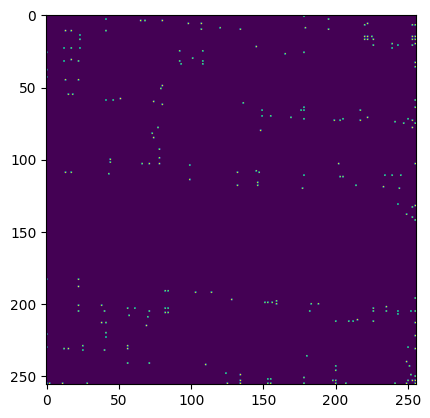

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Segmentation Loss:  tensor(0.6715, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(10.4065, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 10 - Loss: 18.121030807495117


  0%|          | 0/1 [00:00<?, ?it/s]

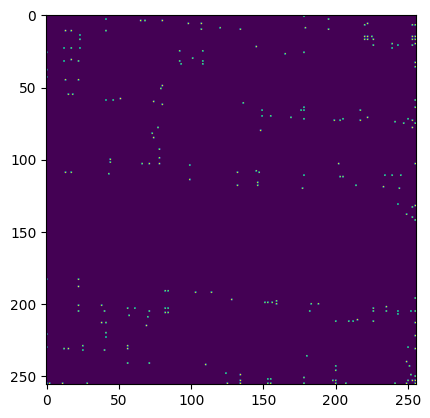

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Segmentation Loss:  tensor(0.6917, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(10.3527, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 11 - Loss: 18.269535064697266


  0%|          | 0/1 [00:00<?, ?it/s]

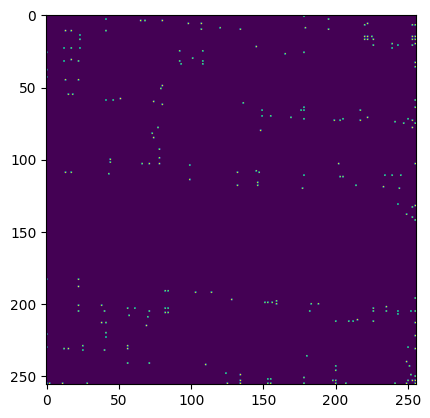

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Segmentation Loss:  tensor(0.6880, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(10.3008, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 12 - Loss: 18.180816650390625


  0%|          | 0/1 [00:00<?, ?it/s]

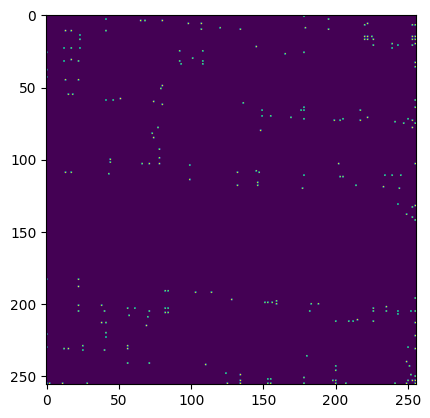

100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Segmentation Loss:  tensor(0.6791, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(10.2496, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 13 - Loss: 18.040895462036133


  0%|          | 0/1 [00:00<?, ?it/s]

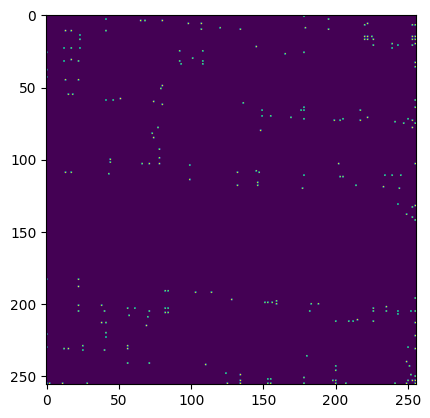

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Segmentation Loss:  tensor(0.6760, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(10.1996, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 14 - Loss: 17.959697723388672


  0%|          | 0/1 [00:00<?, ?it/s]

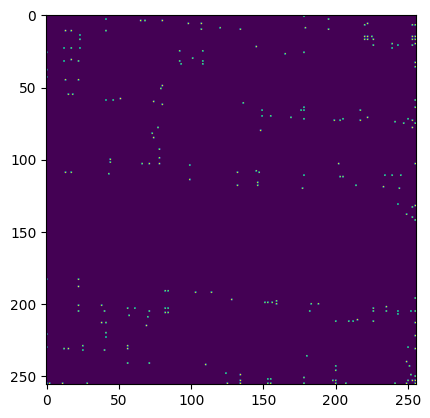

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Segmentation Loss:  tensor(0.6644, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(10.1509, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 15 - Loss: 17.79497528076172


  0%|          | 0/1 [00:00<?, ?it/s]

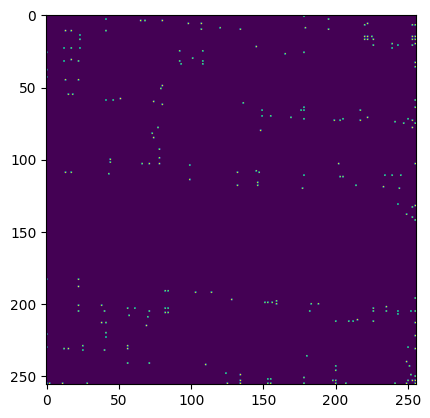

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Segmentation Loss:  tensor(0.6654, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(10.1016, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 16 - Loss: 17.755523681640625


  0%|          | 0/1 [00:00<?, ?it/s]

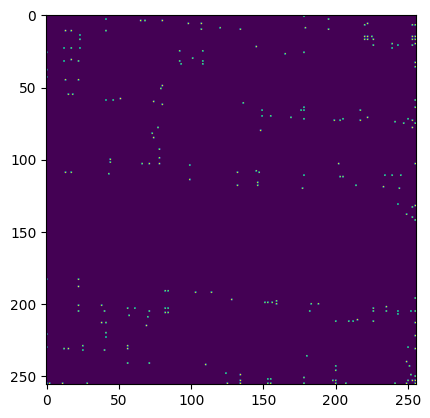

100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Segmentation Loss:  tensor(0.6755, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(10.0529, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 17 - Loss: 17.807933807373047


  0%|          | 0/1 [00:00<?, ?it/s]

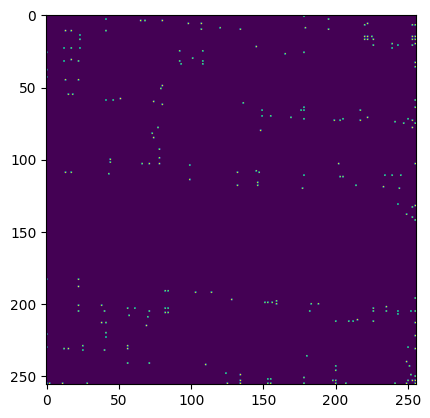

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Segmentation Loss:  tensor(0.6868, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(10.0049, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 18 - Loss: 17.872867584228516


  0%|          | 0/1 [00:00<?, ?it/s]

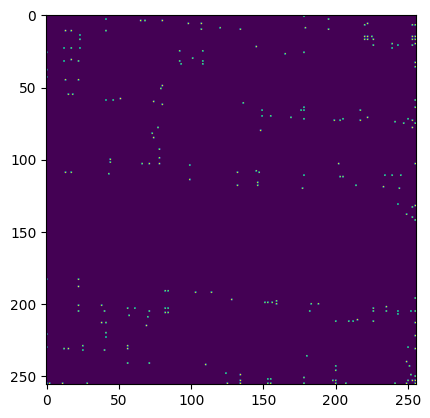

100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


Segmentation Loss:  tensor(0.7029, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(9.9570, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 19 - Loss: 17.985984802246094


  0%|          | 0/1 [00:00<?, ?it/s]

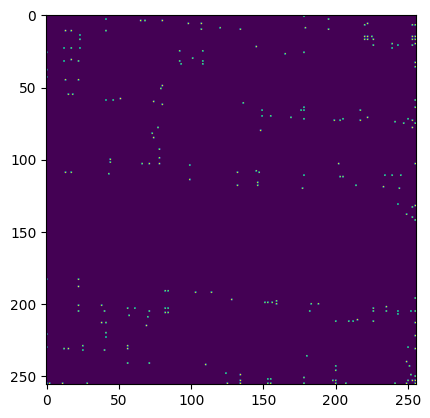

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Segmentation Loss:  tensor(0.7106, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(9.9092, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 20 - Loss: 18.01487159729004


  0%|          | 0/1 [00:00<?, ?it/s]

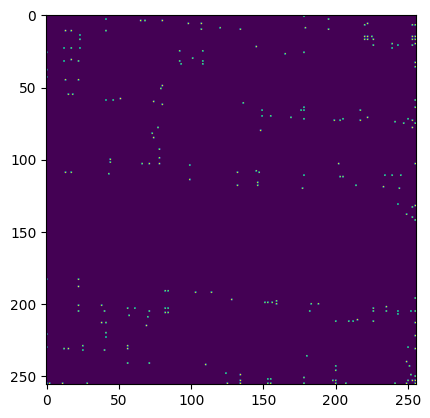

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Segmentation Loss:  tensor(0.6941, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(9.8610, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 21 - Loss: 17.80228614807129


  0%|          | 0/1 [00:00<?, ?it/s]

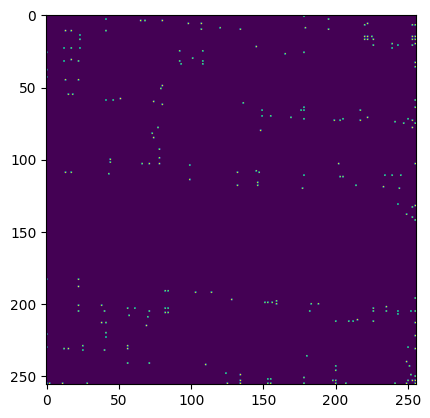

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Segmentation Loss:  tensor(0.7195, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(9.8131, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 22 - Loss: 18.007781982421875


  0%|          | 0/1 [00:00<?, ?it/s]

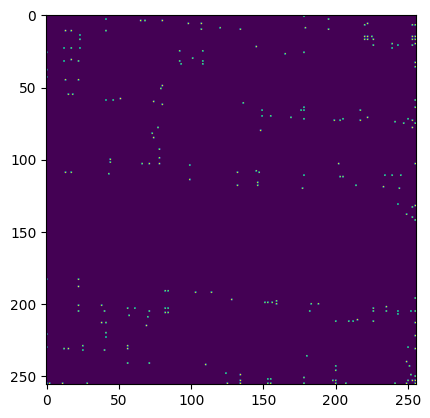

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Segmentation Loss:  tensor(0.6696, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(9.7644, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 23 - Loss: 17.460803985595703


  0%|          | 0/1 [00:00<?, ?it/s]

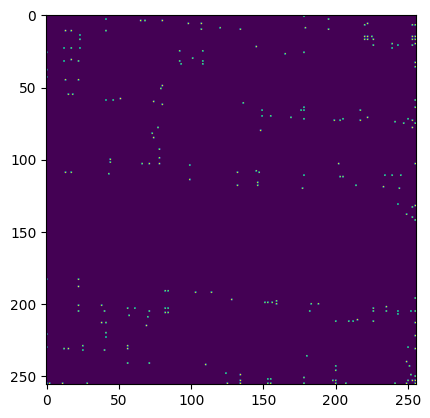

100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Segmentation Loss:  tensor(0.7108, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(9.7165, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 24 - Loss: 17.824134826660156


  0%|          | 0/1 [00:00<?, ?it/s]

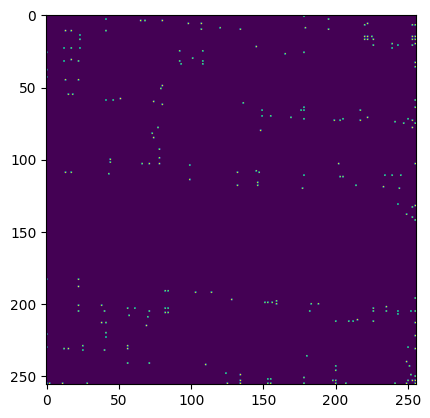

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Segmentation Loss:  tensor(0.7107, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(9.6686, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 25 - Loss: 17.775726318359375


  0%|          | 0/1 [00:00<?, ?it/s]

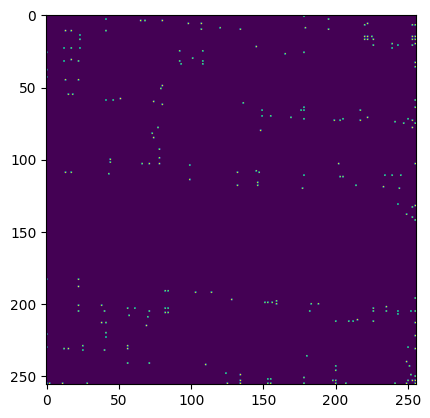

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Segmentation Loss:  tensor(0.7254, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(9.6203, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 26 - Loss: 17.874679565429688


  0%|          | 0/1 [00:00<?, ?it/s]

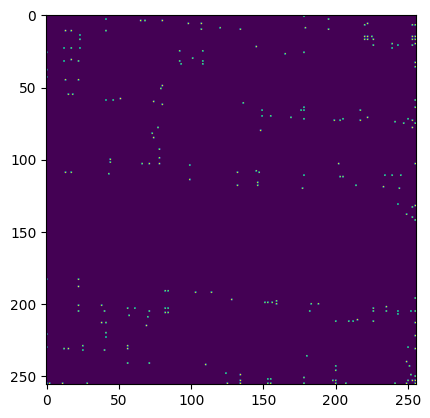

100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Segmentation Loss:  tensor(0.6919, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(9.5724, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 27 - Loss: 17.491296768188477


  0%|          | 0/1 [00:00<?, ?it/s]

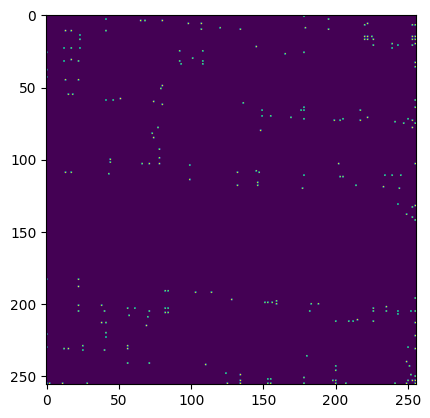

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Segmentation Loss:  tensor(0.6953, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(9.5234, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 28 - Loss: 17.476688385009766


  0%|          | 0/1 [00:00<?, ?it/s]

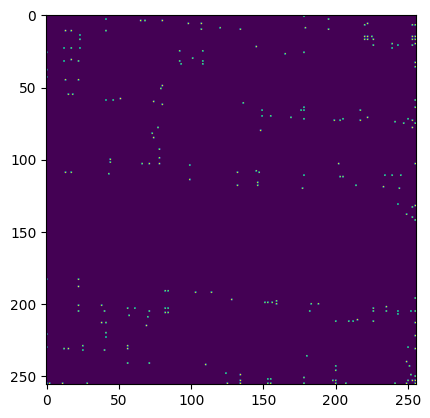

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Segmentation Loss:  tensor(0.7186, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(9.4739, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 29 - Loss: 17.66036414681855


  0%|          | 0/1 [00:00<?, ?it/s]

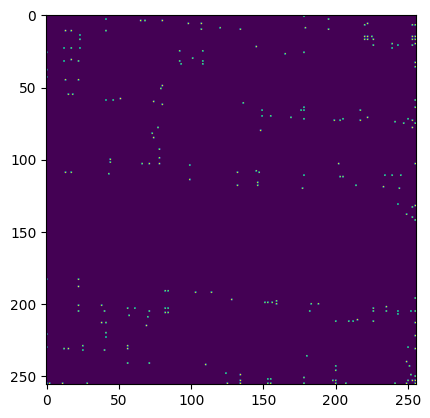

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Segmentation Loss:  tensor(0.7300, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(9.4246, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(0.9701, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 30 - Loss: 17.694290757344323


  0%|          | 0/1 [00:00<?, ?it/s]

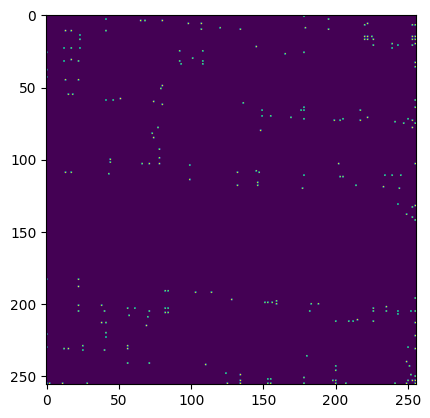

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Segmentation Loss:  tensor(0.7309, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(9.3751, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 31 - Loss: 17.683778748822377


  0%|          | 0/1 [00:00<?, ?it/s]

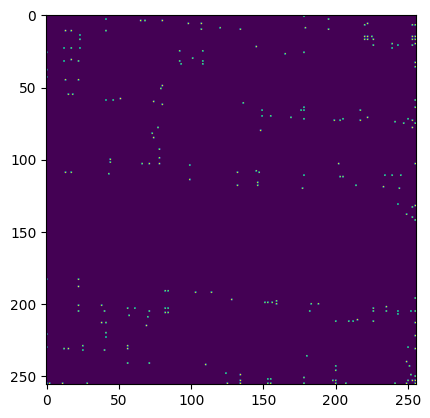

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Segmentation Loss:  tensor(0.7270, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(9.3252, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 32 - Loss: 17.595441818237305


  0%|          | 0/1 [00:00<?, ?it/s]

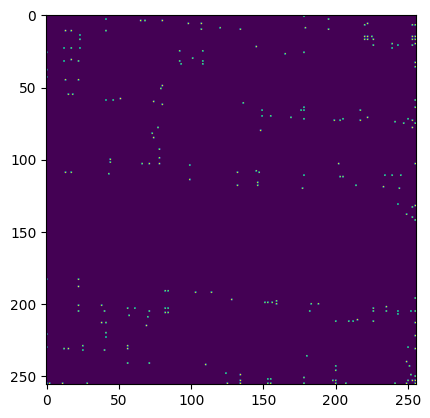

100%|██████████| 1/1 [00:00<00:00,  1.25it/s]


Segmentation Loss:  tensor(0.7270, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(9.2753, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 33 - Loss: 17.545225143432617


  0%|          | 0/1 [00:00<?, ?it/s]

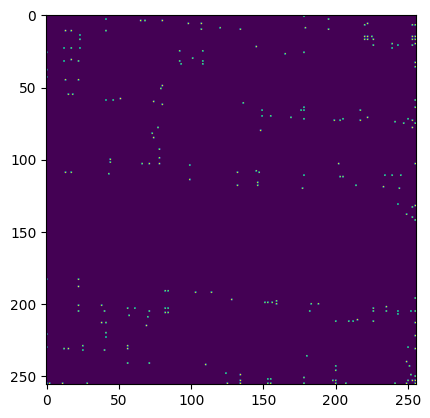

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Segmentation Loss:  tensor(0.7270, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(9.2252, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 34 - Loss: 17.494863510131836


  0%|          | 0/1 [00:00<?, ?it/s]

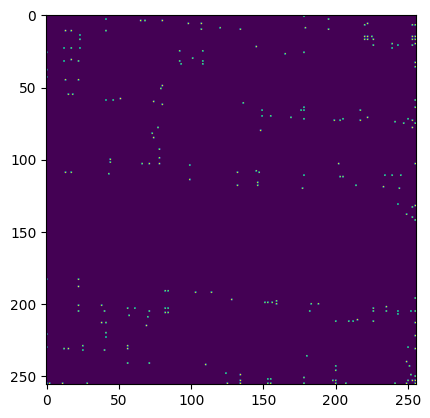

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Segmentation Loss:  tensor(0.7157, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(9.1747, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 35 - Loss: 17.332233428954687


  0%|          | 0/1 [00:00<?, ?it/s]

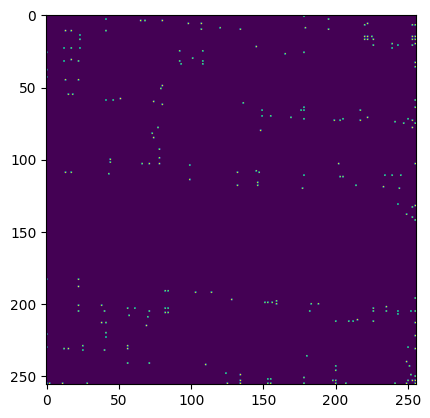

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Segmentation Loss:  tensor(0.7150, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(9.1236, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 36 - Loss: 17.273456573482953


  0%|          | 0/1 [00:00<?, ?it/s]

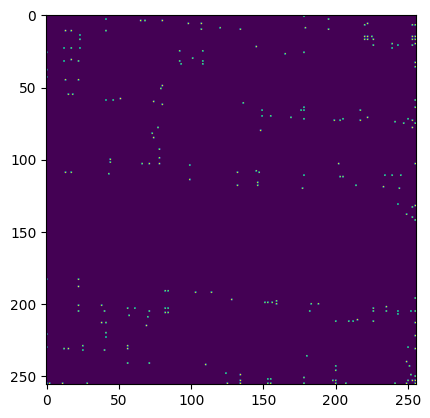

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Segmentation Loss:  tensor(0.7149, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(9.0731, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 37 - Loss: 17.222373962398862


  0%|          | 0/1 [00:00<?, ?it/s]

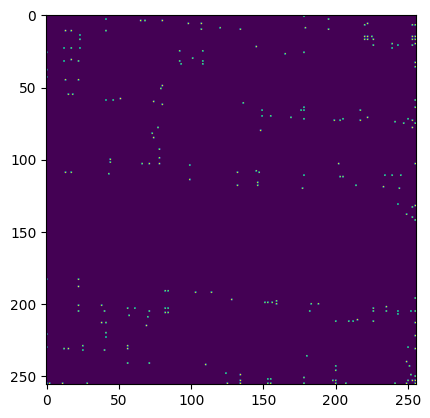

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Segmentation Loss:  tensor(0.7150, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(9.0210, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 38 - Loss: 17.170997619625354


  0%|          | 0/1 [00:00<?, ?it/s]

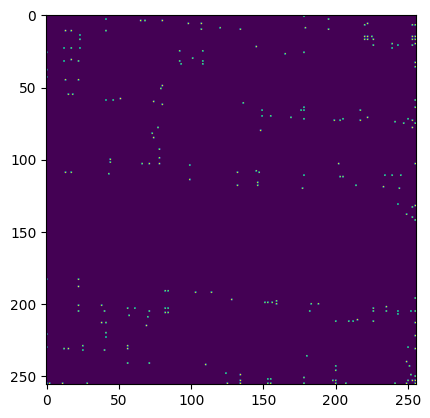

100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Segmentation Loss:  tensor(0.7124, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(8.9696, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 39 - Loss: 17.09362030029297


  0%|          | 0/1 [00:00<?, ?it/s]

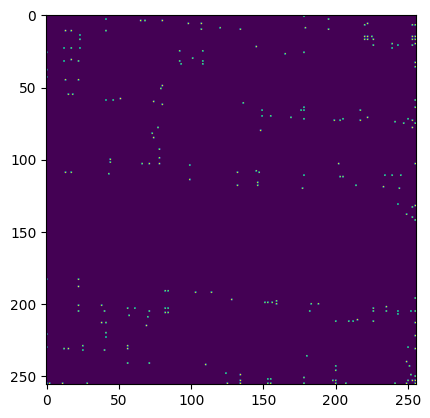

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Segmentation Loss:  tensor(0.7125, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(8.9181, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 40 - Loss: 17.042861938476562


  0%|          | 0/1 [00:00<?, ?it/s]

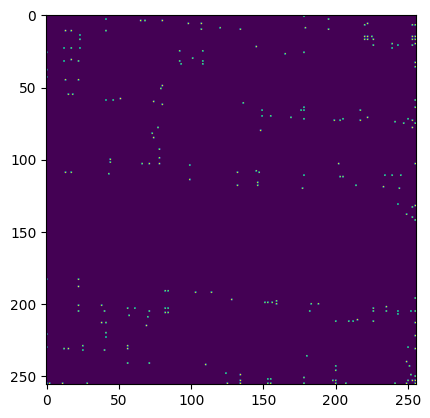

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Segmentation Loss:  tensor(0.7121, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(8.8655, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 41 - Loss: 16.98656177520752


  0%|          | 0/1 [00:00<?, ?it/s]

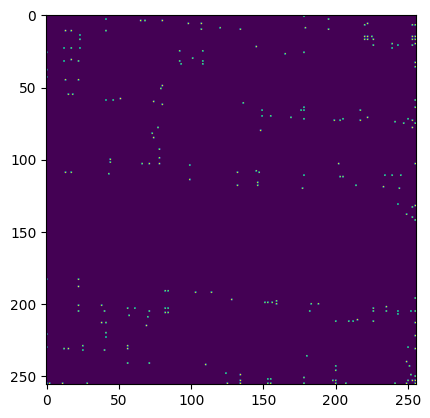

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Segmentation Loss:  tensor(0.7120, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(8.8131, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 42 - Loss: 16.93344020843506


  0%|          | 0/1 [00:00<?, ?it/s]

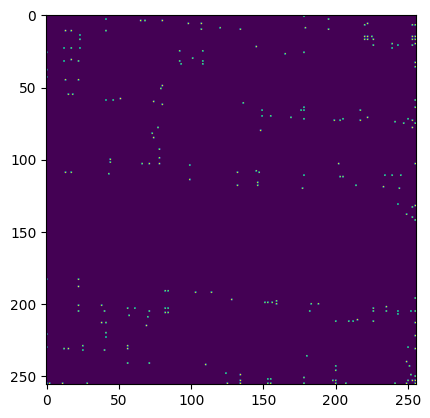

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Segmentation Loss:  tensor(0.7082, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(8.7604, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 43 - Loss: 16.842243194580075


  0%|          | 0/1 [00:00<?, ?it/s]

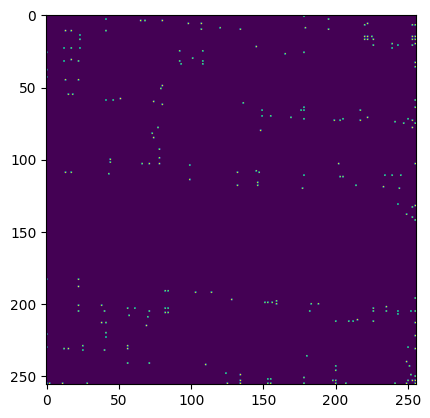

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Segmentation Loss:  tensor(0.7080, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(8.7069, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 44 - Loss: 16.78712654113769


  0%|          | 0/1 [00:00<?, ?it/s]

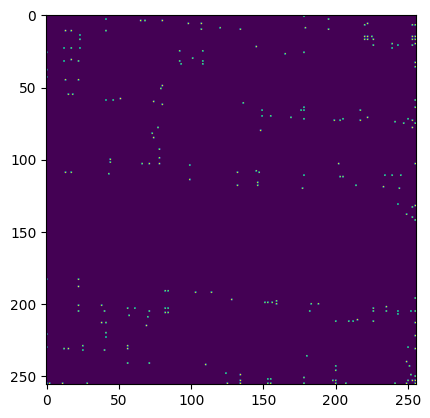

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Segmentation Loss:  tensor(0.7084, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(8.6523, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 45 - Loss: 16.736552238464352


  0%|          | 0/1 [00:00<?, ?it/s]

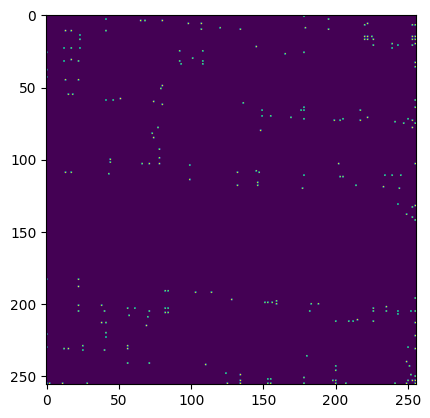

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Segmentation Loss:  tensor(0.7084, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(8.5983, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 46 - Loss: 16.682655334472653


  0%|          | 0/1 [00:00<?, ?it/s]

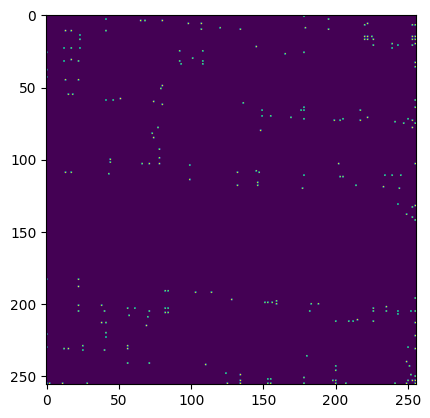

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Segmentation Loss:  tensor(0.7080, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(8.5435, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 47 - Loss: 16.623601913452145


  0%|          | 0/1 [00:00<?, ?it/s]

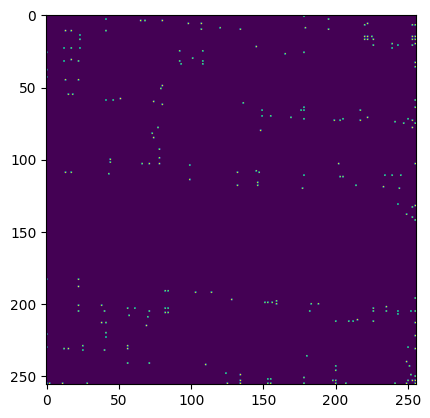

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Segmentation Loss:  tensor(0.7084, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(8.4881, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 48 - Loss: 16.572308540344235


  0%|          | 0/1 [00:00<?, ?it/s]

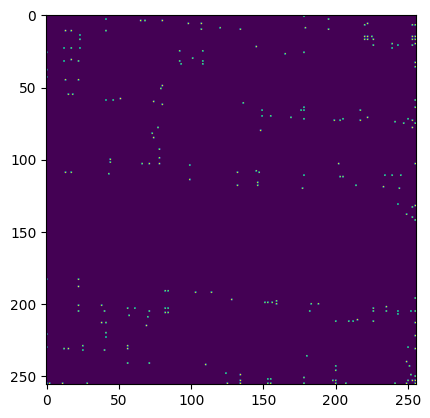

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Segmentation Loss:  tensor(0.7084, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(8.4328, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 49 - Loss: 16.517024040222164


  0%|          | 0/1 [00:00<?, ?it/s]

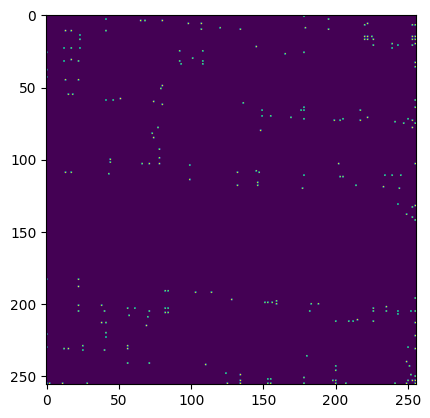

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Segmentation Loss:  tensor(0.7153, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(8.3766, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 50 - Loss: 16.52935791015625


  0%|          | 0/1 [00:00<?, ?it/s]

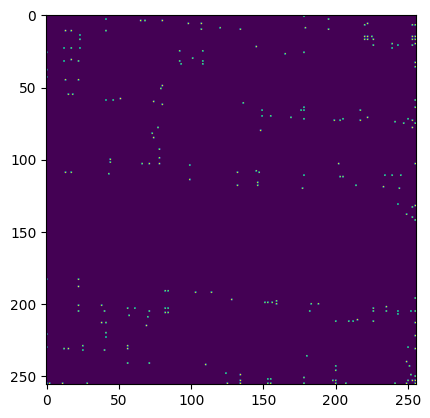

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Segmentation Loss:  tensor(0.7152, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(8.3198, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 51 - Loss: 16.471546173095703


  0%|          | 0/1 [00:00<?, ?it/s]

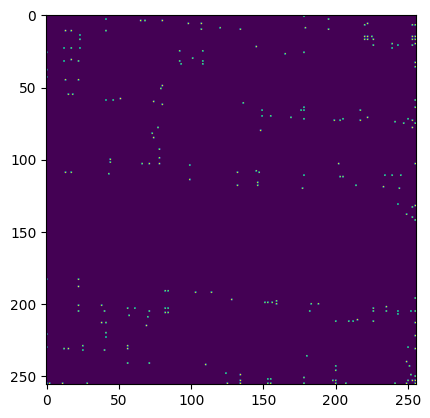

100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


Segmentation Loss:  tensor(0.7264, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(8.2633, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 52 - Loss: 16.527029037475586


  0%|          | 0/1 [00:00<?, ?it/s]

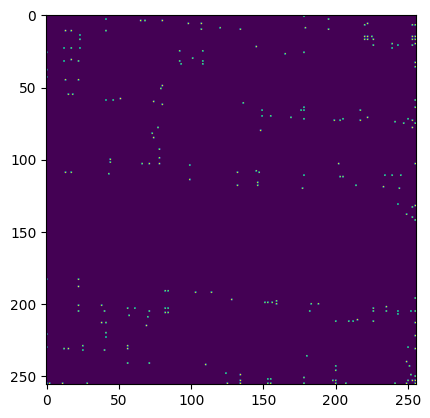

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Segmentation Loss:  tensor(0.7272, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(8.2068, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 53 - Loss: 16.479089736938477


  0%|          | 0/1 [00:00<?, ?it/s]

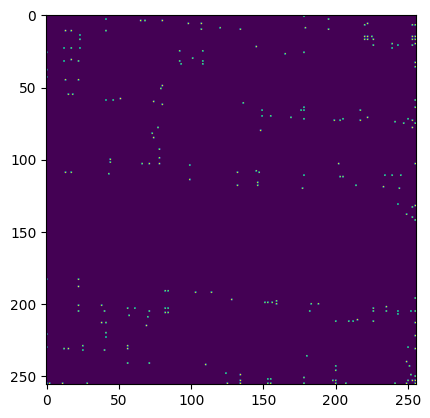

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Segmentation Loss:  tensor(0.7277, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(8.1496, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 54 - Loss: 16.426445960998535


  0%|          | 0/1 [00:00<?, ?it/s]

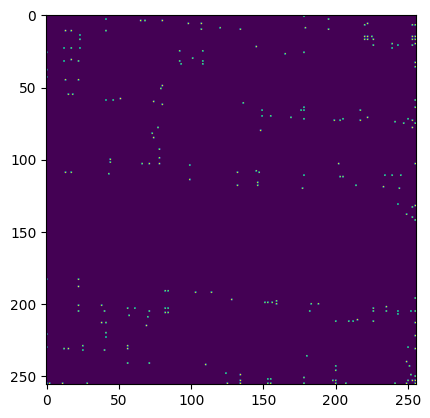

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Segmentation Loss:  tensor(0.7277, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(8.0934, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 55 - Loss: 16.370081901550293


  0%|          | 0/1 [00:00<?, ?it/s]

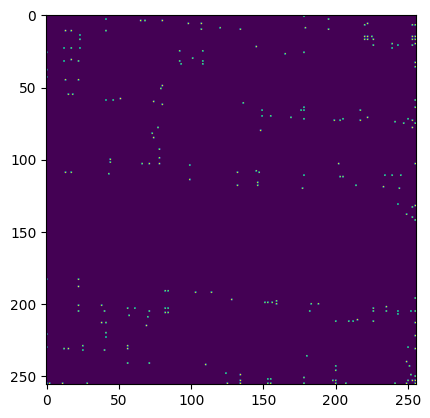

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Segmentation Loss:  tensor(0.7276, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(8.0368, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 56 - Loss: 16.313098907470703


  0%|          | 0/1 [00:00<?, ?it/s]

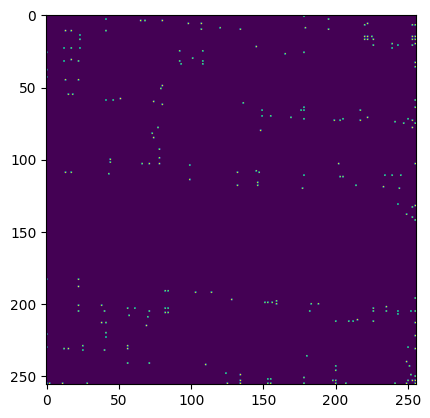

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Segmentation Loss:  tensor(0.7276, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(7.9798, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 57 - Loss: 16.255857467651367


  0%|          | 0/1 [00:00<?, ?it/s]

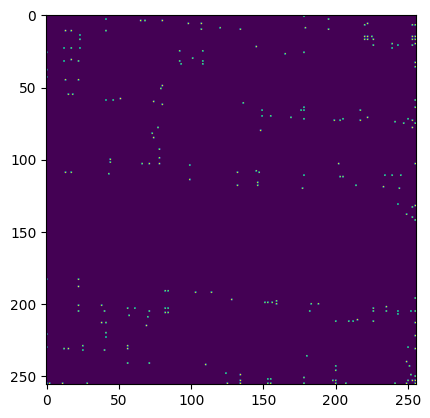

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Segmentation Loss:  tensor(0.7275, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(7.9198, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1., device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 58 - Loss: 16.194594383239746


  0%|          | 0/1 [00:00<?, ?it/s]

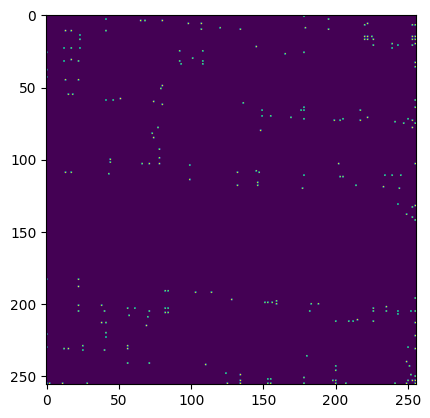

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Segmentation Loss:  tensor(0.7279, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(7.8617, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 59 - Loss: 16.140443801867658


  0%|          | 0/1 [00:00<?, ?it/s]

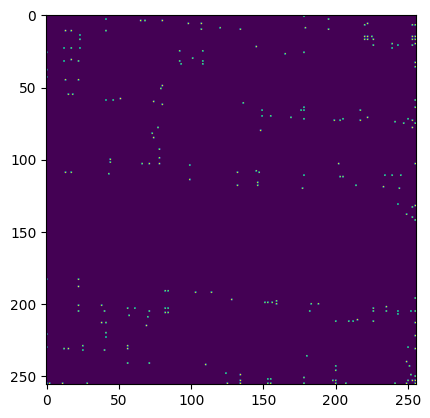

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Segmentation Loss:  tensor(0.7282, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(7.8035, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 60 - Loss: 16.08527851103262


  0%|          | 0/1 [00:00<?, ?it/s]

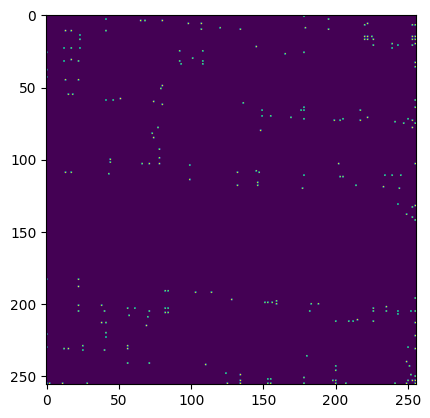

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Segmentation Loss:  tensor(0.7044, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(7.7444, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 61 - Loss: 15.788177323572837


  0%|          | 0/1 [00:00<?, ?it/s]

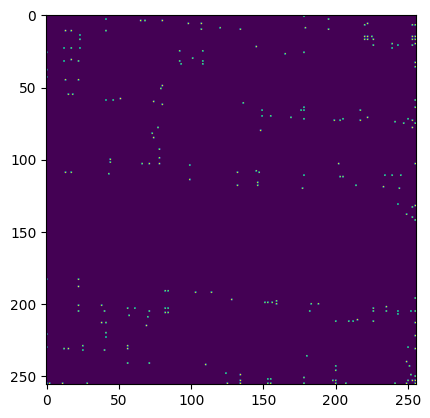

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Segmentation Loss:  tensor(0.7041, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(7.6848, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 62 - Loss: 15.726039761166163


  0%|          | 0/1 [00:00<?, ?it/s]

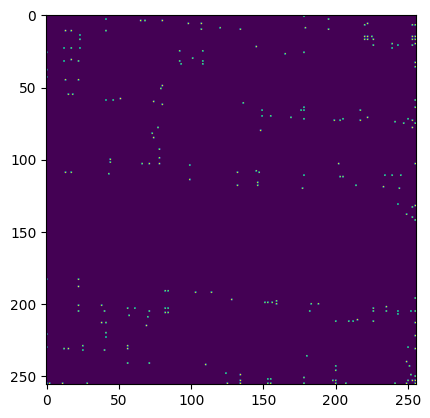

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Segmentation Loss:  tensor(0.7039, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(7.6251, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 63 - Loss: 15.663815382628556


  0%|          | 0/1 [00:00<?, ?it/s]

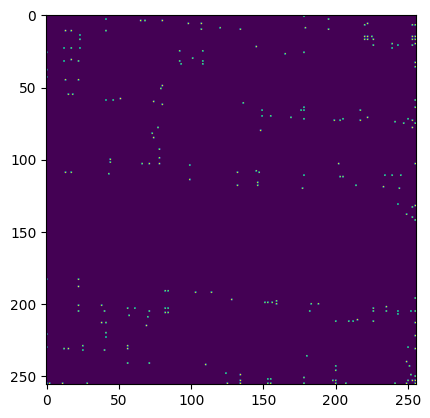

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Segmentation Loss:  tensor(0.7032, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(7.5663, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 64 - Loss: 15.598546881841349


  0%|          | 0/1 [00:00<?, ?it/s]

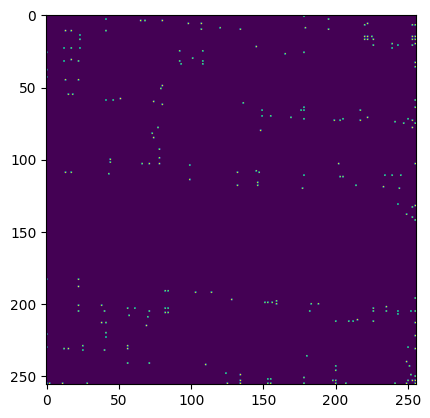

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Segmentation Loss:  tensor(0.7032, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(7.5076, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 65 - Loss: 15.53935325232698


  0%|          | 0/1 [00:00<?, ?it/s]

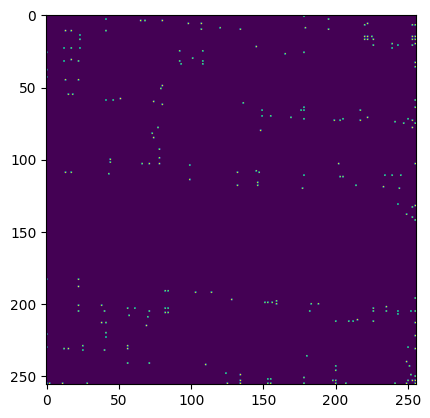

100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


Segmentation Loss:  tensor(0.7044, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(7.4479, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 66 - Loss: 15.491952765738445


  0%|          | 0/1 [00:00<?, ?it/s]

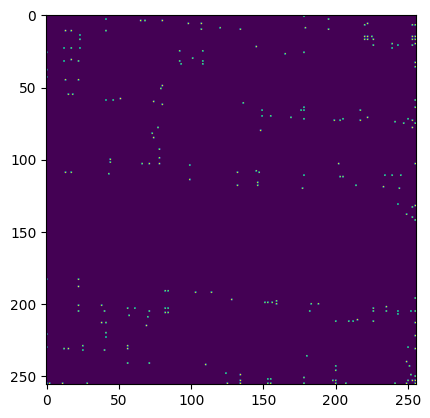

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Segmentation Loss:  tensor(0.7049, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(7.3902, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 67 - Loss: 15.439149751546651


  0%|          | 0/1 [00:00<?, ?it/s]

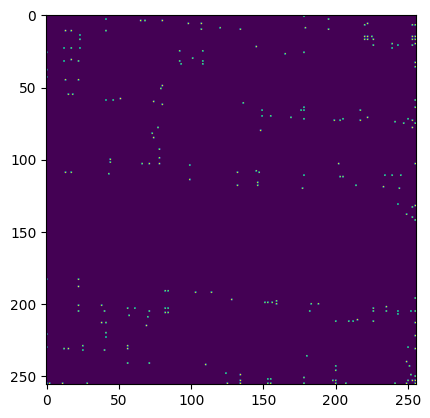

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Segmentation Loss:  tensor(0.7046, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(7.3313, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 68 - Loss: 15.37692051793405


  0%|          | 0/1 [00:00<?, ?it/s]

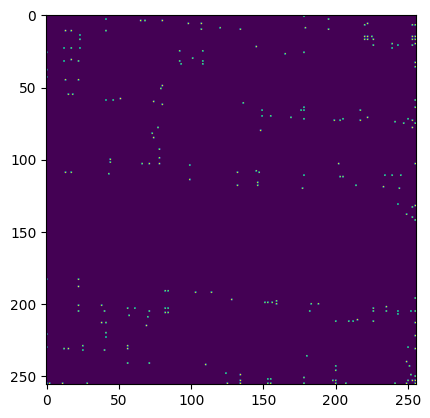

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Segmentation Loss:  tensor(0.7046, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(7.2729, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 69 - Loss: 15.319011537365002


  0%|          | 0/1 [00:00<?, ?it/s]

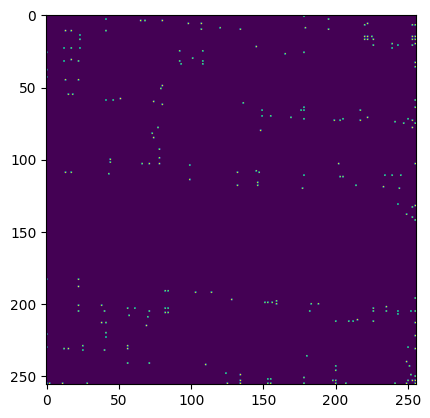

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Segmentation Loss:  tensor(0.7050, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(7.2157, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 70 - Loss: 15.265470406761557


  0%|          | 0/1 [00:00<?, ?it/s]

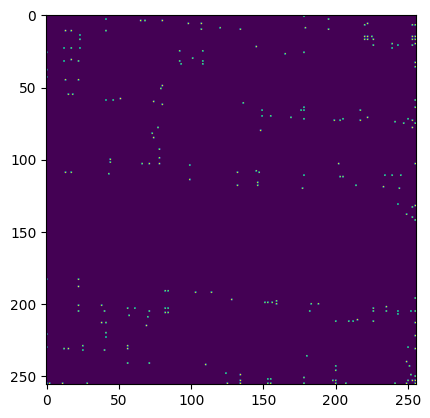

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Segmentation Loss:  tensor(0.7049, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(7.1573, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 71 - Loss: 15.206102291745811


  0%|          | 0/1 [00:00<?, ?it/s]

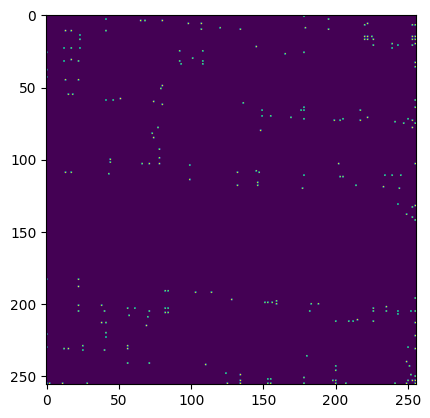

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Segmentation Loss:  tensor(0.7047, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(7.0995, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 72 - Loss: 15.14604940299653


  0%|          | 0/1 [00:00<?, ?it/s]

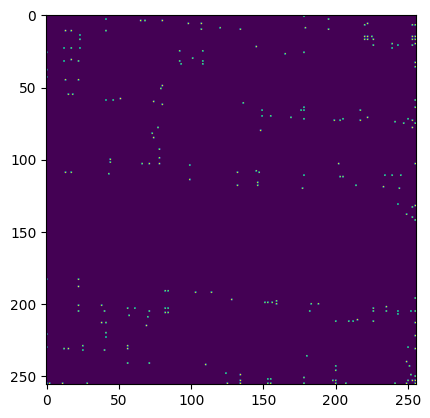

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Segmentation Loss:  tensor(0.7049, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(7.0415, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 73 - Loss: 15.090450204600636


  0%|          | 0/1 [00:00<?, ?it/s]

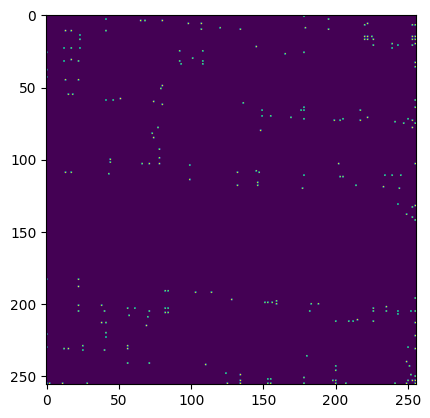

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Segmentation Loss:  tensor(0.7049, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(6.9850, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 74 - Loss: 15.034337928852741


  0%|          | 0/1 [00:00<?, ?it/s]

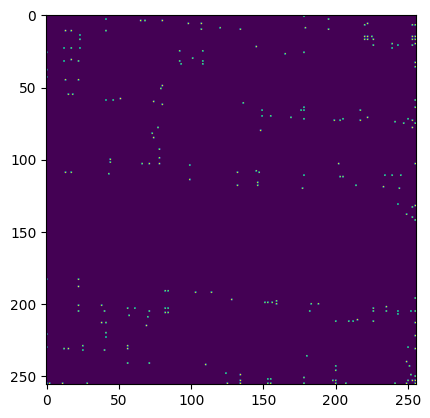

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Segmentation Loss:  tensor(0.7048, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(6.9295, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 75 - Loss: 14.977659121907125


  0%|          | 0/1 [00:00<?, ?it/s]

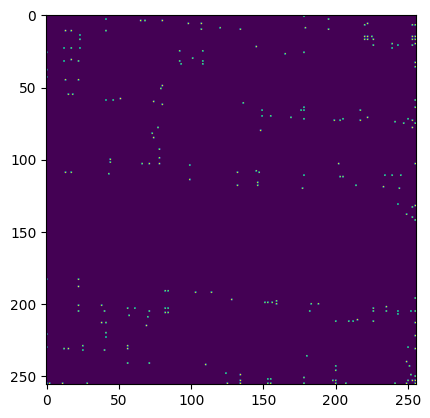

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Segmentation Loss:  tensor(0.7053, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(6.8753, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 76 - Loss: 14.928723254881419


  0%|          | 0/1 [00:00<?, ?it/s]

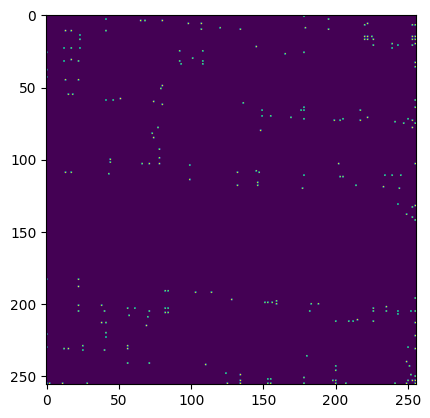

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Segmentation Loss:  tensor(0.7051, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(6.8209, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 77 - Loss: 14.87219800720254


  0%|          | 0/1 [00:00<?, ?it/s]

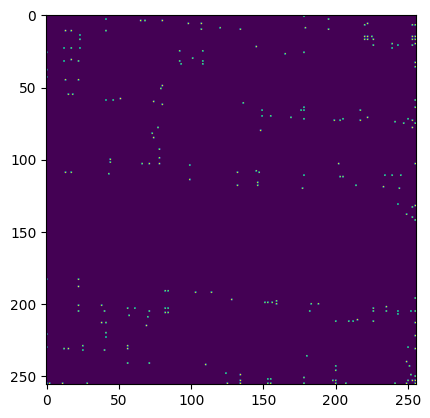

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Segmentation Loss:  tensor(0.7054, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(6.7668, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 78 - Loss: 14.820423010134652


  0%|          | 0/1 [00:00<?, ?it/s]

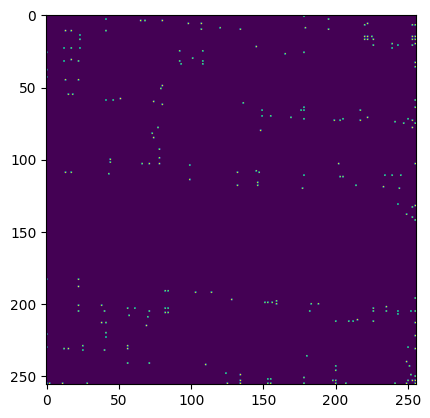

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Segmentation Loss:  tensor(0.7054, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(6.7120, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 79 - Loss: 14.766300114737833


  0%|          | 0/1 [00:00<?, ?it/s]

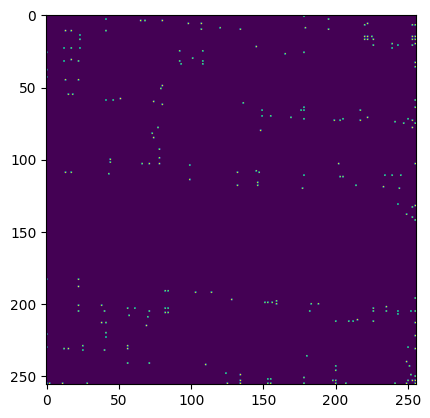

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Segmentation Loss:  tensor(0.7053, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(6.6614, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 80 - Loss: 14.714127451822181


  0%|          | 0/1 [00:00<?, ?it/s]

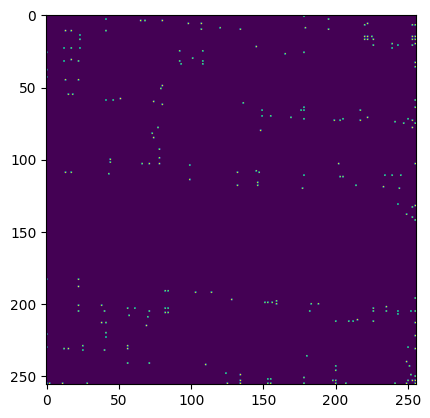

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Segmentation Loss:  tensor(0.7055, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(6.6111, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 81 - Loss: 14.665902982617267


  0%|          | 0/1 [00:00<?, ?it/s]

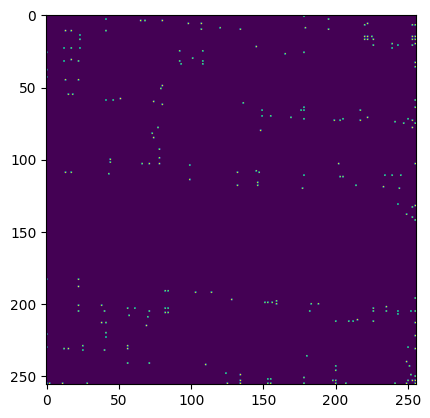

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Segmentation Loss:  tensor(0.7054, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(6.5607, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 82 - Loss: 14.615177045727618


  0%|          | 0/1 [00:00<?, ?it/s]

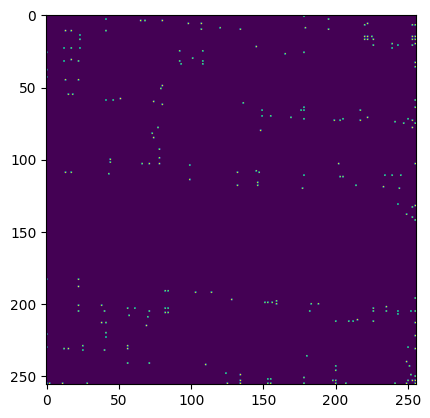

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Segmentation Loss:  tensor(0.7054, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(6.5103, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 83 - Loss: 14.564310918713458


  0%|          | 0/1 [00:00<?, ?it/s]

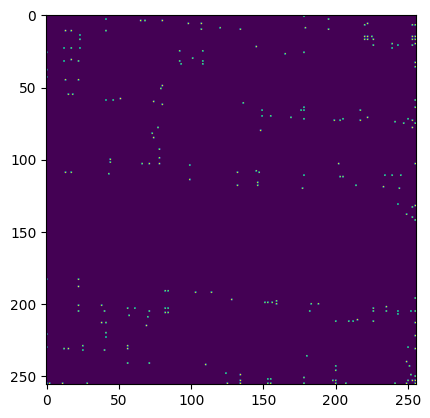

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Segmentation Loss:  tensor(0.7054, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(6.4634, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 84 - Loss: 14.517433053872642


  0%|          | 0/1 [00:00<?, ?it/s]

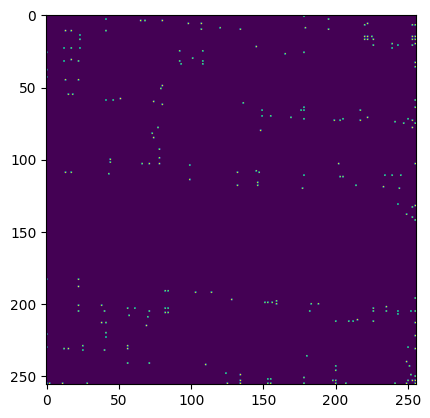

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Segmentation Loss:  tensor(0.7053, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(6.4186, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 85 - Loss: 14.471544183826945


  0%|          | 0/1 [00:00<?, ?it/s]

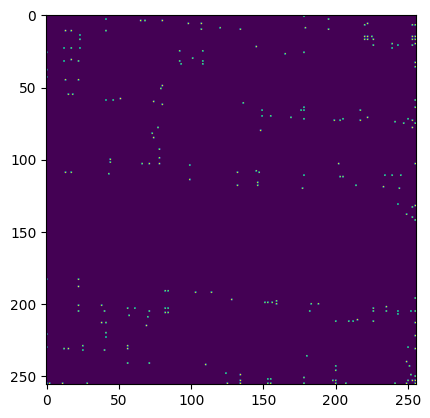

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Segmentation Loss:  tensor(0.7055, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(6.3723, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 86 - Loss: 14.427160184369816


  0%|          | 0/1 [00:00<?, ?it/s]

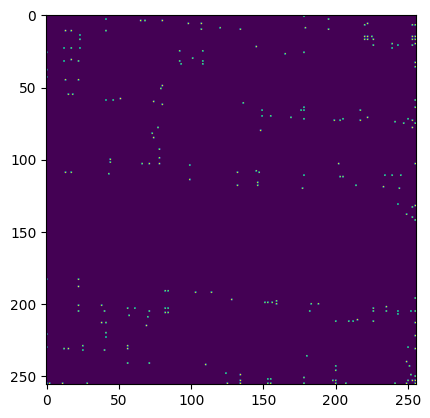

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Segmentation Loss:  tensor(0.7052, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(6.3273, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 87 - Loss: 14.379484097944035


  0%|          | 0/1 [00:00<?, ?it/s]

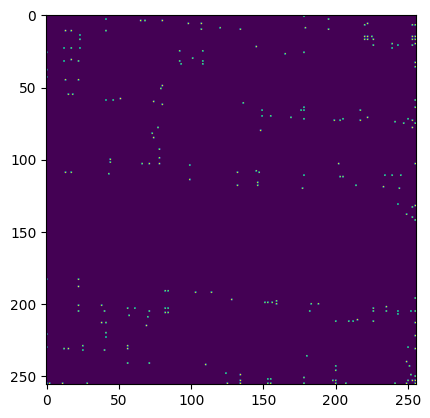

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Segmentation Loss:  tensor(0.7047, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(6.2868, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 88 - Loss: 14.333906095014347


  0%|          | 0/1 [00:00<?, ?it/s]

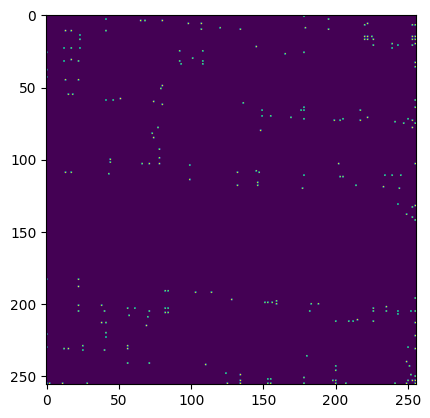

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Segmentation Loss:  tensor(0.7047, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(6.2448, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 89 - Loss: 14.291469465790323


  0%|          | 0/1 [00:00<?, ?it/s]

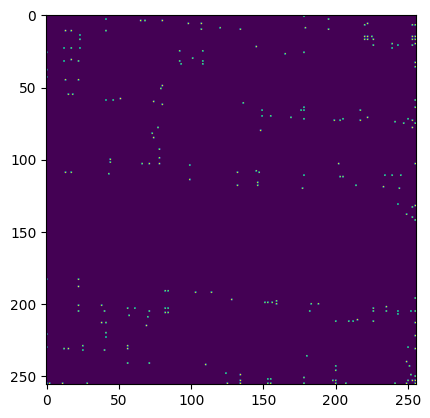

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Segmentation Loss:  tensor(0.7047, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(6.2050, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 90 - Loss: 14.25184239059501


  0%|          | 0/1 [00:00<?, ?it/s]

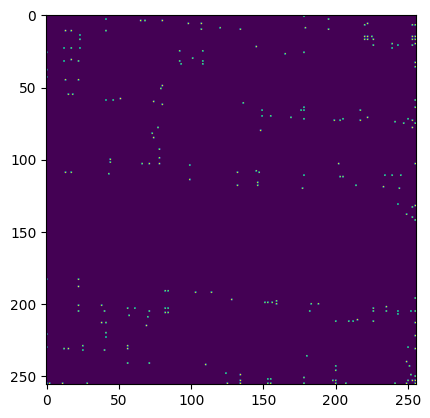

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Segmentation Loss:  tensor(0.7051, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(6.1674, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 91 - Loss: 14.218329351126641


  0%|          | 0/1 [00:00<?, ?it/s]

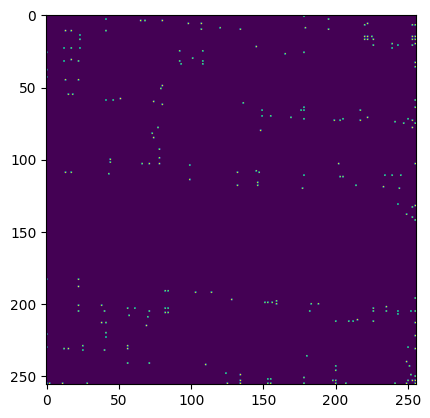

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Segmentation Loss:  tensor(0.7049, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(6.1307, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 92 - Loss: 14.179410822040177


  0%|          | 0/1 [00:00<?, ?it/s]

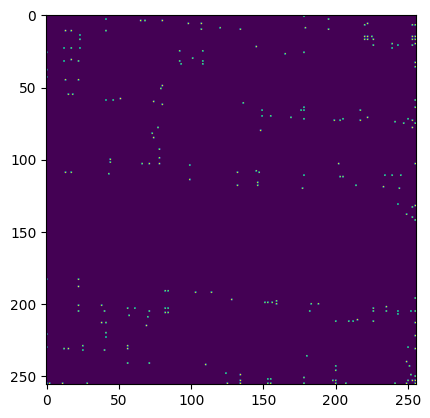

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Segmentation Loss:  tensor(0.7047, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(6.0949, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 93 - Loss: 14.14239299944819


  0%|          | 0/1 [00:00<?, ?it/s]

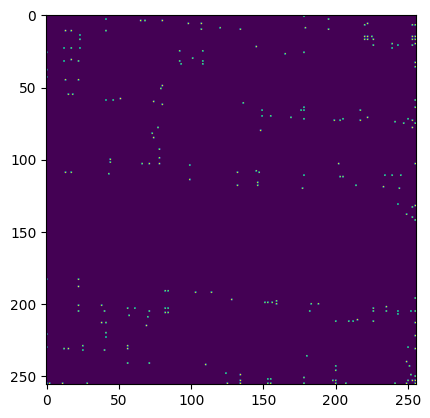

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Segmentation Loss:  tensor(0.7045, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(6.0620, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 94 - Loss: 14.106953511939398


  0%|          | 0/1 [00:00<?, ?it/s]

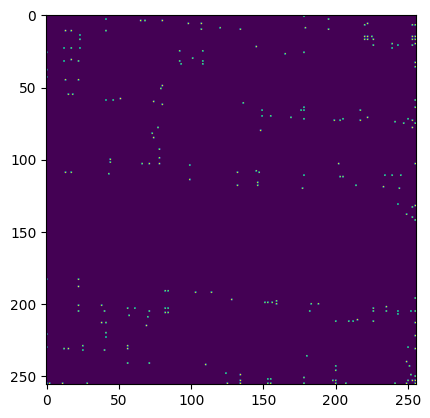

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Segmentation Loss:  tensor(0.7039, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(6.0305, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 95 - Loss: 14.069786946193576


  0%|          | 0/1 [00:00<?, ?it/s]

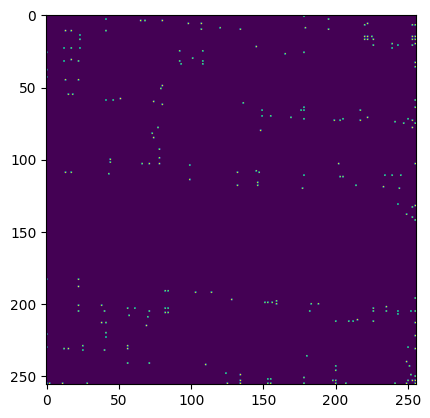

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.9998, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 96 - Loss: 14.042093201484997


  0%|          | 0/1 [00:00<?, ?it/s]

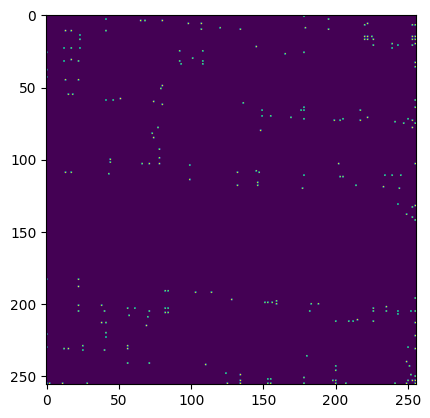

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Segmentation Loss:  tensor(0.7044, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.9715, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 97 - Loss: 14.01562683185609


  0%|          | 0/1 [00:00<?, ?it/s]

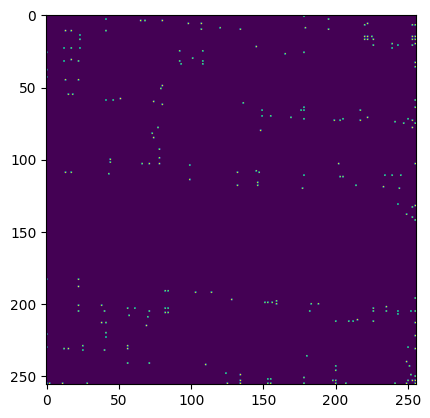

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Segmentation Loss:  tensor(0.7041, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.9446, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 98 - Loss: 13.985619441212627


  0%|          | 0/1 [00:00<?, ?it/s]

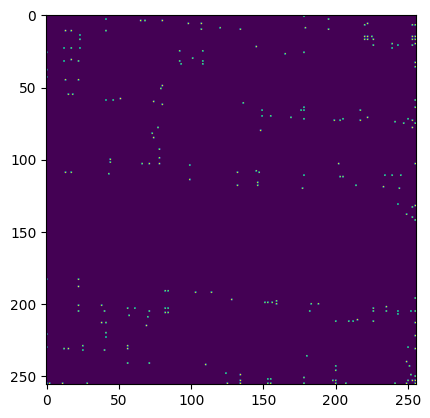

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.9188, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 99 - Loss: 13.960721909656728


  0%|          | 0/1 [00:00<?, ?it/s]

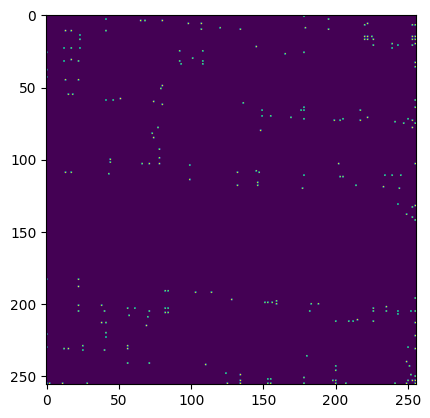

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Segmentation Loss:  tensor(0.7038, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.8948, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 100 - Loss: 13.932635235679887


  0%|          | 0/1 [00:00<?, ?it/s]

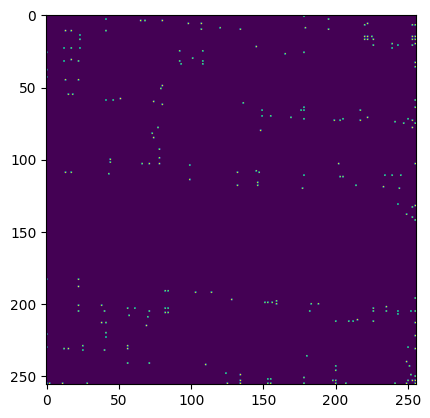

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Segmentation Loss:  tensor(0.7041, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.8722, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 101 - Loss: 13.912723479075956


  0%|          | 0/1 [00:00<?, ?it/s]

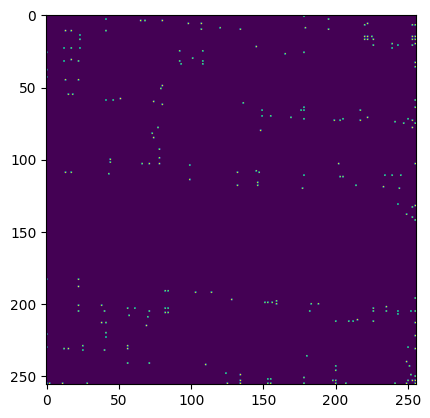

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Segmentation Loss:  tensor(0.7038, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.8512, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 102 - Loss: 13.889435682670594


  0%|          | 0/1 [00:00<?, ?it/s]

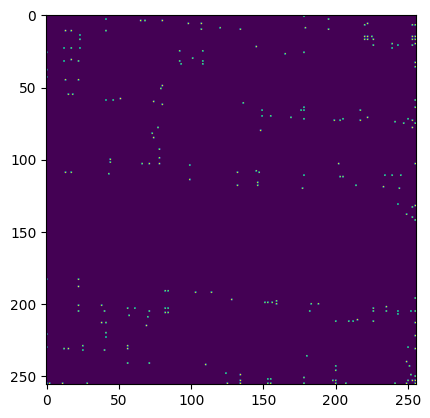

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Segmentation Loss:  tensor(0.7041, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.8313, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 103 - Loss: 13.871885251962421


  0%|          | 0/1 [00:00<?, ?it/s]

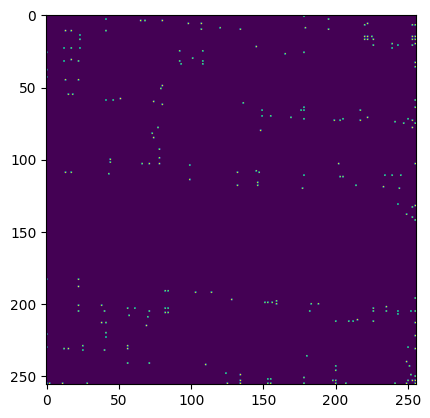

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.8128, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 104 - Loss: 13.854427289926289


  0%|          | 0/1 [00:00<?, ?it/s]

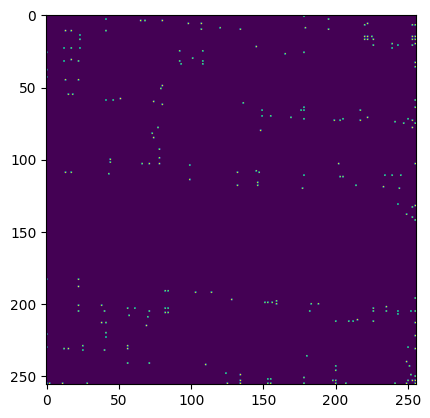

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.7955, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 105 - Loss: 13.837772320927138


  0%|          | 0/1 [00:00<?, ?it/s]

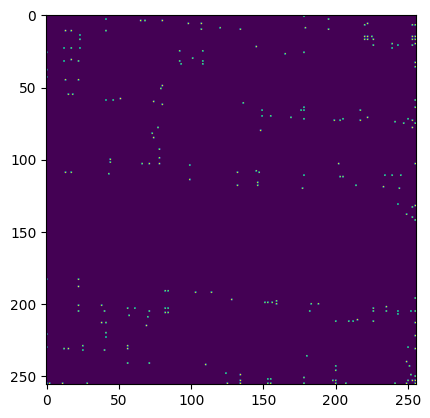

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.7796, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 106 - Loss: 13.821878384769912


  0%|          | 0/1 [00:00<?, ?it/s]

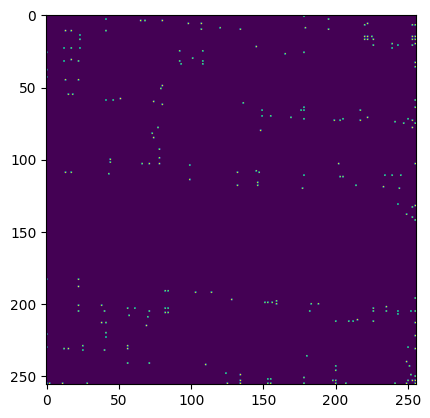

100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.7646, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 107 - Loss: 13.80684275549745


  0%|          | 0/1 [00:00<?, ?it/s]

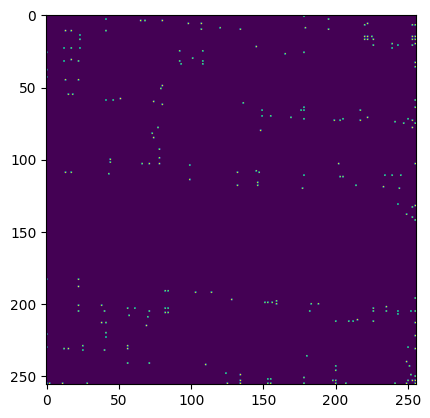

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.7509, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 108 - Loss: 13.792927695013995


  0%|          | 0/1 [00:00<?, ?it/s]

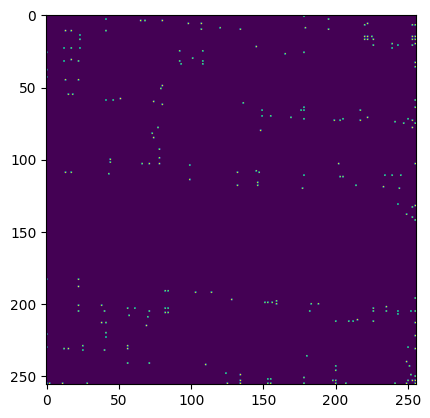

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.7381, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 109 - Loss: 13.780110310549063


  0%|          | 0/1 [00:00<?, ?it/s]

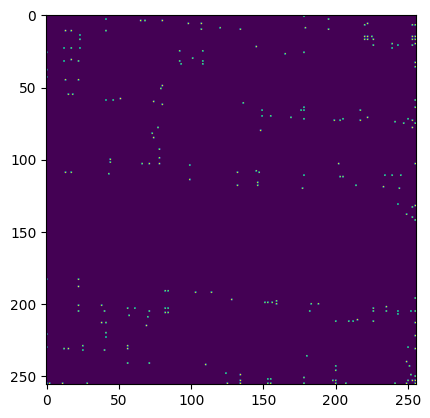

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.7262, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 110 - Loss: 13.768255187134951


  0%|          | 0/1 [00:00<?, ?it/s]

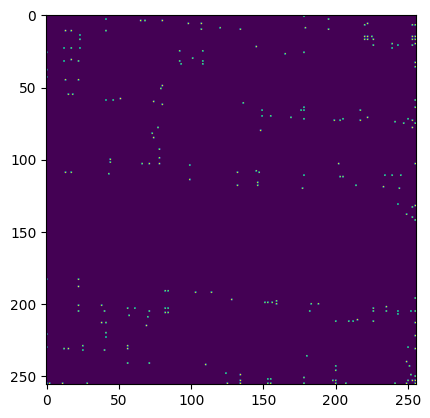

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.7153, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 111 - Loss: 13.757347058290762


  0%|          | 0/1 [00:00<?, ?it/s]

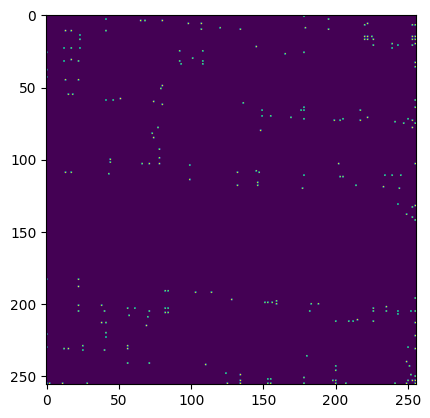

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Segmentation Loss:  tensor(0.7041, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.7051, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 112 - Loss: 13.74639030035329


  0%|          | 0/1 [00:00<?, ?it/s]

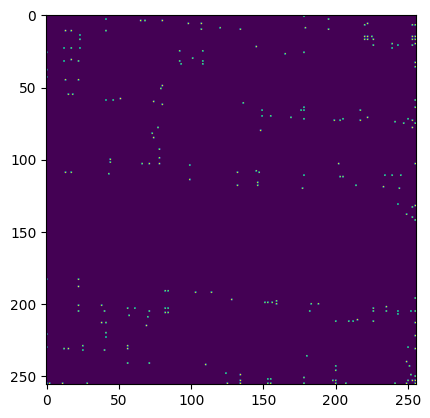

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Segmentation Loss:  tensor(0.7041, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.6957, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 113 - Loss: 13.736651384206464


  0%|          | 0/1 [00:00<?, ?it/s]

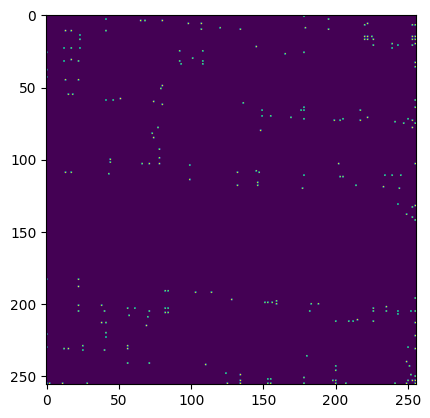

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Segmentation Loss:  tensor(0.7038, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.6870, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 114 - Loss: 13.725154838670093


  0%|          | 0/1 [00:00<?, ?it/s]

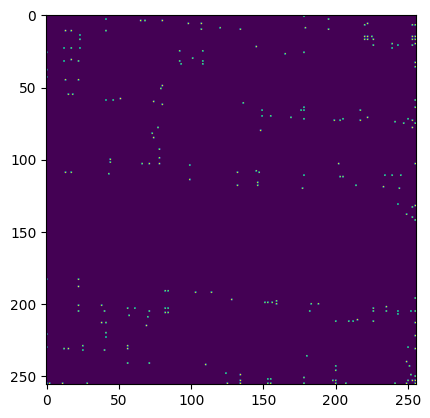

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Segmentation Loss:  tensor(0.7038, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.6791, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 115 - Loss: 13.71720500956853


  0%|          | 0/1 [00:00<?, ?it/s]

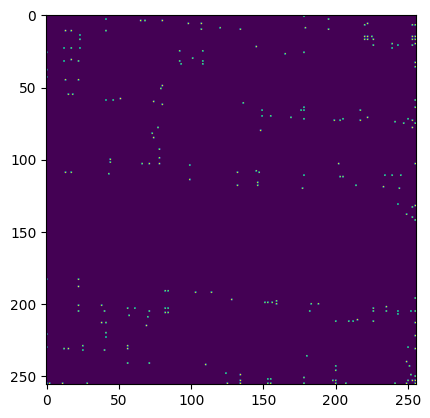

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Segmentation Loss:  tensor(0.7038, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.6716, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 116 - Loss: 13.709775886643726


  0%|          | 0/1 [00:00<?, ?it/s]

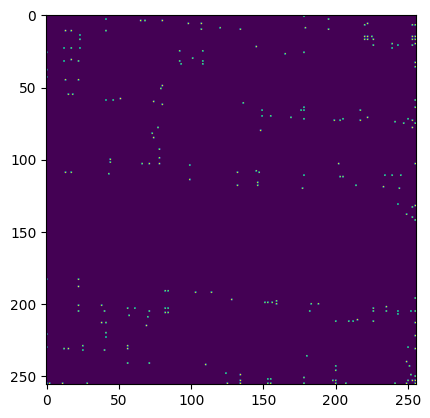

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Segmentation Loss:  tensor(0.7037, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.6648, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 117 - Loss: 13.702019647792218


  0%|          | 0/1 [00:00<?, ?it/s]

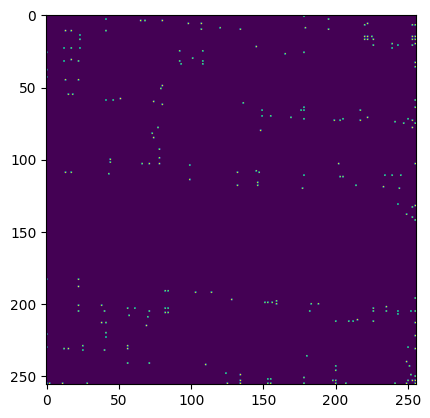

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Segmentation Loss:  tensor(0.7037, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.6585, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 118 - Loss: 13.695702509120343


  0%|          | 0/1 [00:00<?, ?it/s]

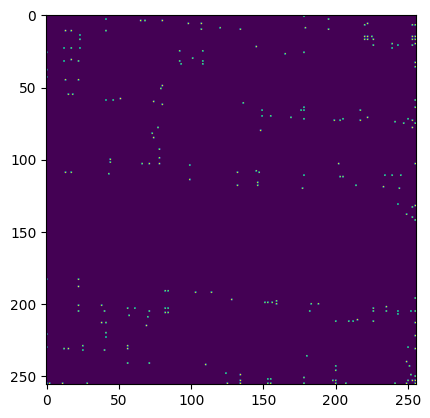

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Segmentation Loss:  tensor(0.7037, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.6526, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 119 - Loss: 13.689815477565167


  0%|          | 0/1 [00:00<?, ?it/s]

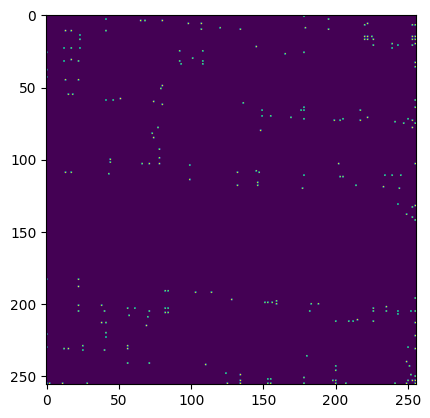

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Segmentation Loss:  tensor(0.7038, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.6472, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 120 - Loss: 13.68544001108537


  0%|          | 0/1 [00:00<?, ?it/s]

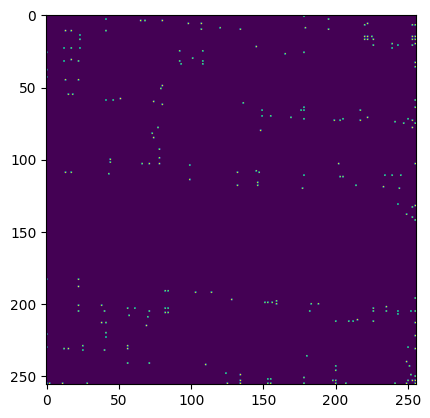

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Segmentation Loss:  tensor(0.7037, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.6421, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 121 - Loss: 13.679352716639874


  0%|          | 0/1 [00:00<?, ?it/s]

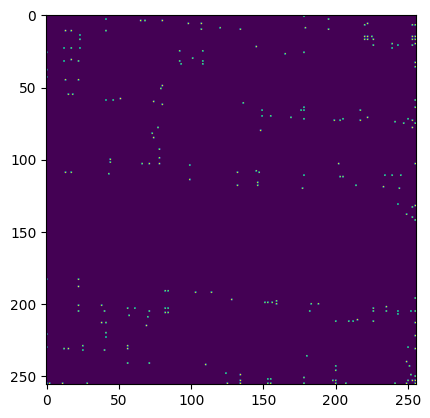

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Segmentation Loss:  tensor(0.7037, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.6374, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 122 - Loss: 13.674642520995487


  0%|          | 0/1 [00:00<?, ?it/s]

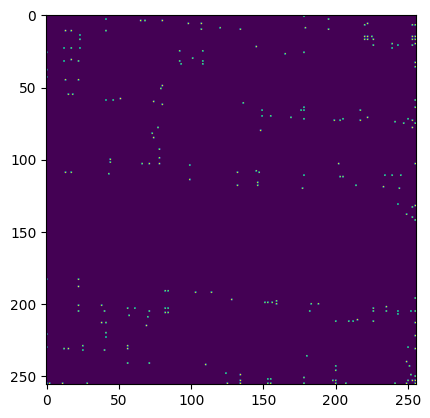

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Segmentation Loss:  tensor(0.7037, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.6331, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 123 - Loss: 13.670332864955304


  0%|          | 0/1 [00:00<?, ?it/s]

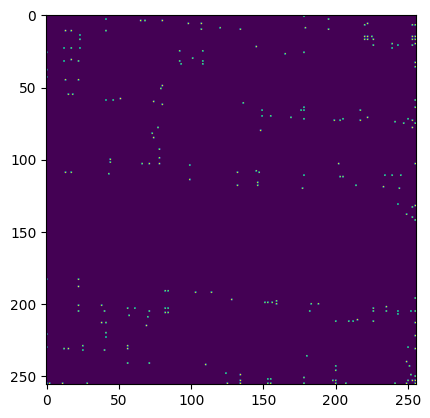

100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Segmentation Loss:  tensor(0.7037, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.6290, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 124 - Loss: 13.665842015485186


  0%|          | 0/1 [00:00<?, ?it/s]

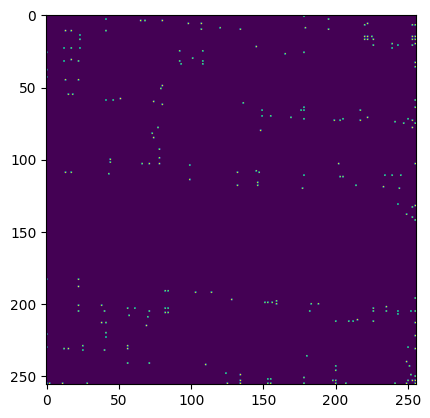

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Segmentation Loss:  tensor(0.7038, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.6252, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 125 - Loss: 13.663055370999908


  0%|          | 0/1 [00:00<?, ?it/s]

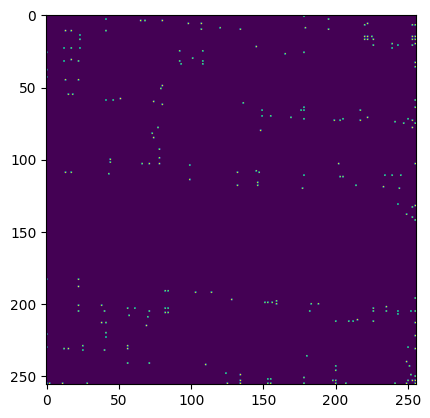

100%|██████████| 1/1 [00:00<00:00,  1.19it/s]


Segmentation Loss:  tensor(0.7039, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.6217, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 126 - Loss: 13.66059775860631


  0%|          | 0/1 [00:00<?, ?it/s]

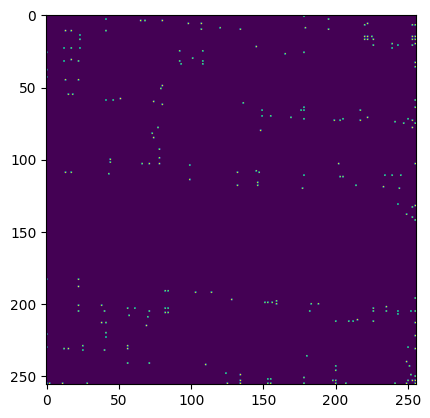

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Segmentation Loss:  tensor(0.7038, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.6184, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 127 - Loss: 13.656171759308478


  0%|          | 0/1 [00:00<?, ?it/s]

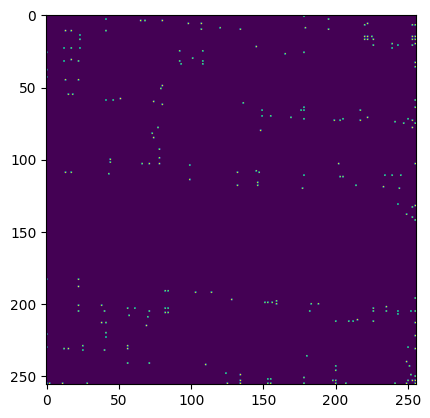

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Segmentation Loss:  tensor(0.7037, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.6155, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 128 - Loss: 13.652349432648322


  0%|          | 0/1 [00:00<?, ?it/s]

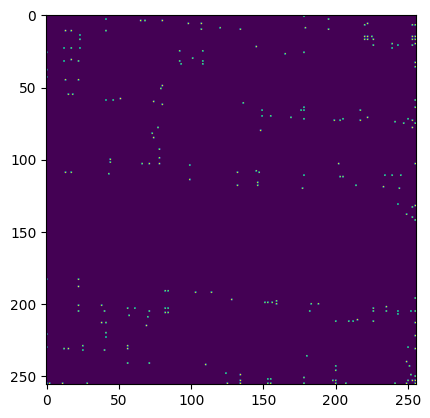

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.6126, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 129 - Loss: 13.65247150361658


  0%|          | 0/1 [00:00<?, ?it/s]

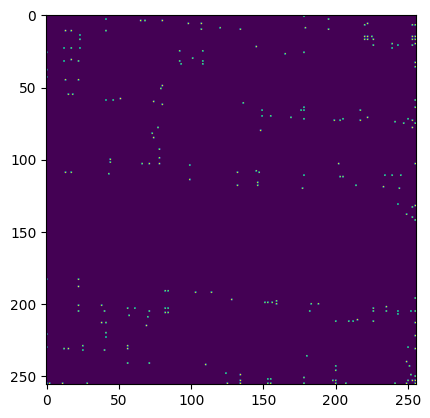

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.6099, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 130 - Loss: 13.64979930818201


  0%|          | 0/1 [00:00<?, ?it/s]

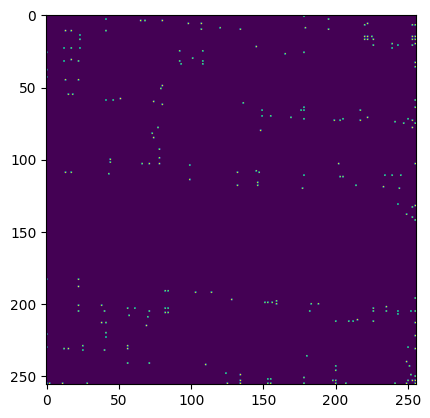

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.6074, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 131 - Loss: 13.64732070863367


  0%|          | 0/1 [00:00<?, ?it/s]

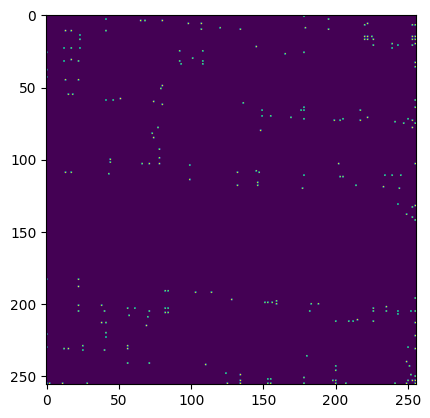

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.6051, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 132 - Loss: 13.645275076073174


  0%|          | 0/1 [00:00<?, ?it/s]

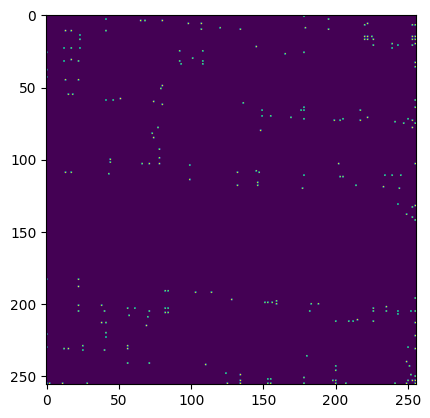

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.6029, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 133 - Loss: 13.643270452660088


  0%|          | 0/1 [00:00<?, ?it/s]

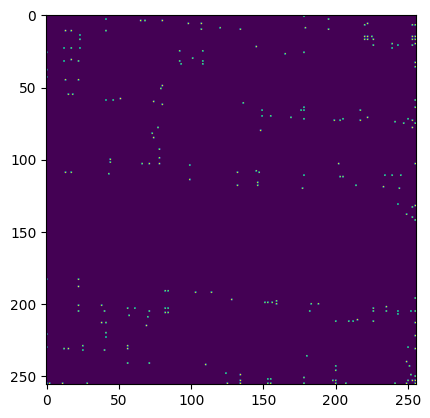

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.6008, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 134 - Loss: 13.641203840416436


  0%|          | 0/1 [00:00<?, ?it/s]

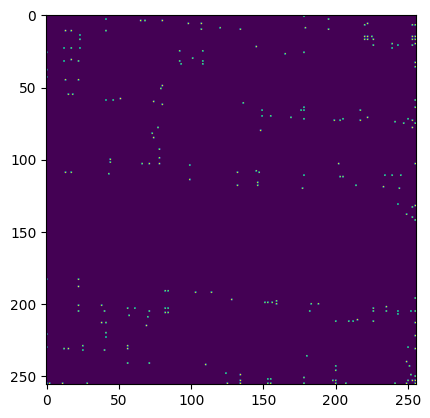

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Segmentation Loss:  tensor(0.7041, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5989, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 135 - Loss: 13.64002985937512


  0%|          | 0/1 [00:00<?, ?it/s]

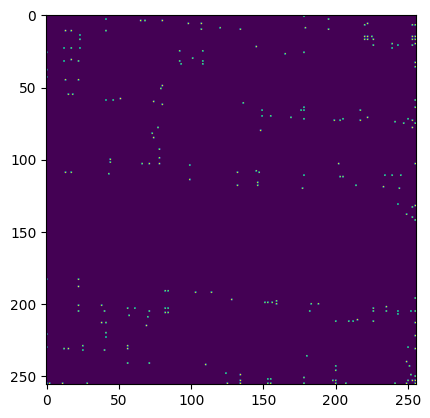

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Segmentation Loss:  tensor(0.7041, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5971, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 136 - Loss: 13.638126325439574


  0%|          | 0/1 [00:00<?, ?it/s]

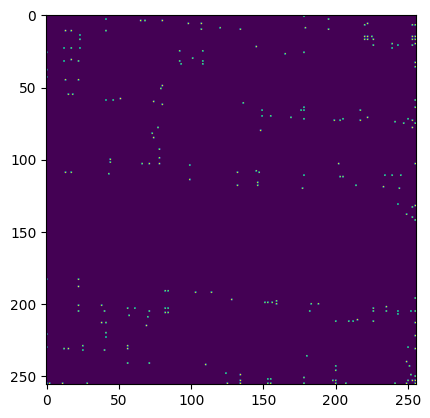

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Segmentation Loss:  tensor(0.7041, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5953, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 137 - Loss: 13.636392545532347


  0%|          | 0/1 [00:00<?, ?it/s]

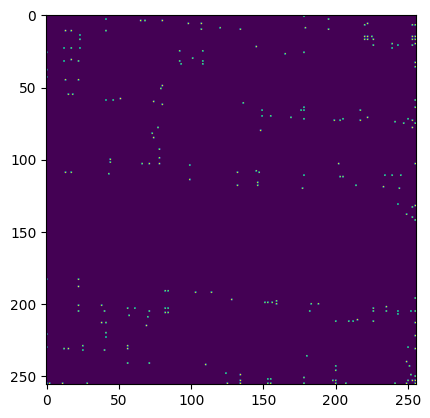

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Segmentation Loss:  tensor(0.7041, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5937, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 138 - Loss: 13.63489527685559


  0%|          | 0/1 [00:00<?, ?it/s]

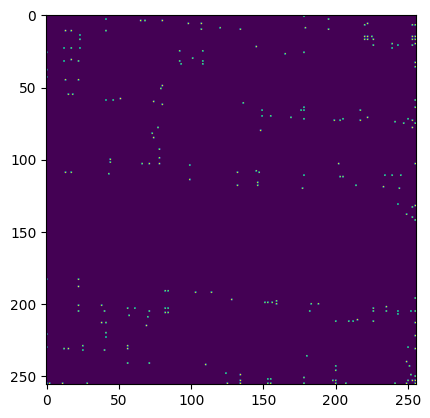

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Segmentation Loss:  tensor(0.7041, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5922, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 139 - Loss: 13.633397055811564


  0%|          | 0/1 [00:00<?, ?it/s]

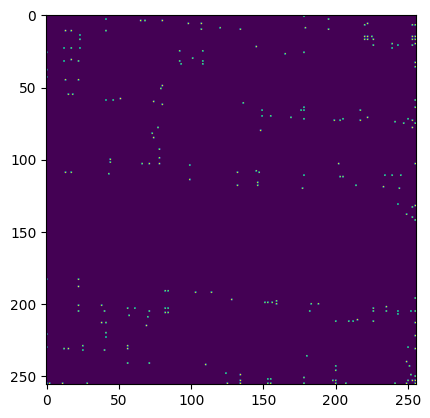

100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


Segmentation Loss:  tensor(0.7041, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5908, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 140 - Loss: 13.631959873127173


  0%|          | 0/1 [00:00<?, ?it/s]

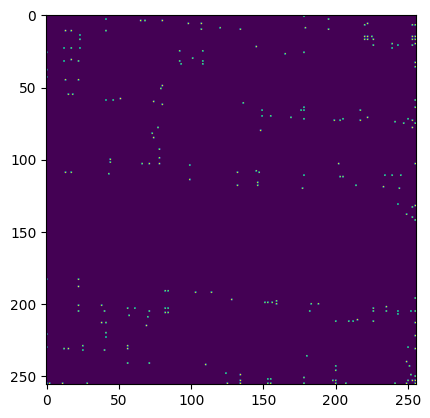

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Segmentation Loss:  tensor(0.7041, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5894, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 141 - Loss: 13.630536988974018


  0%|          | 0/1 [00:00<?, ?it/s]

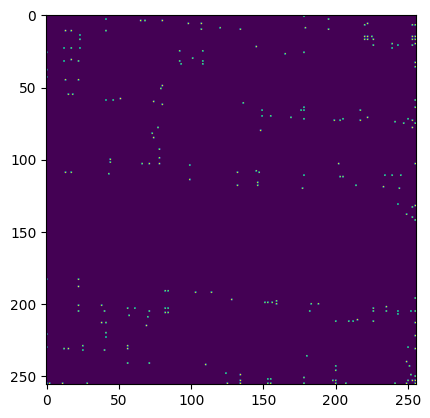

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Segmentation Loss:  tensor(0.7041, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5881, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 142 - Loss: 13.628690675497456


  0%|          | 0/1 [00:00<?, ?it/s]

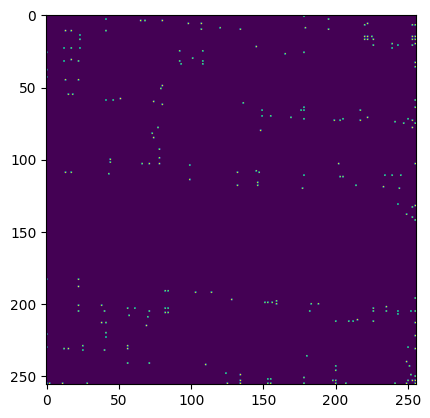

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Segmentation Loss:  tensor(0.7041, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5869, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 143 - Loss: 13.6274709261241


  0%|          | 0/1 [00:00<?, ?it/s]

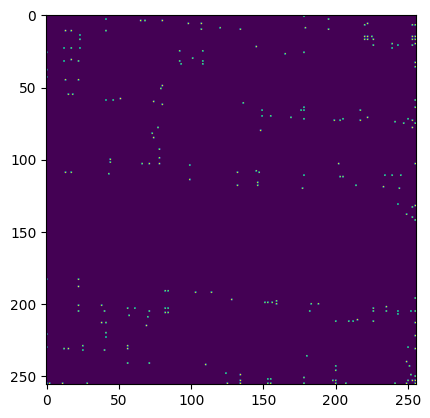

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Segmentation Loss:  tensor(0.7041, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5857, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 144 - Loss: 13.626285502678897


  0%|          | 0/1 [00:00<?, ?it/s]

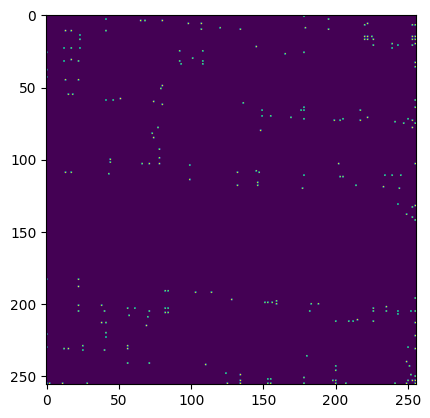

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5846, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 145 - Loss: 13.624990431259562


  0%|          | 0/1 [00:00<?, ?it/s]

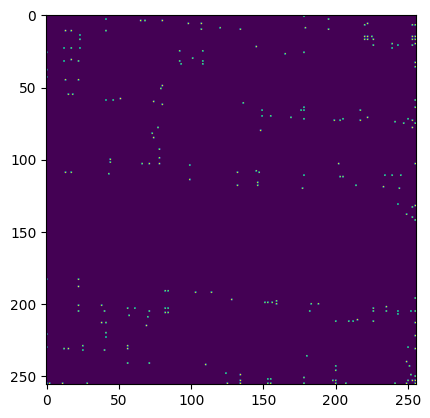

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5836, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 146 - Loss: 13.623968093261622


  0%|          | 0/1 [00:00<?, ?it/s]

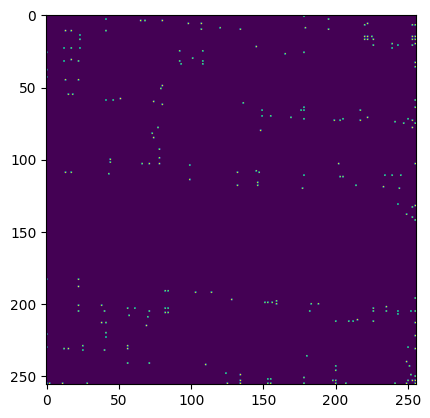

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Segmentation Loss:  tensor(0.7041, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5826, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 147 - Loss: 13.623136473809378


  0%|          | 0/1 [00:00<?, ?it/s]

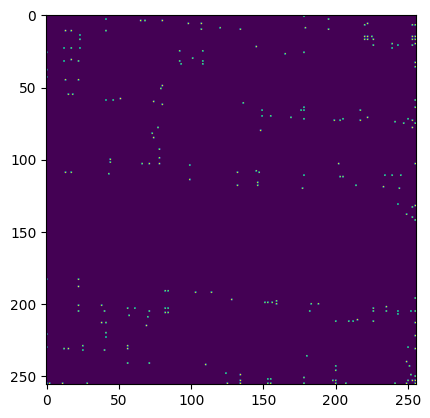

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5816, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 148 - Loss: 13.621993984028581


  0%|          | 0/1 [00:00<?, ?it/s]

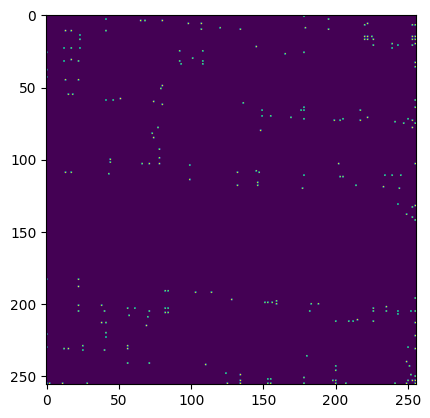

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5807, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 149 - Loss: 13.621068919941667


  0%|          | 0/1 [00:00<?, ?it/s]

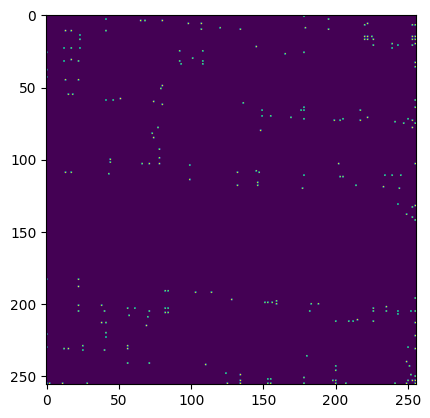

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Segmentation Loss:  tensor(0.7039, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5798, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 150 - Loss: 13.619073839002542


  0%|          | 0/1 [00:00<?, ?it/s]

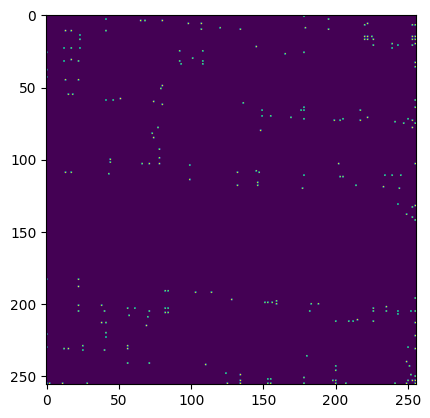

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Segmentation Loss:  tensor(0.7039, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5790, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 151 - Loss: 13.618236512952738


  0%|          | 0/1 [00:00<?, ?it/s]

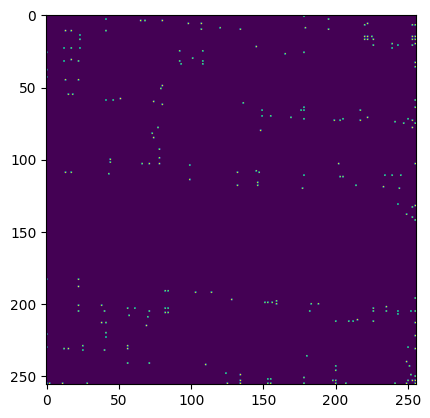

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Segmentation Loss:  tensor(0.7039, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5782, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 152 - Loss: 13.617453546338968


  0%|          | 0/1 [00:00<?, ?it/s]

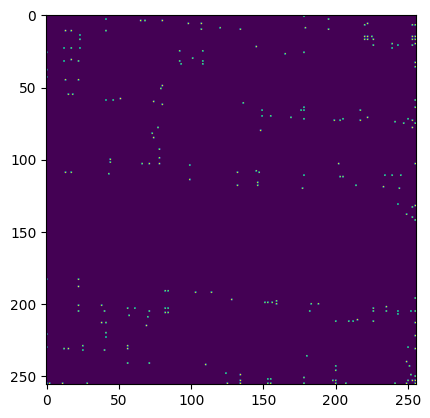

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Segmentation Loss:  tensor(0.7039, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5775, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 153 - Loss: 13.616289110075426


  0%|          | 0/1 [00:00<?, ?it/s]

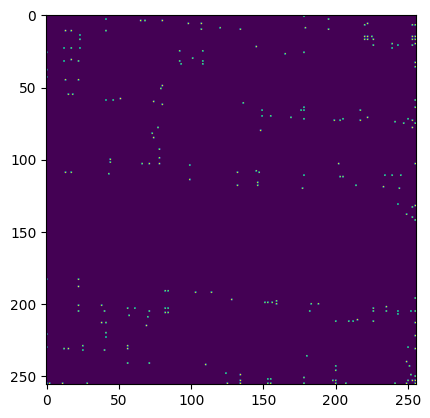

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5767, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 154 - Loss: 13.616748778767068


  0%|          | 0/1 [00:00<?, ?it/s]

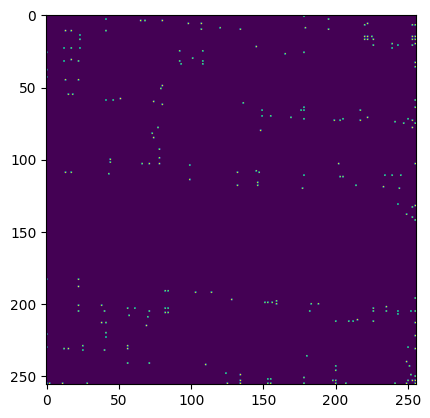

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Segmentation Loss:  tensor(0.7039, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5760, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 155 - Loss: 13.614896748396017


  0%|          | 0/1 [00:00<?, ?it/s]

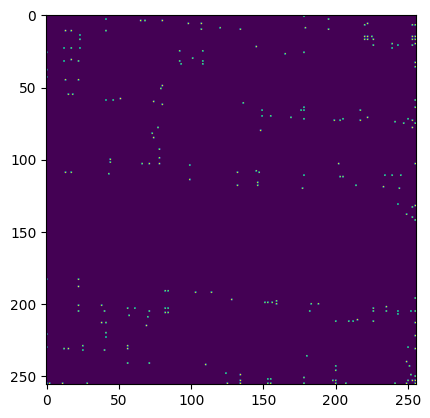

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Segmentation Loss:  tensor(0.7039, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5754, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 156 - Loss: 13.614231083723165


  0%|          | 0/1 [00:00<?, ?it/s]

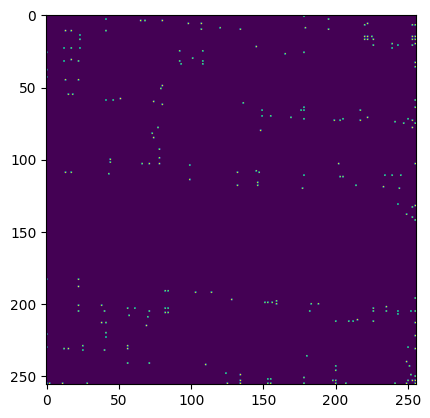

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5747, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 157 - Loss: 13.61432835929711


  0%|          | 0/1 [00:00<?, ?it/s]

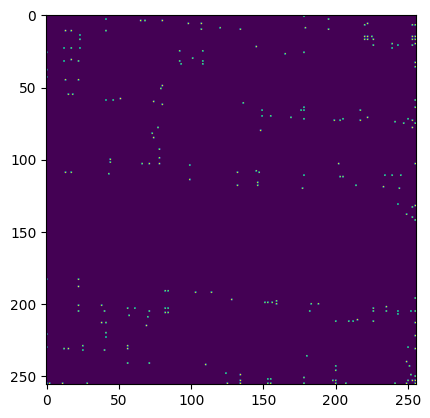

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5741, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 158 - Loss: 13.61371514671166


  0%|          | 0/1 [00:00<?, ?it/s]

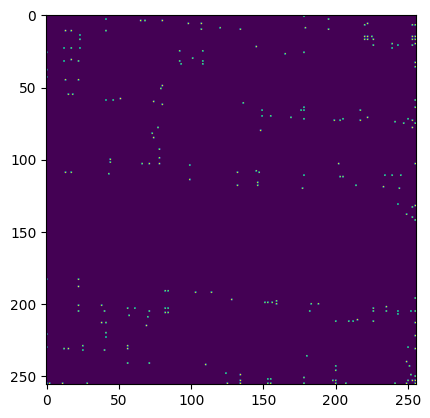

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5735, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 159 - Loss: 13.61312100761254


  0%|          | 0/1 [00:00<?, ?it/s]

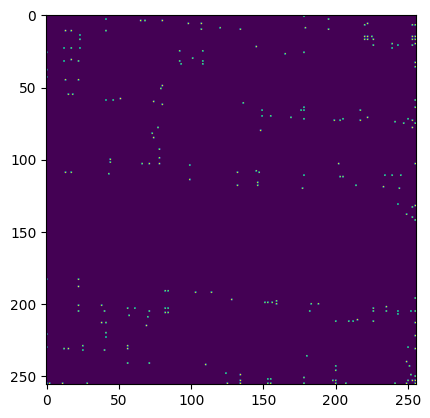

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Segmentation Loss:  tensor(0.7041, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5730, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 160 - Loss: 13.613719906158911


  0%|          | 0/1 [00:00<?, ?it/s]

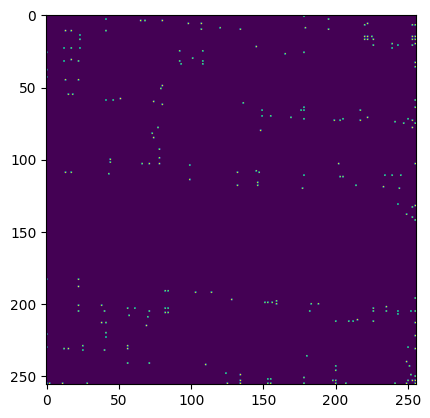

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Segmentation Loss:  tensor(0.7041, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5724, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 161 - Loss: 13.61316296035813


  0%|          | 0/1 [00:00<?, ?it/s]

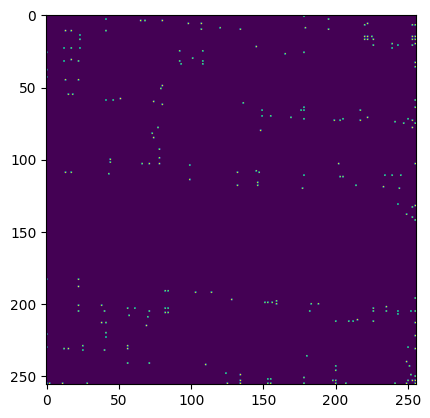

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5719, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 162 - Loss: 13.61149117493153


  0%|          | 0/1 [00:00<?, ?it/s]

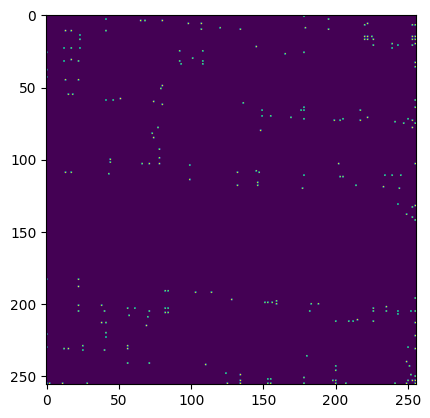

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5714, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 163 - Loss: 13.610967607731823


  0%|          | 0/1 [00:00<?, ?it/s]

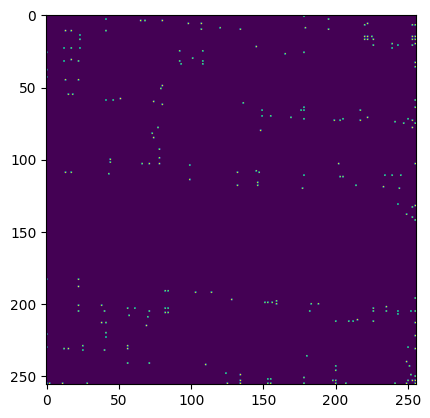

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5709, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 164 - Loss: 13.610478372807506


  0%|          | 0/1 [00:00<?, ?it/s]

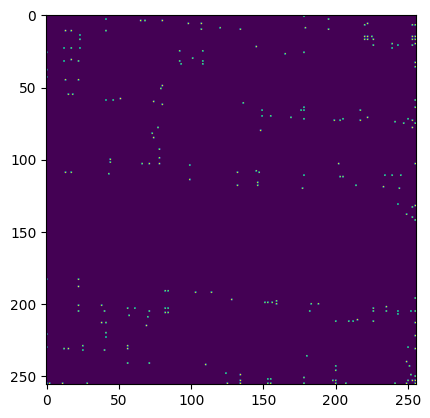

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5704, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 165 - Loss: 13.609977694568597


  0%|          | 0/1 [00:00<?, ?it/s]

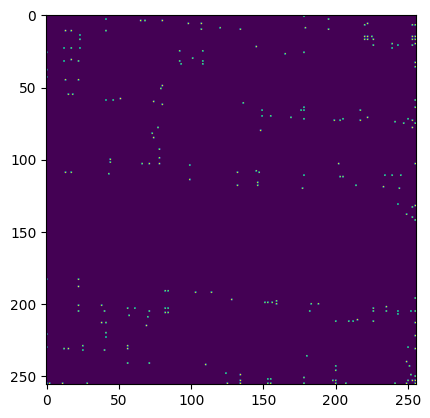

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5699, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 166 - Loss: 13.609516116199456


  0%|          | 0/1 [00:00<?, ?it/s]

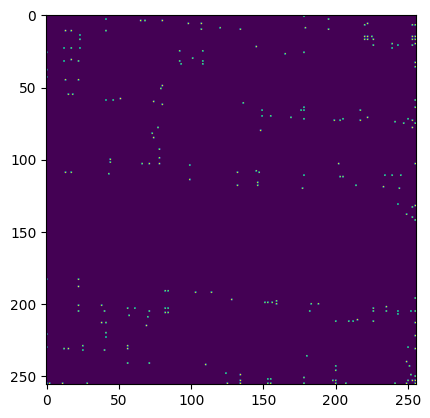

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5695, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 167 - Loss: 13.609079333362542


  0%|          | 0/1 [00:00<?, ?it/s]

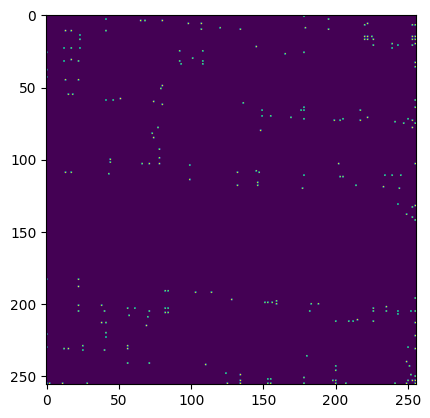

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5691, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 168 - Loss: 13.60864731889721


  0%|          | 0/1 [00:00<?, ?it/s]

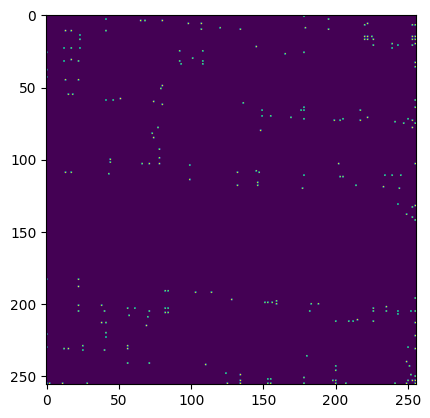

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5686, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 169 - Loss: 13.61019990068432


  0%|          | 0/1 [00:00<?, ?it/s]

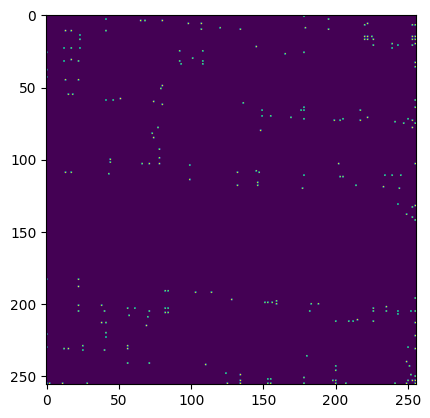

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5682, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 170 - Loss: 13.609788867053949


  0%|          | 0/1 [00:00<?, ?it/s]

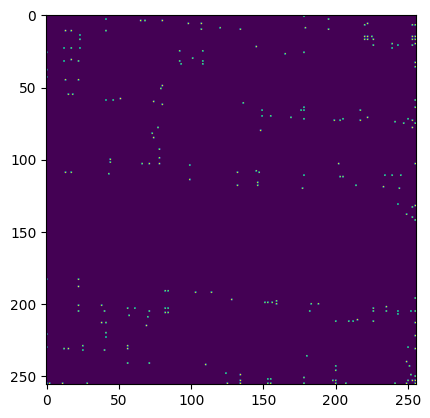

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5678, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 171 - Loss: 13.60939595323559


  0%|          | 0/1 [00:00<?, ?it/s]

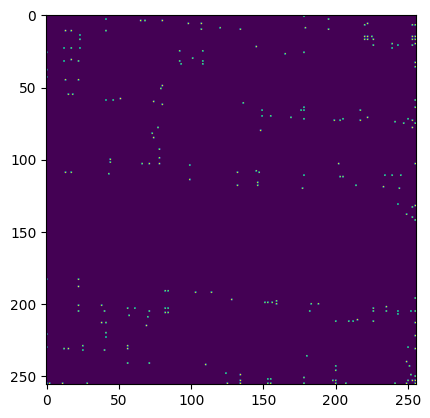

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5675, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 172 - Loss: 13.60902020462359


  0%|          | 0/1 [00:00<?, ?it/s]

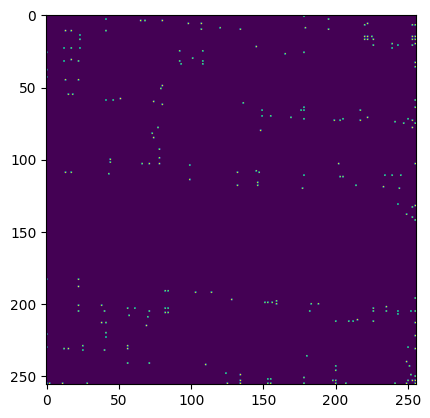

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5671, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 173 - Loss: 13.60865399368609


  0%|          | 0/1 [00:00<?, ?it/s]

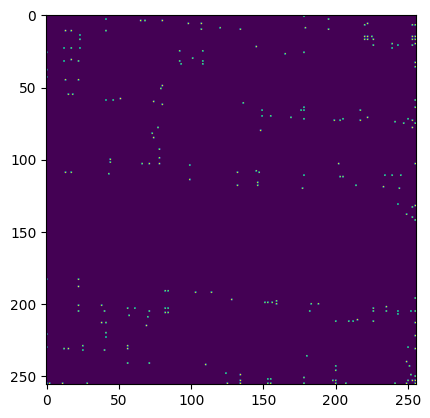

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5667, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 174 - Loss: 13.608279196570027


  0%|          | 0/1 [00:00<?, ?it/s]

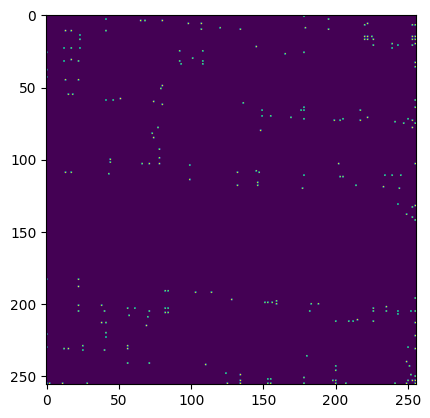

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5664, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 175 - Loss: 13.60795590408648


  0%|          | 0/1 [00:00<?, ?it/s]

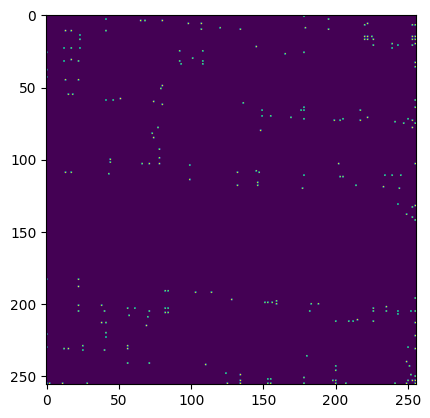

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5661, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 176 - Loss: 13.607618303378473


  0%|          | 0/1 [00:00<?, ?it/s]

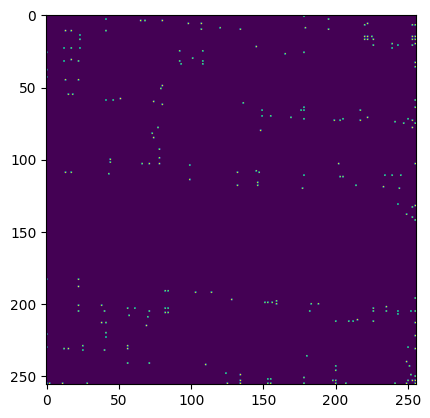

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5657, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 177 - Loss: 13.607284518299066


  0%|          | 0/1 [00:00<?, ?it/s]

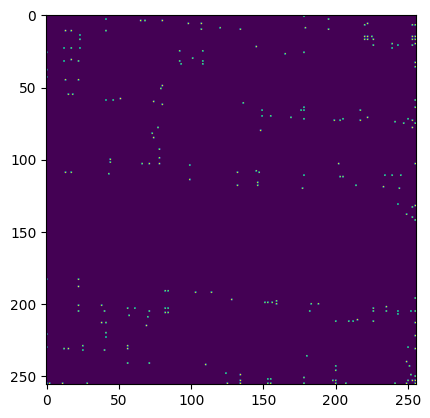

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5654, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 178 - Loss: 13.606967898426019


  0%|          | 0/1 [00:00<?, ?it/s]

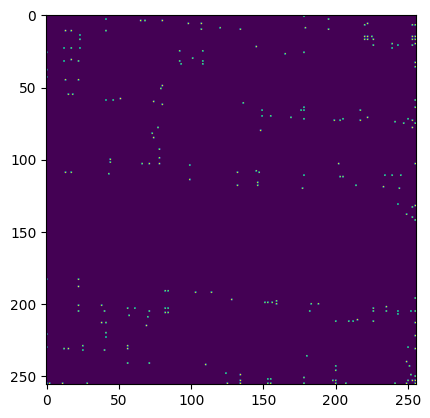

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5651, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 179 - Loss: 13.606655093250238


  0%|          | 0/1 [00:00<?, ?it/s]

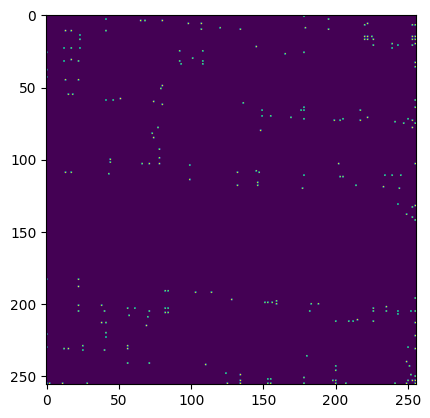

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5648, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 180 - Loss: 13.606356594488409


  0%|          | 0/1 [00:00<?, ?it/s]

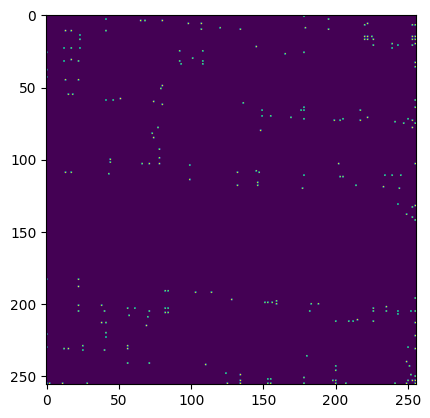

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5645, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 181 - Loss: 13.606066677496221


  0%|          | 0/1 [00:00<?, ?it/s]

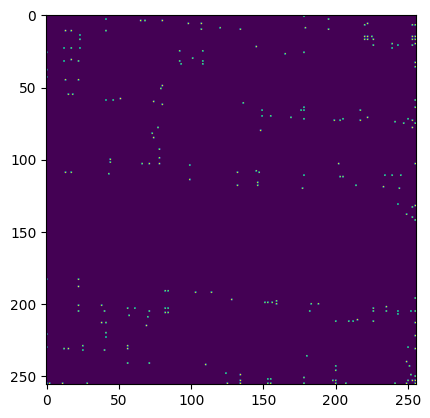

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5642, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 182 - Loss: 13.60578152757641


  0%|          | 0/1 [00:00<?, ?it/s]

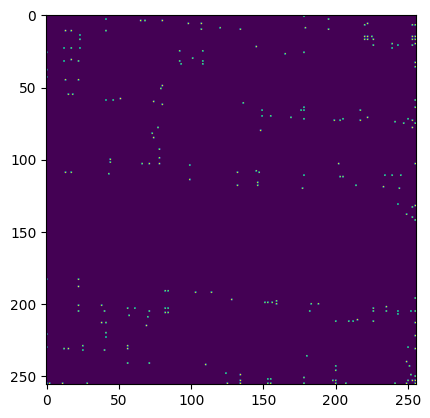

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5640, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 183 - Loss: 13.605504008350335


  0%|          | 0/1 [00:00<?, ?it/s]

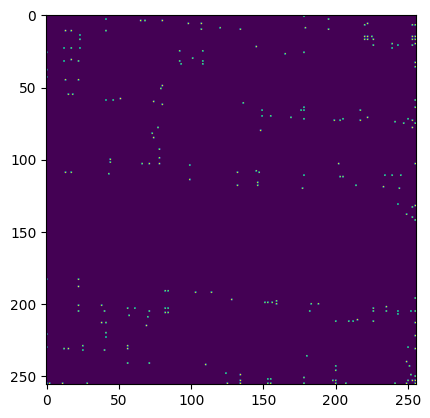

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5637, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 184 - Loss: 13.605236025755598


  0%|          | 0/1 [00:00<?, ?it/s]

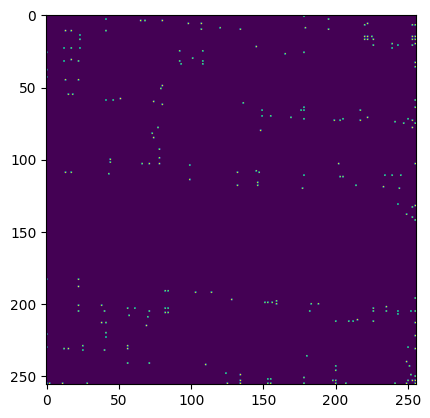

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5634, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 185 - Loss: 13.604968996947004


  0%|          | 0/1 [00:00<?, ?it/s]

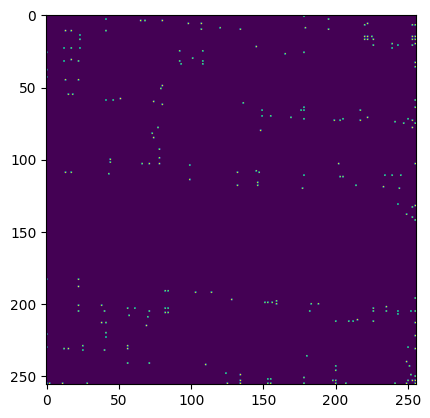

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5632, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 186 - Loss: 13.60471531957884


  0%|          | 0/1 [00:00<?, ?it/s]

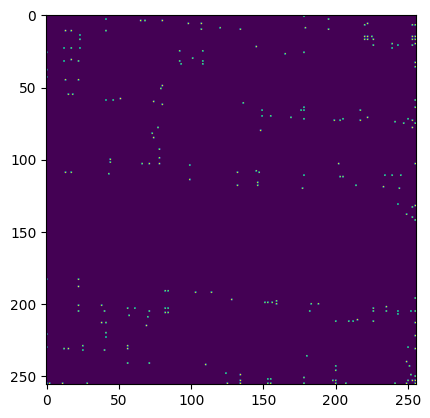

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5629, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 187 - Loss: 13.604458781187727


  0%|          | 0/1 [00:00<?, ?it/s]

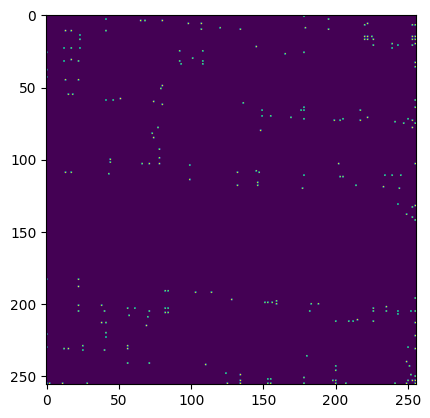

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5627, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 188 - Loss: 13.60421368688841


  0%|          | 0/1 [00:00<?, ?it/s]

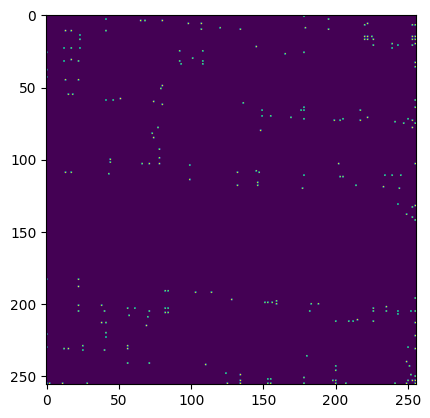

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5624, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 189 - Loss: 13.603974314634993


  0%|          | 0/1 [00:00<?, ?it/s]

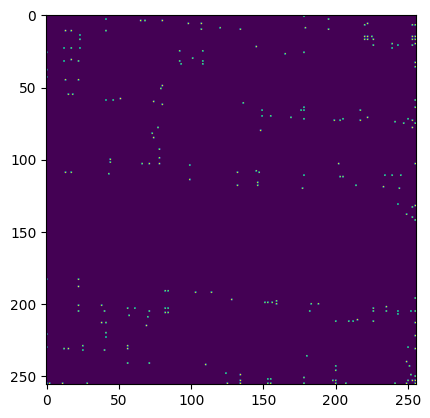

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5622, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 190 - Loss: 13.603737803404524


  0%|          | 0/1 [00:00<?, ?it/s]

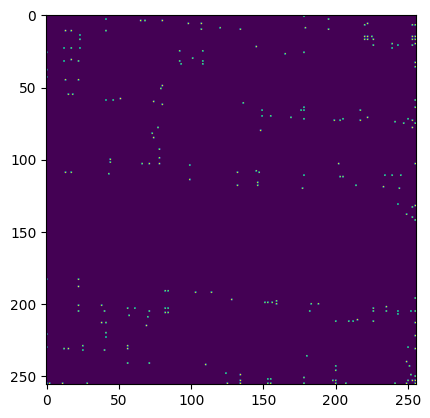

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5620, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 191 - Loss: 13.60350796789427


  0%|          | 0/1 [00:00<?, ?it/s]

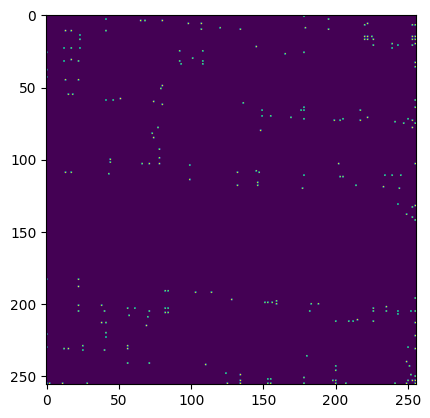

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5617, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 192 - Loss: 13.603286714086172


  0%|          | 0/1 [00:00<?, ?it/s]

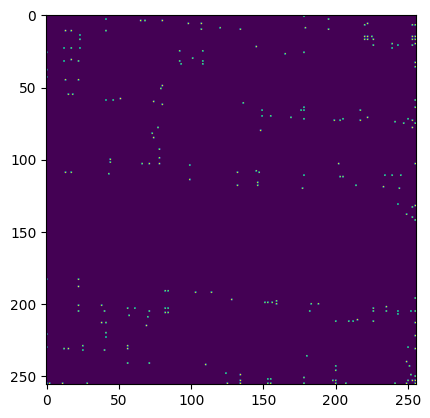

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5615, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 193 - Loss: 13.603071185057356


  0%|          | 0/1 [00:00<?, ?it/s]

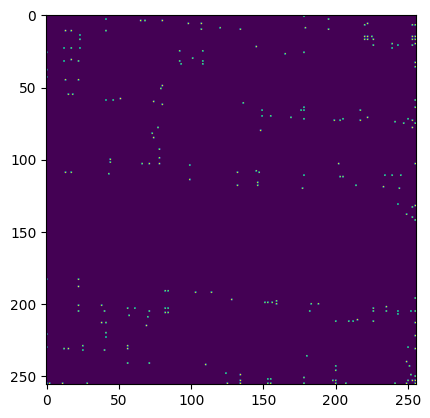

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5613, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 194 - Loss: 13.602861376707747


  0%|          | 0/1 [00:00<?, ?it/s]

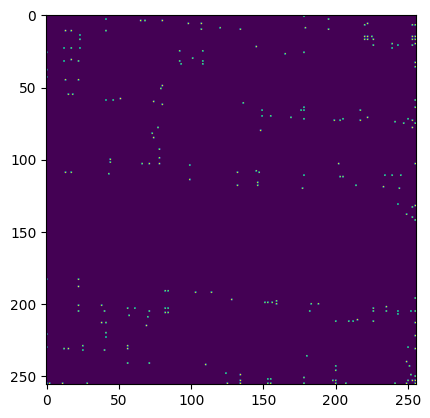

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5611, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 195 - Loss: 13.602651566991446


  0%|          | 0/1 [00:00<?, ?it/s]

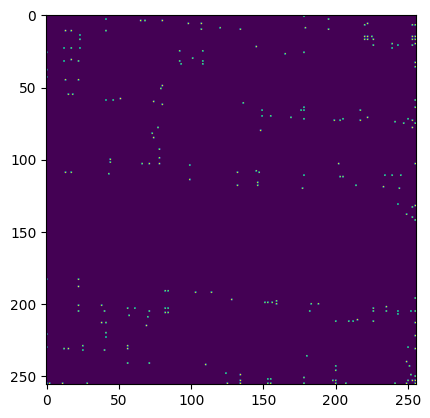

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5609, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 196 - Loss: 13.602446527013418


  0%|          | 0/1 [00:00<?, ?it/s]

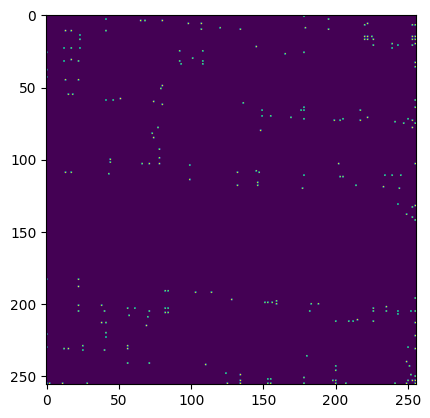

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5607, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 197 - Loss: 13.60225007147093


  0%|          | 0/1 [00:00<?, ?it/s]

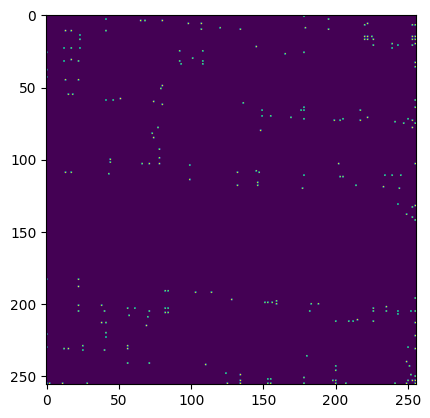

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5605, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 198 - Loss: 13.602051707213118


  0%|          | 0/1 [00:00<?, ?it/s]

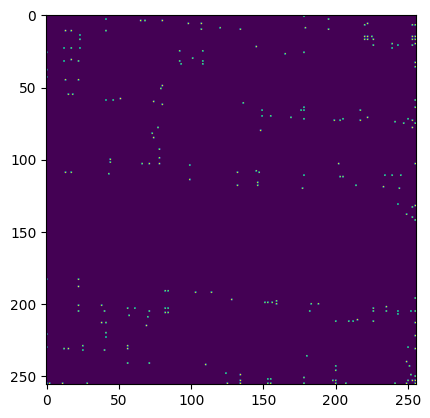

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5603, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 199 - Loss: 13.601865740721419


  0%|          | 0/1 [00:00<?, ?it/s]

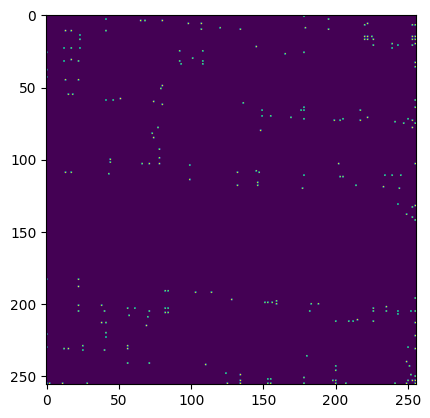

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5601, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 200 - Loss: 13.601680727904036


  0%|          | 0/1 [00:00<?, ?it/s]

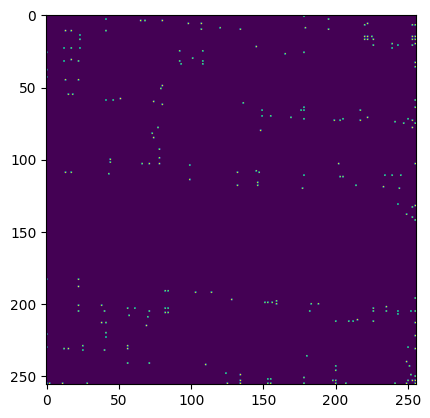

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5599, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 201 - Loss: 13.601500483458235


  0%|          | 0/1 [00:00<?, ?it/s]

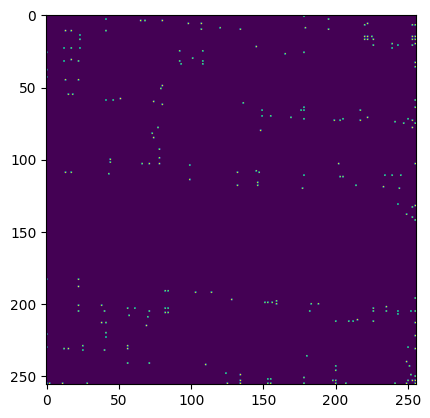

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5598, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 202 - Loss: 13.601320237645742


  0%|          | 0/1 [00:00<?, ?it/s]

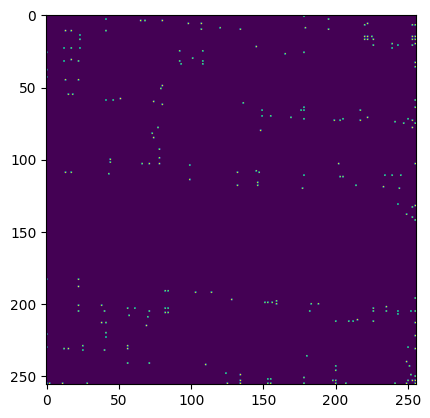

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5596, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 203 - Loss: 13.601148577635481


  0%|          | 0/1 [00:00<?, ?it/s]

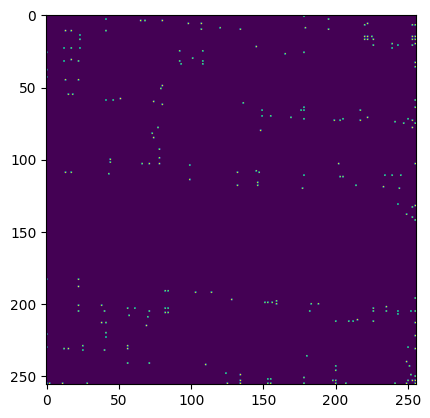

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5594, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 204 - Loss: 13.60097882360716


  0%|          | 0/1 [00:00<?, ?it/s]

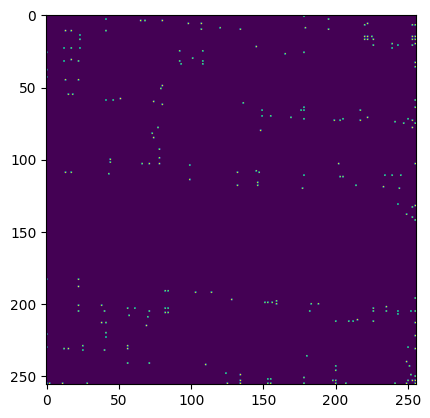

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5593, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 205 - Loss: 13.600810976927473


  0%|          | 0/1 [00:00<?, ?it/s]

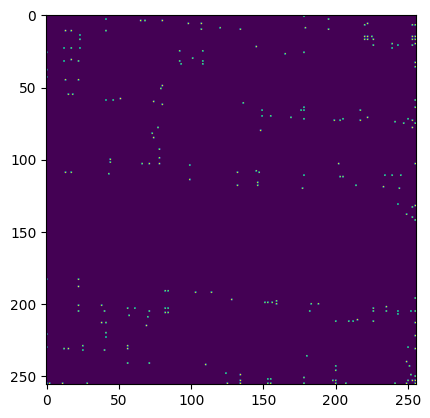

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5591, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 206 - Loss: 13.600650759642317


  0%|          | 0/1 [00:00<?, ?it/s]

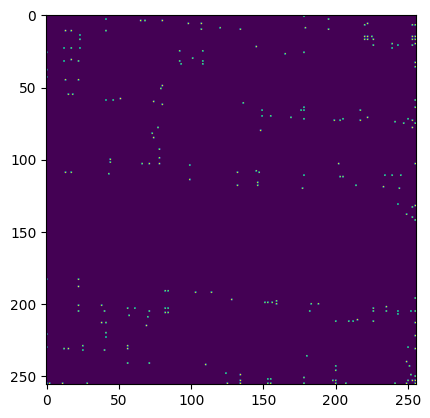

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5589, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 207 - Loss: 13.600492449705794


  0%|          | 0/1 [00:00<?, ?it/s]

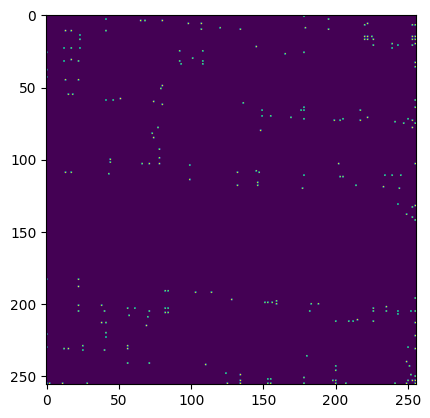

100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5588, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 208 - Loss: 13.600333186094954


  0%|          | 0/1 [00:00<?, ?it/s]

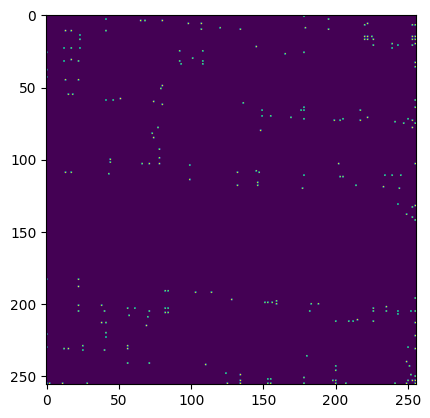

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5586, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 209 - Loss: 13.600181551878645


  0%|          | 0/1 [00:00<?, ?it/s]

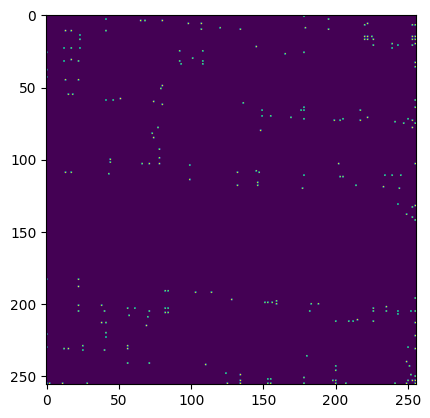

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5585, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 210 - Loss: 13.60003182501097


  0%|          | 0/1 [00:00<?, ?it/s]

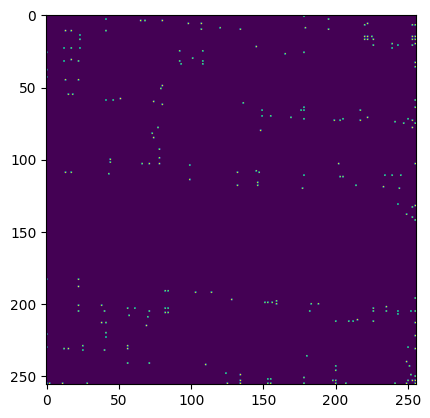

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5583, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 211 - Loss: 13.597902270262434


  0%|          | 0/1 [00:00<?, ?it/s]

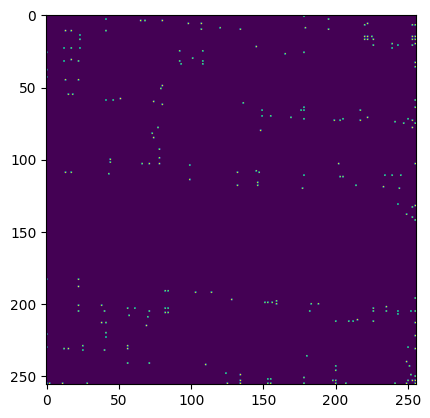

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5582, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 212 - Loss: 13.597755404417708


  0%|          | 0/1 [00:00<?, ?it/s]

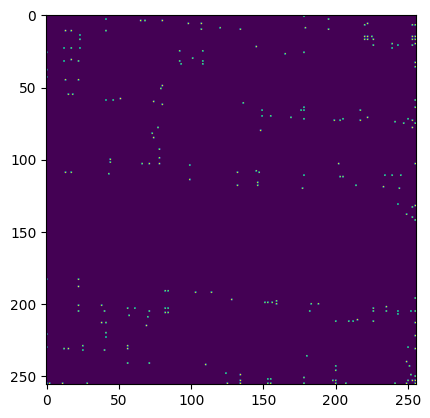

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5580, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 213 - Loss: 13.597612353270247


  0%|          | 0/1 [00:00<?, ?it/s]

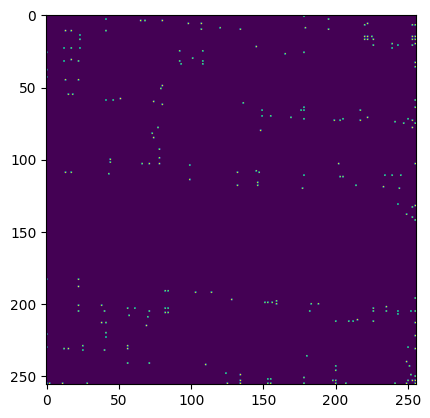

100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5579, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 214 - Loss: 13.597453086639012


  0%|          | 0/1 [00:00<?, ?it/s]

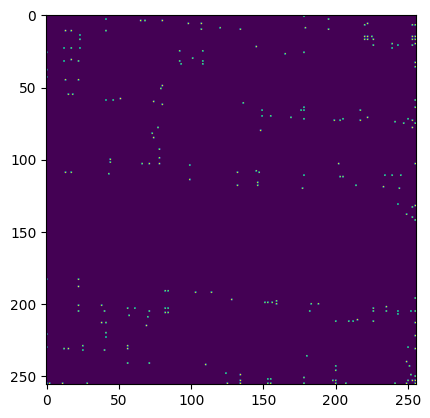

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5578, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 215 - Loss: 13.597321479583348


  0%|          | 0/1 [00:00<?, ?it/s]

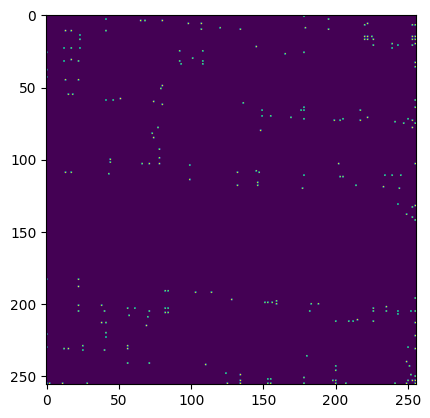

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5576, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 216 - Loss: 13.597186057830418


  0%|          | 0/1 [00:00<?, ?it/s]

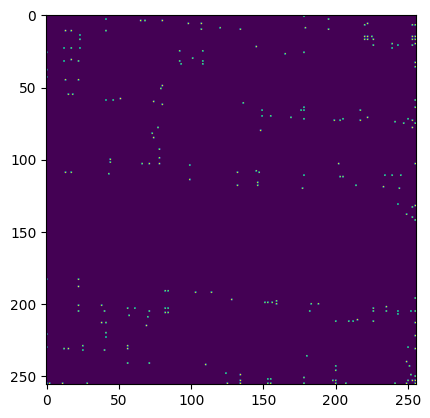

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Segmentation Loss:  tensor(0.7042, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5575, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 217 - Loss: 13.599039047027196


  0%|          | 0/1 [00:00<?, ?it/s]

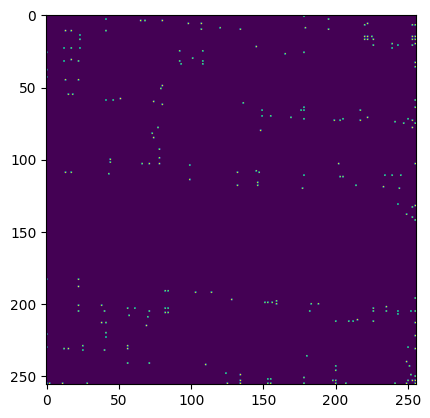

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5574, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 218 - Loss: 13.596948595946028


  0%|          | 0/1 [00:00<?, ?it/s]

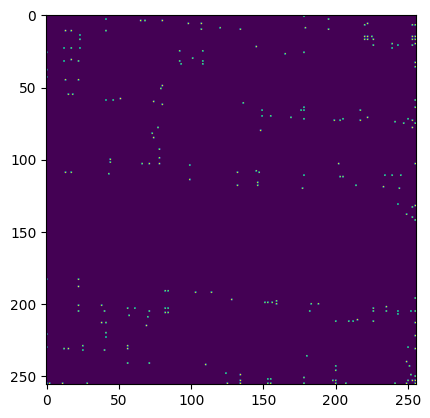

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5573, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 219 - Loss: 13.597222300474836


  0%|          | 0/1 [00:00<?, ?it/s]

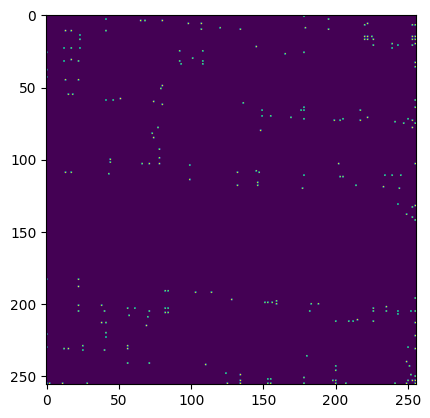

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5571, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 220 - Loss: 13.597100230162336


  0%|          | 0/1 [00:00<?, ?it/s]

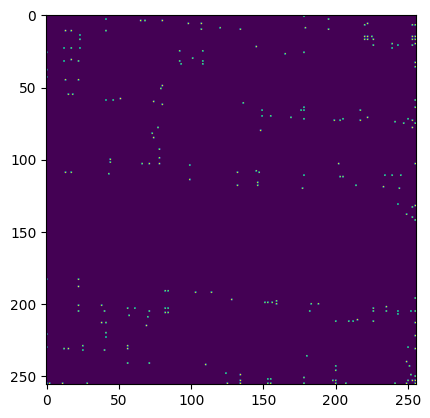

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5570, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 221 - Loss: 13.59697720617552


  0%|          | 0/1 [00:00<?, ?it/s]

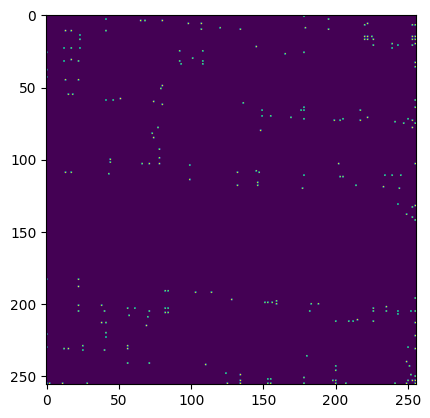

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5569, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 222 - Loss: 13.596857043211653


  0%|          | 0/1 [00:00<?, ?it/s]

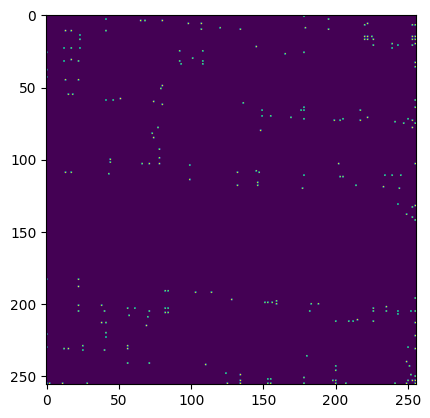

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5568, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 223 - Loss: 13.596347781126692


  0%|          | 0/1 [00:00<?, ?it/s]

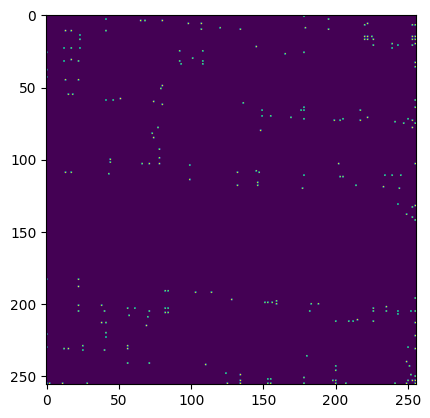

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5567, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 224 - Loss: 13.596226664488508


  0%|          | 0/1 [00:00<?, ?it/s]

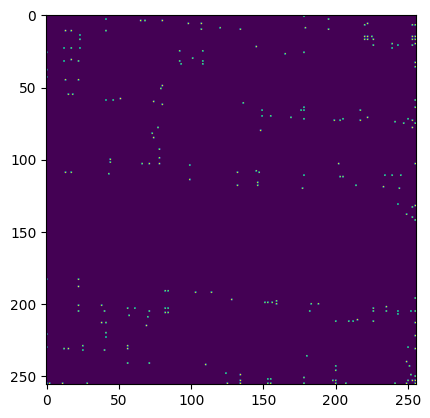

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5565, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 225 - Loss: 13.596096008086766


  0%|          | 0/1 [00:00<?, ?it/s]

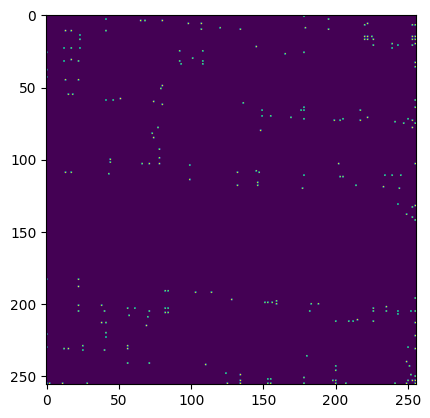

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5564, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 226 - Loss: 13.59598633554038


  0%|          | 0/1 [00:00<?, ?it/s]

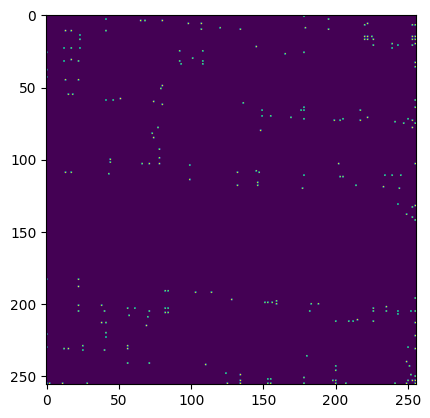

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5563, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 227 - Loss: 13.595876662993993


  0%|          | 0/1 [00:00<?, ?it/s]

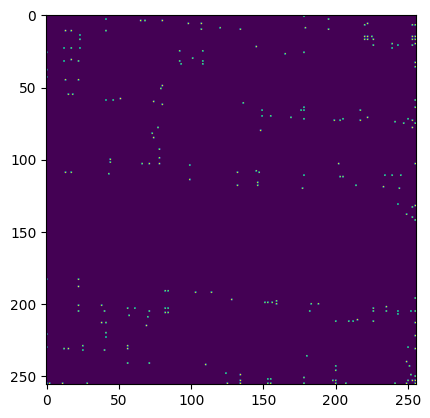

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5562, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 228 - Loss: 13.595769851470555


  0%|          | 0/1 [00:00<?, ?it/s]

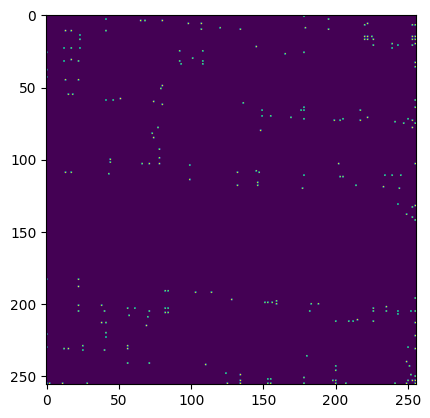

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5561, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 229 - Loss: 13.595684023802473


  0%|          | 0/1 [00:00<?, ?it/s]

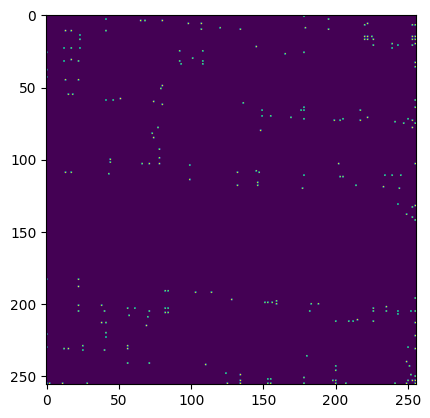

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5560, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 230 - Loss: 13.595581026976301


  0%|          | 0/1 [00:00<?, ?it/s]

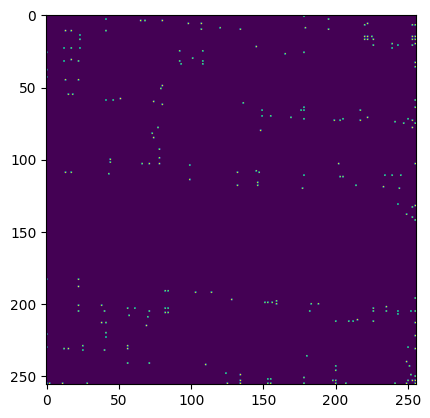

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5559, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 231 - Loss: 13.595478983824446


  0%|          | 0/1 [00:00<?, ?it/s]

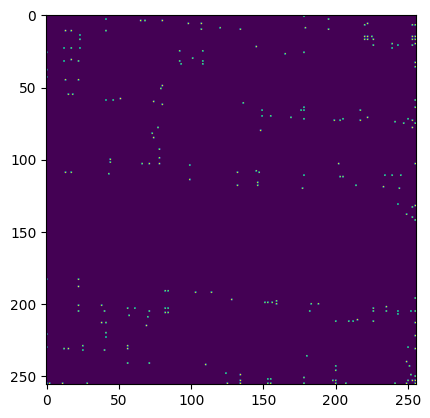

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5558, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 232 - Loss: 13.595375986998274


  0%|          | 0/1 [00:00<?, ?it/s]

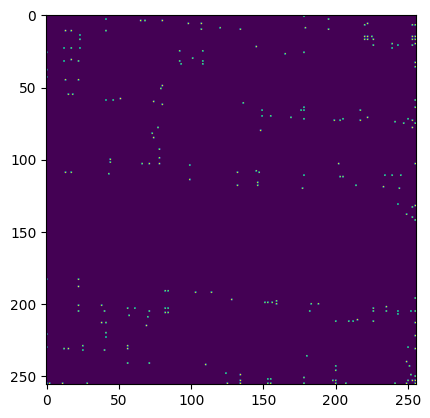

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5557, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 233 - Loss: 13.59528157324095


  0%|          | 0/1 [00:00<?, ?it/s]

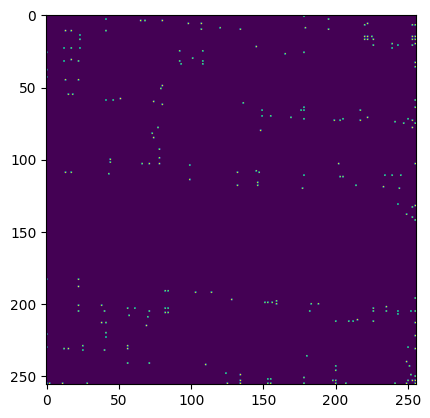

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5556, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 234 - Loss: 13.595581026976301


  0%|          | 0/1 [00:00<?, ?it/s]

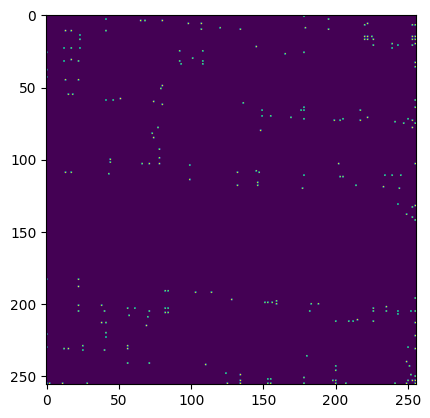

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5555, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 235 - Loss: 13.59508511633177


  0%|          | 0/1 [00:00<?, ?it/s]

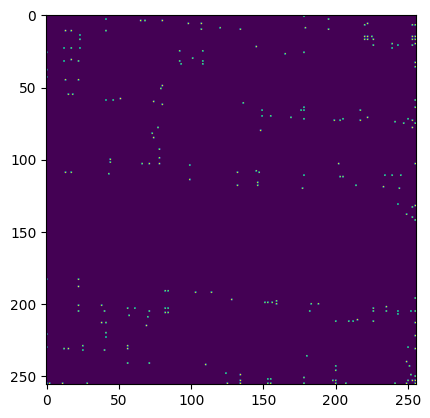

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5554, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 236 - Loss: 13.594976394439305


  0%|          | 0/1 [00:00<?, ?it/s]

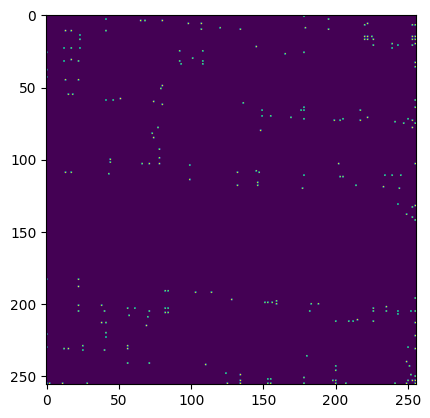

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5553, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 237 - Loss: 13.59527489450034


  0%|          | 0/1 [00:00<?, ?it/s]

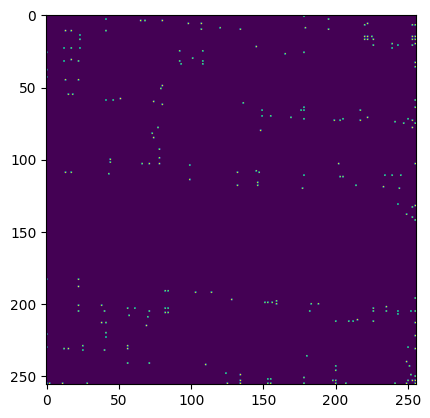

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5552, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 238 - Loss: 13.59521004766722


  0%|          | 0/1 [00:00<?, ?it/s]

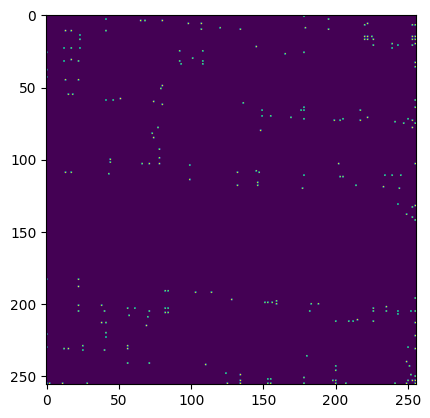

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5552, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 239 - Loss: 13.595118494932844


  0%|          | 0/1 [00:00<?, ?it/s]

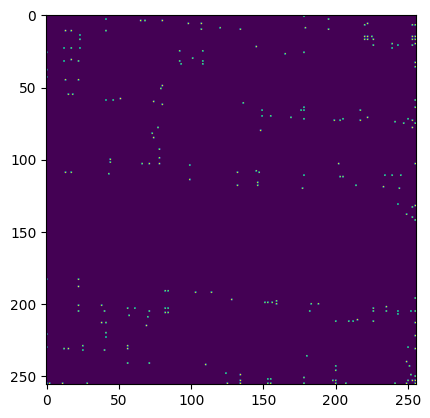

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5551, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 240 - Loss: 13.595031710570051


  0%|          | 0/1 [00:00<?, ?it/s]

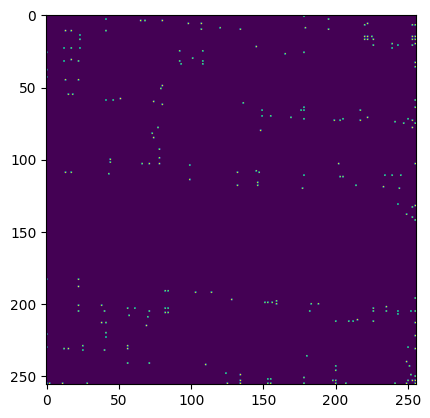

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5550, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 241 - Loss: 13.594943018858626


  0%|          | 0/1 [00:00<?, ?it/s]

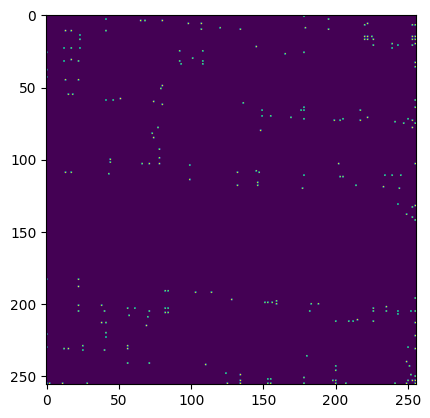

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5549, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 242 - Loss: 13.594859095518782


  0%|          | 0/1 [00:00<?, ?it/s]

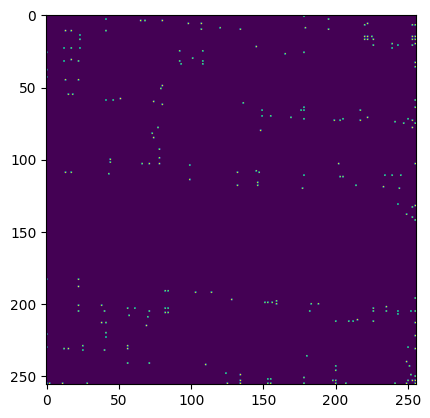

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5548, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 243 - Loss: 13.59477707952757


  0%|          | 0/1 [00:00<?, ?it/s]

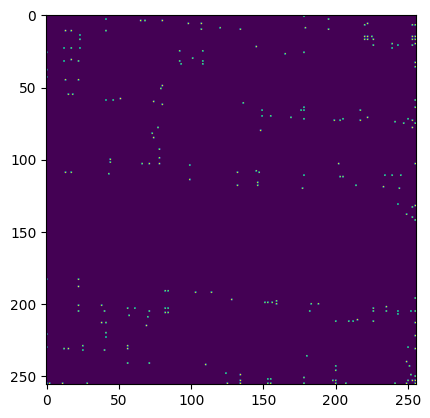

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5547, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 244 - Loss: 13.594275443816747


  0%|          | 0/1 [00:00<?, ?it/s]

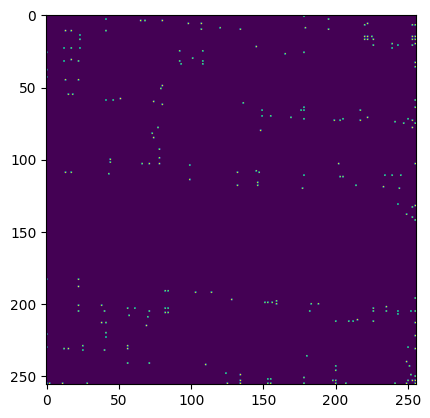

100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5546, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 245 - Loss: 13.594194381499852


  0%|          | 0/1 [00:00<?, ?it/s]

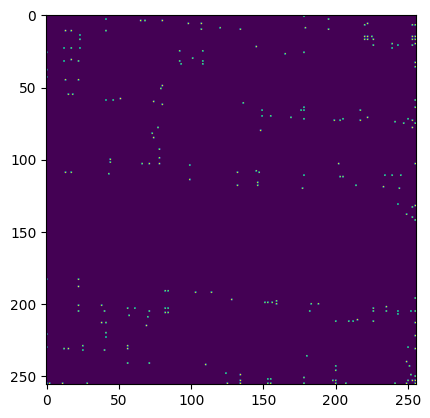

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5546, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 246 - Loss: 13.594116180205907


  0%|          | 0/1 [00:00<?, ?it/s]

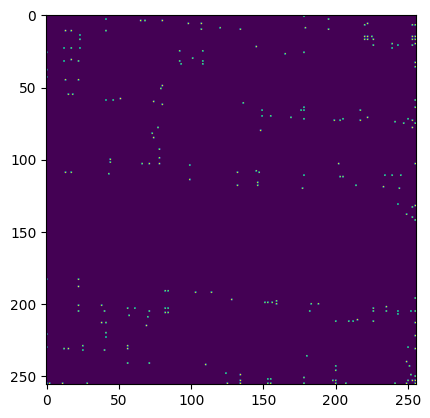

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5545, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 247 - Loss: 13.594235389495458


  0%|          | 0/1 [00:00<?, ?it/s]

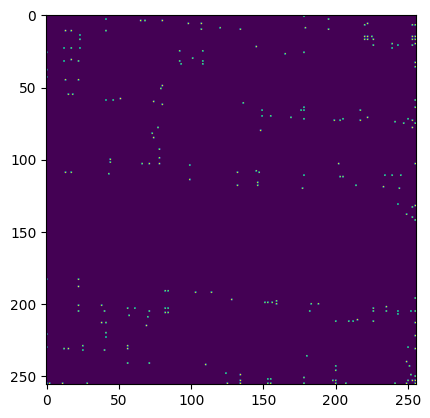

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5544, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 248 - Loss: 13.594160049224461


  0%|          | 0/1 [00:00<?, ?it/s]

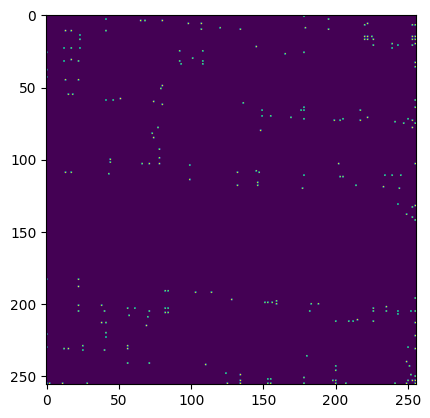

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5543, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 249 - Loss: 13.594102831785872


  0%|          | 0/1 [00:00<?, ?it/s]

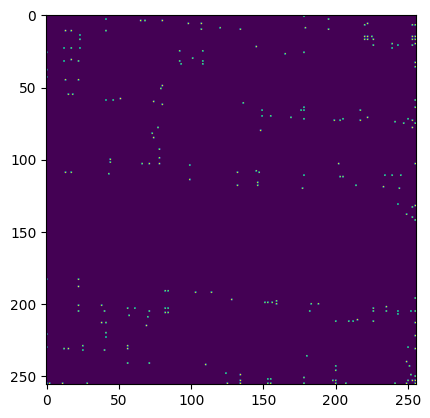

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Segmentation Loss:  tensor(0.7039, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5543, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 250 - Loss: 13.593631716673567


  0%|          | 0/1 [00:00<?, ?it/s]

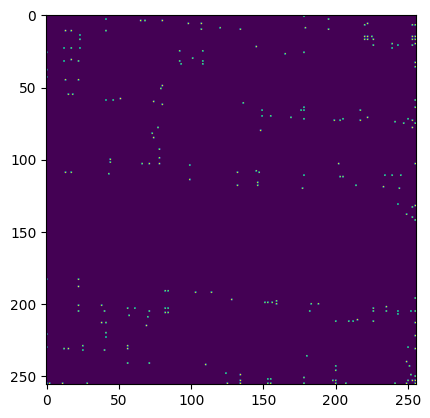

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5542, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 251 - Loss: 13.593953104918196


  0%|          | 0/1 [00:00<?, ?it/s]

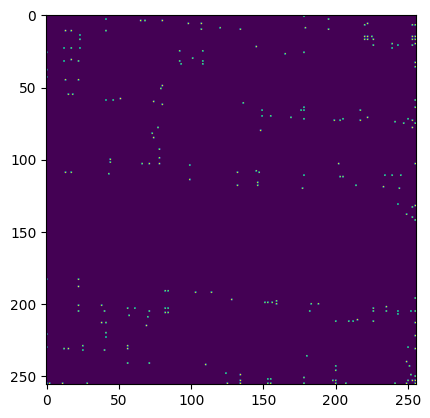

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5541, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 252 - Loss: 13.593881579344465


  0%|          | 0/1 [00:00<?, ?it/s]

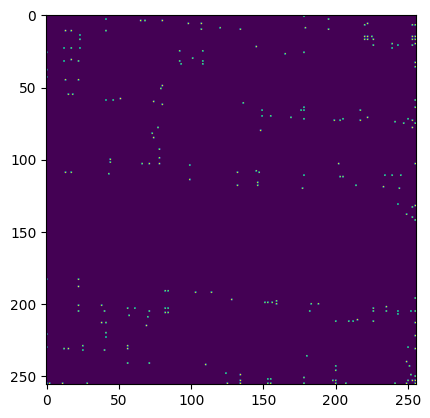

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5540, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 253 - Loss: 13.593984573150243


  0%|          | 0/1 [00:00<?, ?it/s]

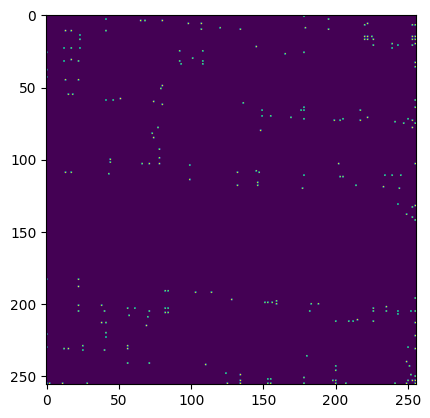

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5540, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 254 - Loss: 13.593915908599461


  0%|          | 0/1 [00:00<?, ?it/s]

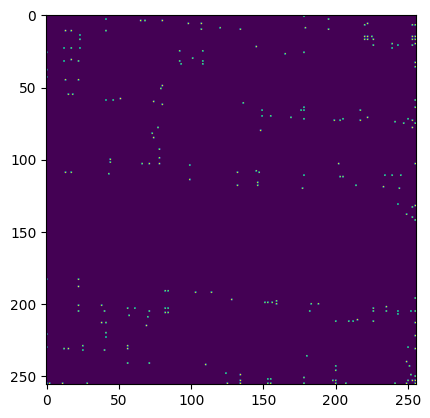

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5539, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 255 - Loss: 13.593841522002782


  0%|          | 0/1 [00:00<?, ?it/s]

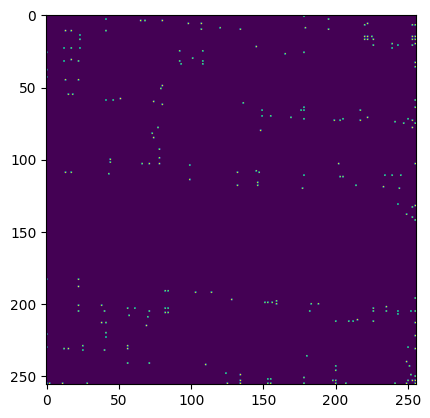

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5538, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 256 - Loss: 13.59357926156577


  0%|          | 0/1 [00:00<?, ?it/s]

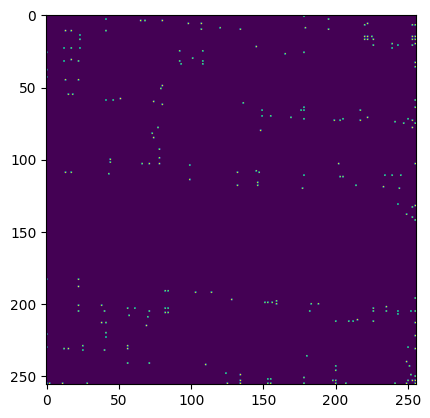

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5538, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 257 - Loss: 13.59350773599204


  0%|          | 0/1 [00:00<?, ?it/s]

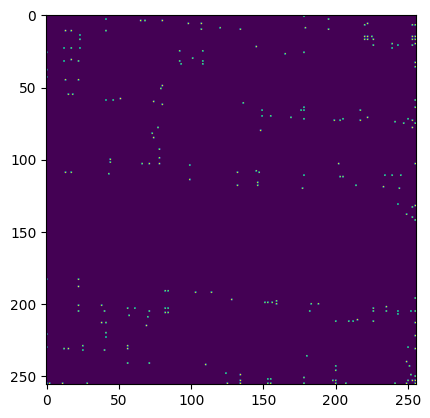

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5537, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 258 - Loss: 13.593442886138524


  0%|          | 0/1 [00:00<?, ?it/s]

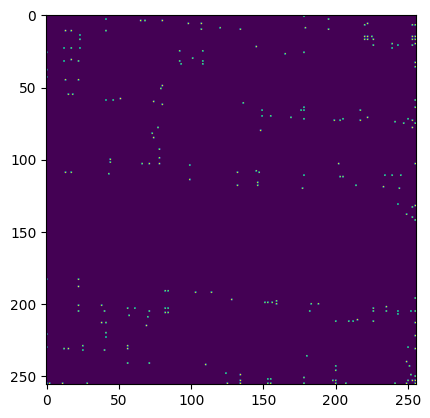

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5536, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 259 - Loss: 13.593378036285008


  0%|          | 0/1 [00:00<?, ?it/s]

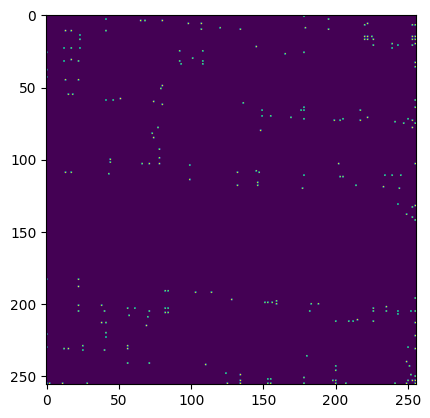

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5536, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 260 - Loss: 13.59331127908286


  0%|          | 0/1 [00:00<?, ?it/s]

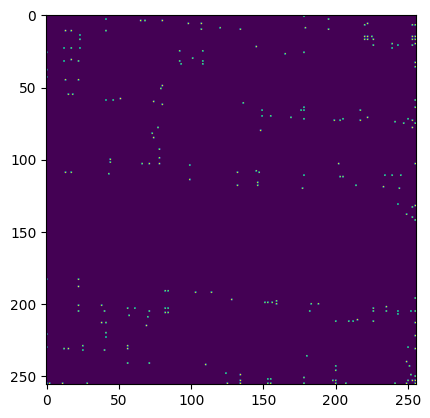

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5535, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 261 - Loss: 13.59324738290366


  0%|          | 0/1 [00:00<?, ?it/s]

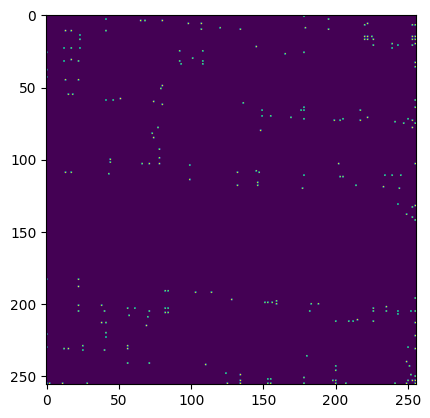

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5534, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 262 - Loss: 13.593181579375829


  0%|          | 0/1 [00:00<?, ?it/s]

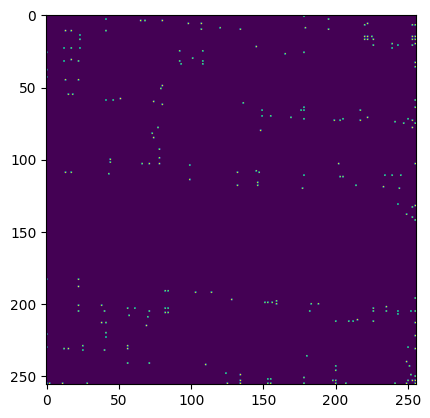

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5534, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 263 - Loss: 13.593120544219579


  0%|          | 0/1 [00:00<?, ?it/s]

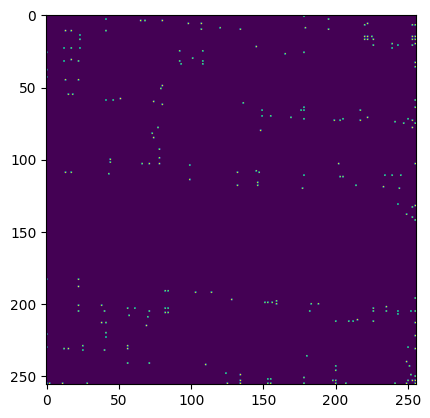

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5533, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 264 - Loss: 13.59305664804038


  0%|          | 0/1 [00:00<?, ?it/s]

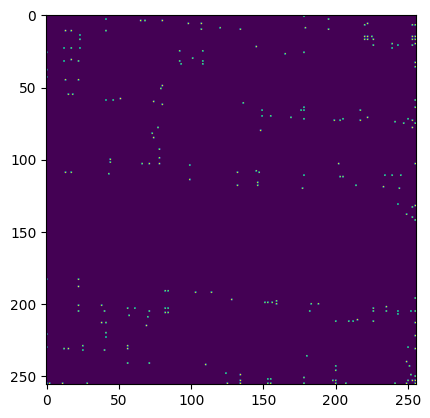

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5533, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 265 - Loss: 13.592998473907079


  0%|          | 0/1 [00:00<?, ?it/s]

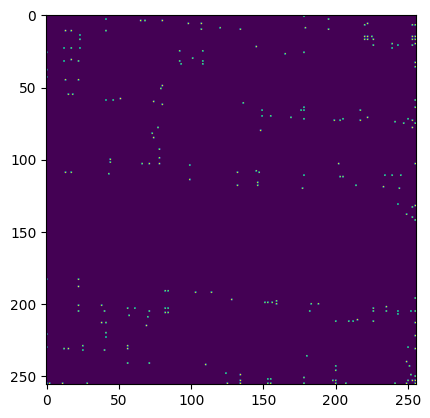

100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5532, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 266 - Loss: 13.592936485076512


  0%|          | 0/1 [00:00<?, ?it/s]

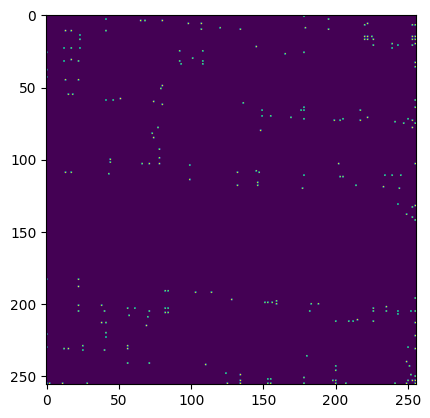

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5531, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 267 - Loss: 13.593073814178075


  0%|          | 0/1 [00:00<?, ?it/s]

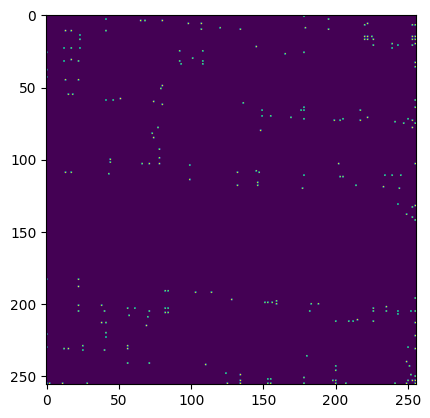

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5531, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 268 - Loss: 13.592817275786961


  0%|          | 0/1 [00:00<?, ?it/s]

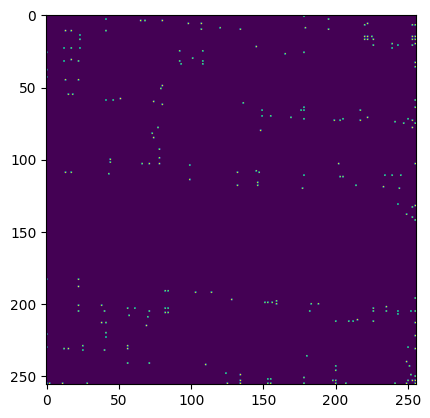

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5530, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 269 - Loss: 13.59276196267661


  0%|          | 0/1 [00:00<?, ?it/s]

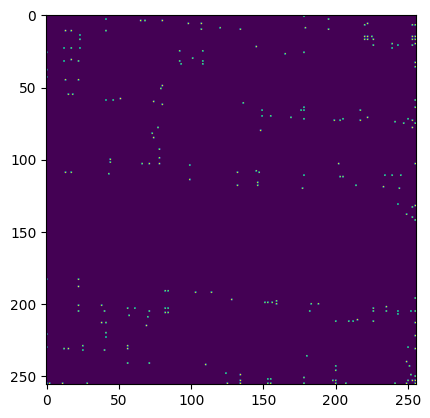

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5530, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 270 - Loss: 13.592702834868993


  0%|          | 0/1 [00:00<?, ?it/s]

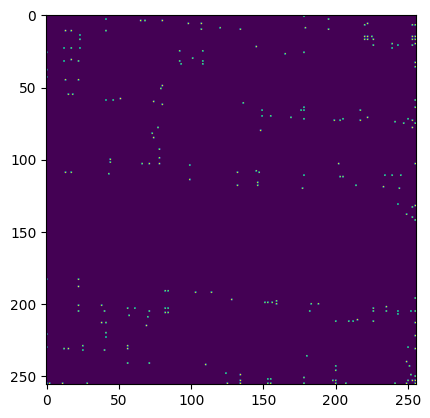

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5529, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 271 - Loss: 13.592645614410008


  0%|          | 0/1 [00:00<?, ?it/s]

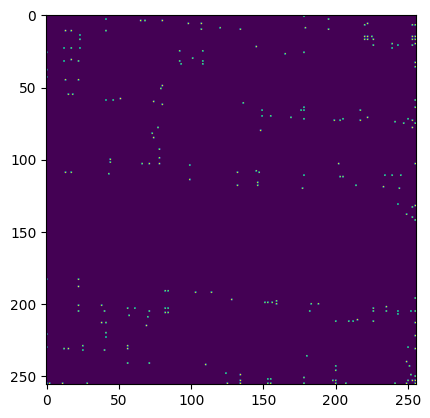

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5528, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 272 - Loss: 13.592588393951024


  0%|          | 0/1 [00:00<?, ?it/s]

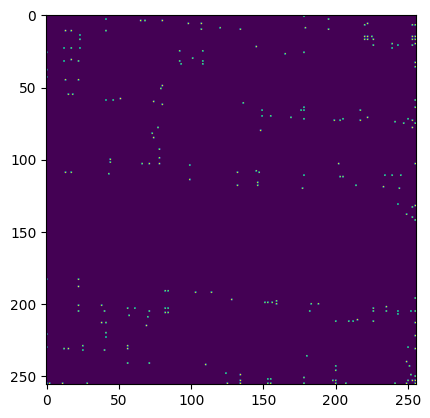

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5528, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 273 - Loss: 13.592533080840672


  0%|          | 0/1 [00:00<?, ?it/s]

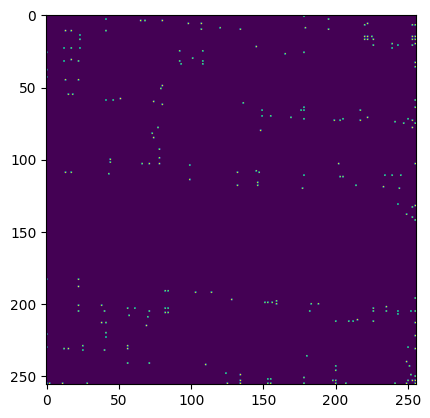

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5527, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 274 - Loss: 13.59247776773032


  0%|          | 0/1 [00:00<?, ?it/s]

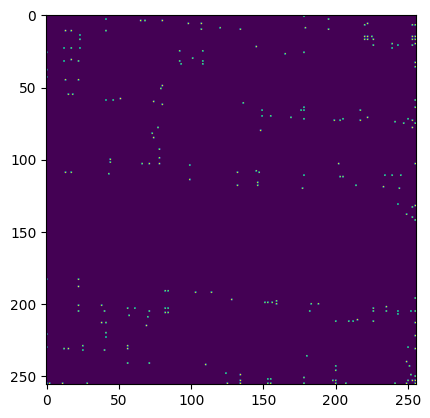

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5527, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 275 - Loss: 13.592424361968602


  0%|          | 0/1 [00:00<?, ?it/s]

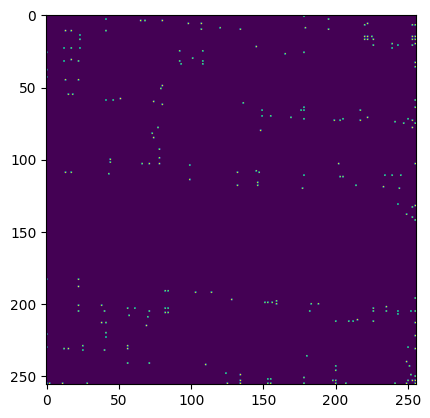

100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5526, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 276 - Loss: 13.592370956206883


  0%|          | 0/1 [00:00<?, ?it/s]

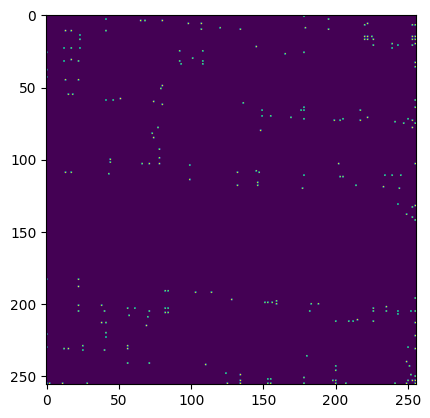

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5526, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 277 - Loss: 13.592318504119481


  0%|          | 0/1 [00:00<?, ?it/s]

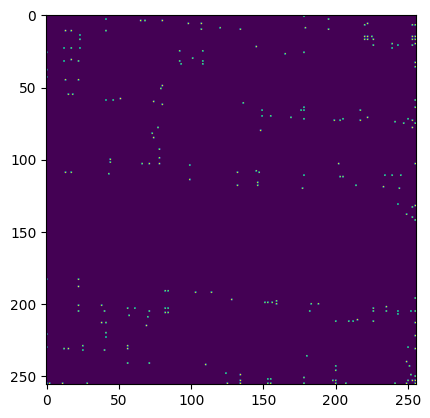

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5525, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 278 - Loss: 13.592266052032079


  0%|          | 0/1 [00:00<?, ?it/s]

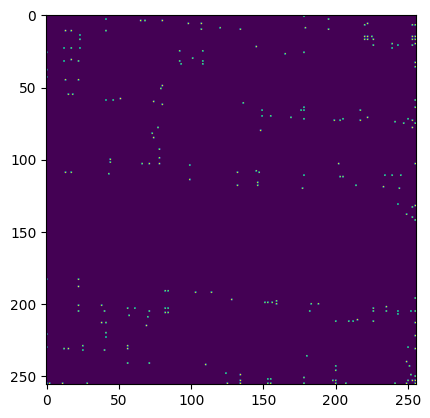

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5525, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 279 - Loss: 13.592215507293309


  0%|          | 0/1 [00:00<?, ?it/s]

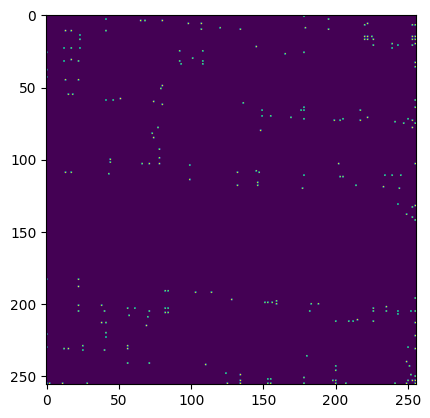

100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5524, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 280 - Loss: 13.59216496255454


  0%|          | 0/1 [00:00<?, ?it/s]

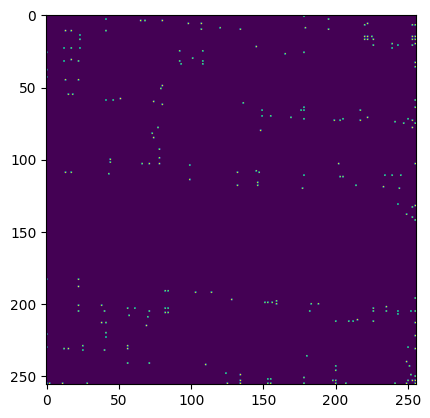

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5524, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 281 - Loss: 13.59211441781577


  0%|          | 0/1 [00:00<?, ?it/s]

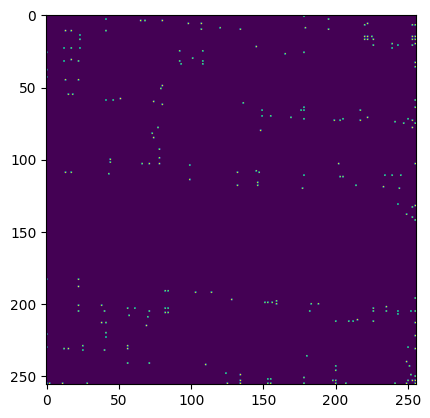

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5523, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 282 - Loss: 13.592064826751317


  0%|          | 0/1 [00:00<?, ?it/s]

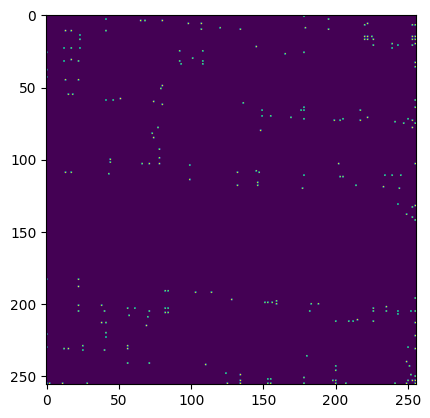

100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5523, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 283 - Loss: 13.592014282012547


  0%|          | 0/1 [00:00<?, ?it/s]

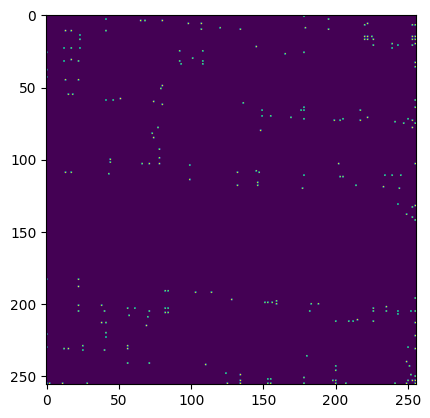

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5522, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 284 - Loss: 13.59196850564536


  0%|          | 0/1 [00:00<?, ?it/s]

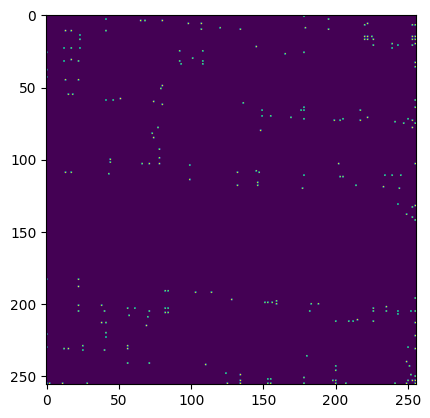

100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5522, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 285 - Loss: 13.59191796090659


  0%|          | 0/1 [00:00<?, ?it/s]

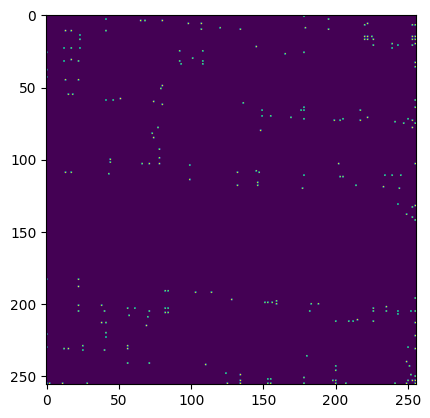

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5521, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 286 - Loss: 13.59187313821372


  0%|          | 0/1 [00:00<?, ?it/s]

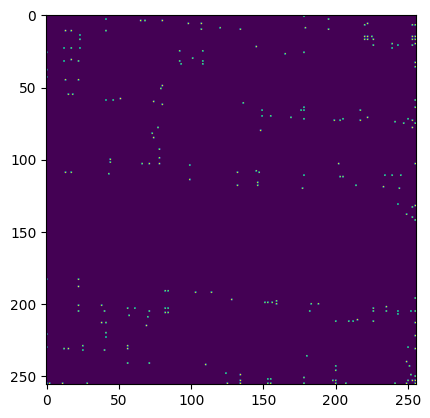

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5521, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 287 - Loss: 13.591825454497899


  0%|          | 0/1 [00:00<?, ?it/s]

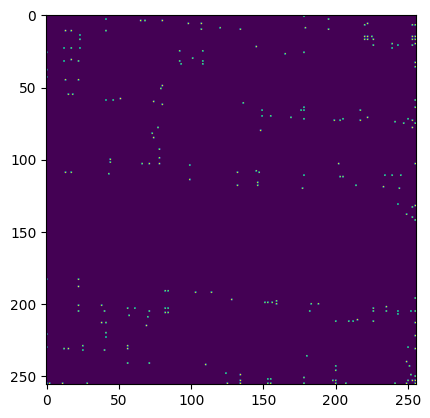

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5520, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 288 - Loss: 13.591779678130711


  0%|          | 0/1 [00:00<?, ?it/s]

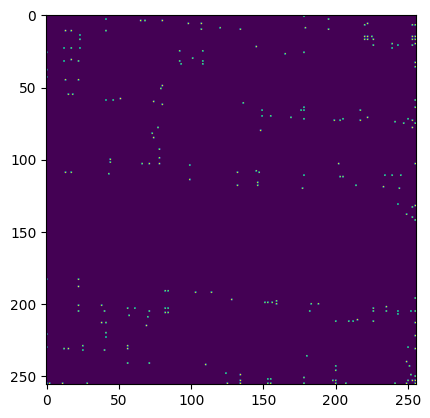

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5520, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 289 - Loss: 13.591733901763524


  0%|          | 0/1 [00:00<?, ?it/s]

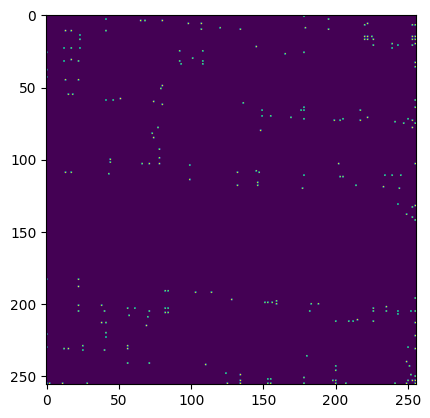

100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5519, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 290 - Loss: 13.59169003274497


  0%|          | 0/1 [00:00<?, ?it/s]

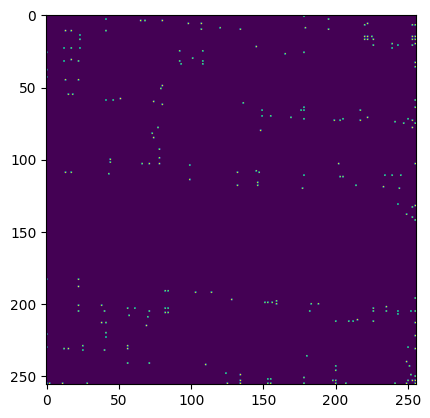

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5519, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 291 - Loss: 13.591644256377782


  0%|          | 0/1 [00:00<?, ?it/s]

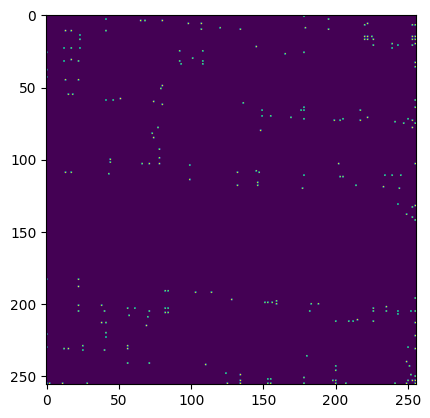

100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


Segmentation Loss:  tensor(0.7040, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5519, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 292 - Loss: 13.591601341033543


  0%|          | 0/1 [00:00<?, ?it/s]

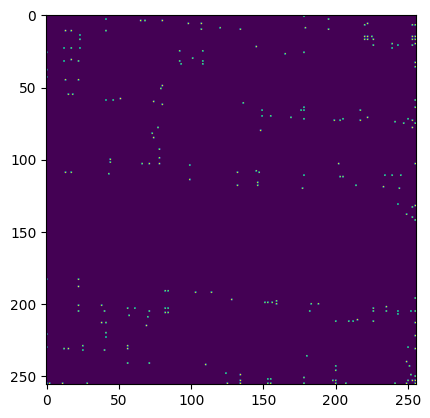

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Segmentation Loss:  tensor(0.7037, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5518, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 293 - Loss: 13.58845707560277


  0%|          | 0/1 [00:00<?, ?it/s]

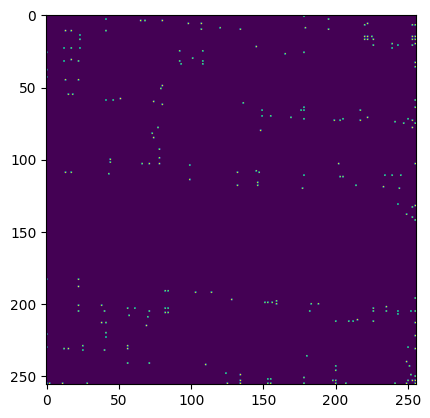

100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


Segmentation Loss:  tensor(0.7037, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5518, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 294 - Loss: 13.588415113932848


  0%|          | 0/1 [00:00<?, ?it/s]

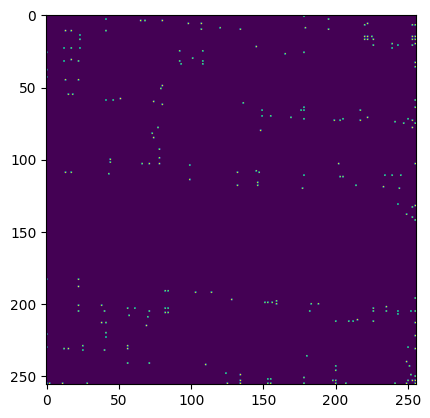

100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


Segmentation Loss:  tensor(0.7037, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5517, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 295 - Loss: 13.588370291239977


  0%|          | 0/1 [00:00<?, ?it/s]

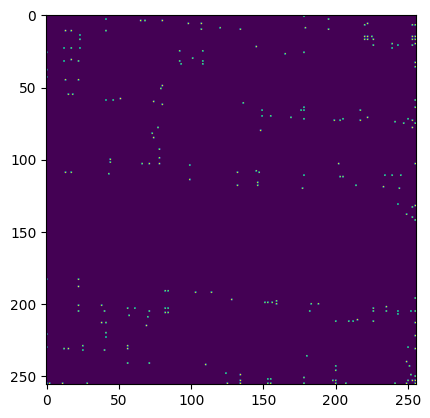

100%|██████████| 1/1 [00:00<00:00,  1.09it/s]


Segmentation Loss:  tensor(0.7037, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5517, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 296 - Loss: 13.588327375895739


  0%|          | 0/1 [00:00<?, ?it/s]

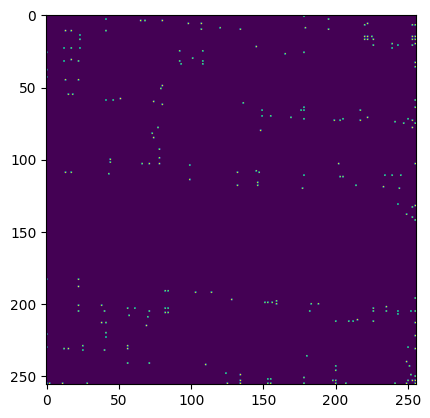

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Segmentation Loss:  tensor(0.7037, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5516, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 297 - Loss: 13.58828732157445


  0%|          | 0/1 [00:00<?, ?it/s]

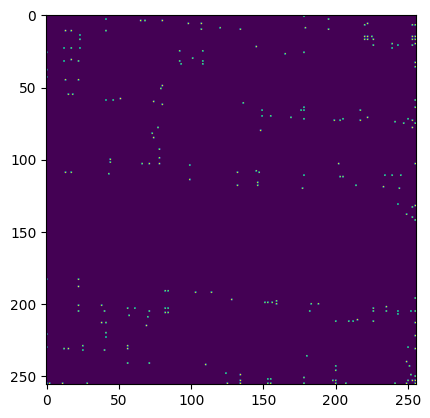

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Segmentation Loss:  tensor(0.7037, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5516, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 298 - Loss: 13.588246313578844


  0%|          | 0/1 [00:00<?, ?it/s]

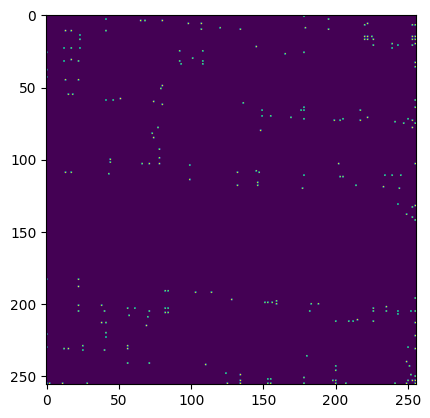

100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

Segmentation Loss:  tensor(0.7037, device='cuda:0', grad_fn=<MeanBackward0>)
Matching Loss:  tensor(5.5516, device='cuda:0', grad_fn=<NegBackward0>)
Angle Loss:  tensor(1.0000, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Epoch 299 - Loss: 13.588203398234606


In [10]:
EPOCHS = 300
LAMBDA = 1000

for epoch in range(EPOCHS):
    for image, gt_vertex_mask, gt_seg_mask, gt_permutation_matrix, gt_polygons, gt_graph, gt_vertices, gt_dic in tqdm(dataloader):

        # DATA PREPARATION
        image, gt_vertex_mask, gt_seg_mask, gt_permutation_matrix = torch.stack(image), torch.stack(gt_vertex_mask), torch.stack(gt_seg_mask), torch.stack(gt_permutation_matrix)
        # Move Inputs to Device
        image = image.float().permute(0, 3, 1, 2).to(device)
        gt_seg_mask = gt_seg_mask.permute(0, 2, 1).to(device)
        gt_permutation_matrix = gt_permutation_matrix.to(device)
        # gt_polygons = gt_polygons.to(device)
        # gt_vertex_mask = gt_vertex_mask.to(device)

        
        optimizer.zero_grad()
        # FORWARD
        # Backbone
        features = model(image)
        # 1x1 Conv
        vertex_logits = head_ver(features) # occupancy grid
        # NMS
        _ , graph = suppression(vertex_logits) # (B, 256, 2) --> Vertex Positions
        # Sorting
        graph = sort_sync_nsm_points(graph, gt_vertices, gt_dic).to(device) # Necessary or not? YES


        plt.imshow(graph_to_vertex_mask(graph, image)[0].detach().cpu().numpy())
        plt.show()

        # Matching
        # polys, permutation_matrix, scores, sinkhorn_scores, graph
        polys, permutation_matrix, _, sinkhorn_scores, graph = matching.predict(image, features, graph) # Graph --> Vertex Points | features --> descriptors
        del image, features

        # Create Seg Mask
        # pred_mask = polygon_to_seg_mask(polys, WINDOW_SIZE)
        try:
            pred_mask = soft_winding_number(polys, lam=LAMBDA, img_size=WINDOW_SIZE, device=device)
        except Exception as e:
            print(e)
            print('skipping the th iteration')
            continue
        # soft_winding() --> Diffrentiable Segmentation Mask --> IoU Loss
        # pred_mask = soft_winding_number(polys, lam=LAMBDA, img_size=WINDOW_SIZE)


        # LOSS
        # detection_loss = detection_loss_function(vertex_logits.squeeze(1), gt_vertex_mask.float())
        # del vertex_logits, gt_vertex_mask
        segmentation_loss = iou_loss_function(pred_mask, gt_seg_mask)
        # del gt_seg_mask
        # matching_loss = matching_loss_function(sinkhorn_scores, gt_permutation_matrix.float())
        matching_loss = cross_entropy_loss(sinkhorn_scores, gt_permutation_matrix)
        pred_angle, gt_angle = compute_l_angle_loss(gt_permutation_matrix.double(), gt_vertices, permutation_matrix, graph, device=device)
        # del gt_permutation_matrix
        angle_loss = torch.mean(1 - torch.exp(-10 * torch.abs((pred_angle - gt_angle))))
        loss = matching_loss + segmentation_loss * 10 + angle_loss



        # BACKWARD
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    



    # print('Detection Loss: ', detection_loss)
    print('Segmentation Loss: ', segmentation_loss)
    print('Matching Loss: ', matching_loss)
    print('Angle Loss: ', angle_loss)
    print(f"Epoch {epoch} - Loss: {loss.item()}")




    # plt.imshow(vertex_logits[0].detach().cpu().numpy().squeeze())
    # plt.show()
    # plt.imshow(permutation_matrix[0].detach().cpu().numpy())
    # plt.show()
    # plt.imshow(gt_permutation_matrix[0].detach().cpu().numpy())
    # plt.show()
    # plt.imshow(gt_seg_mask[0].detach().cpu().numpy())
    # plt.show()
    # plt.imshow(pred_mask[0].detach().cpu().numpy())
    # plt.show()
    # plt.imshow(scores[0].detach().cpu().numpy())    
    # plt.show()
    # plt.imshow(vertex_logits[0].detach.cpu().numpy())
    # plt.show()

In [ ]:
plt.imshow(gt_vertex_mask[0].detach().cpu().numpy())

### Save

In [ ]:
# save the complete model and optimizer state
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'trained_weights/polyworld_backbone_overfit_1sample.pth')

### Inference

In [ ]:
# Inputs
image, gt_vertex_mask, gt_seg_mask, gt_permutation_matrix, gt_polygons, gt_graph, gt_vertices, gt_dic = next(iter(dataloader))
image, gt_vertex_mask, gt_seg_mask, gt_permutation_matrix = torch.stack(image), torch.stack(gt_vertex_mask), torch.stack(gt_seg_mask), torch.stack(gt_permutation_matrix)
image = image.float().cuda().permute(0, 3, 1, 2)

In [ ]:
print('Image: ', image.shape)
print('Vertex: ', gt_vertex_mask.shape)
print('Segmentation: ', gt_seg_mask.shape)
print('Permutation: ', gt_permutation_matrix.shape)

In [ ]:
# Outputs
features = model(image)
vertex_logits = head_ver(features)
_ , graph = suppression(vertex_logits)
poly, permutation_matrix, scores, sinkhorn_scores, graph = matching.predict(image, features, graph) 

In [ ]:
gt_graph[0]

In [ ]:
sort_sync_nsm_points(torch.stack(gt_graph), gt_vertices, gt_dic)

In [ ]:
p = permutations_to_polygons(gt_permutation_matrix, gt_graph)
m = np.zeros((WINDOW_SIZE, WINDOW_SIZE), dtype=np.uint8)

cv2.fillPoly(m, [p[0][1].detach().cpu().numpy().astype(int)], 1)
plt.imshow(m)

In [ ]:
# find the index of the first (0,0) element in the gt_graph
idx = 0
for i in range(len(gt_graph[0])):
    if gt_graph[0][i][0] == 0 and gt_graph[0][i][1] == 0:
        idx = i
        break

In [ ]:
gt_dic[0]

In [ ]:
gt_graph[0][idx]

In [ ]:
idx

In [ ]:
sorted(gt_graph)

In [ ]:
gt_graph[0].sort(dim=0, descending=True)

In [ ]:
graph[0]

In [ ]:
poly

In [ ]:
gt_polygons

In [ ]:
def polygon_to_seg_mask(polygons, image_size):
    mask = np.zeros((image_size, image_size), dtype=np.uint8)
    for polygon in polygons[0]:
        cv2.fillPoly(mask, [polygon.detach().cpu().numpy()], 1)
        break
    return torch.tensor(mask, dtype=torch.uint8)

In [ ]:
# Polygon to Mask
pred_mask = polygon_to_seg_mask(poly, 256)

In [ ]:
plt.imshow(pred_mask)

In [ ]:
plt.imshow(F.sigmoid(vertex_logits[0].squeeze()).detach().cpu().numpy())

In [ ]:
# Polygon to Mask
m = soft_winding_number(poly, lam=1000, img_size=WINDOW_SIZE)

In [ ]:
plt.imshow(gt_seg_mask[0].detach().cpu().numpy().squeeze() + m[0].detach().cpu().numpy())

In [ ]:
plt.imshow((gt_seg_mask[0].detach().cpu().numpy().squeeze() + F.sigmoid(m)[0].detach().cpu().numpy()))

In [ ]:
plt.imshow(m[0].detach().cpu().numpy())

In [ ]:
plt.imshow(F.sigmoid(m[0]).detach().cpu().numpy())

In [ ]:
plt.imshow(F.softmax(m, dim=0)[0].detach().cpu().numpy())

In [ ]:
m.min(), m.max()

In [ ]:
torch.sigmoid(m).min(), torch.sigmoid(m).max()

In [ ]:
m[0, 50, 300]

In [ ]:
torch.sigmoid(m).unique(return_counts=True)

In [ ]:
plt.imshow(torch.sigmoid(m[0]).detach().cpu().numpy())

In [ ]:
torch.topk(vertex_logits[0,0].flatten(), 256)

In [ ]:
print('RGB: ', image.shape)
print('Features Map: ', features.shape)
print('Vertex Logits: ', vertex_logits.shape)
print('Graph: ', graph.shape)
print('Permutation Matrix: ', permutation_matrix.shape)
print('Sinkhorn Scores: ', sinkhorn_scores.shape)
print('Scores: ', scores.shape)
print('Graph Refined: ', graph_refined.shape)

In [ ]:
graph[0].sort(dim=0, descending=True)

In [ ]:
gt_graph[0].sort(dim=0, descending=True)

In [ ]:
graph.shape

#### Check this flow for GT
permutations -> polygons -> seg mask

In [ ]:
m = np.zeros((320, 320), dtype=np.uint8)
cv2.fillPoly(m, [poly[0][3].detach().cpu().numpy()], 1)

In [ ]:
plt.imshow(m)

In [ ]:
fig ,axes = plt.subplots(1, 2, figsize=(13, 13))

axes[0].imshow(polygon_to_seg_mask(poly[0], 320).permute(1,0))
axes[0].set_title('Predicted Segmentation Mask')

axes[1].imshow(polygon_to_seg_mask(gt_polygons[0], 320))
axes[1].set_title('Ground Truth Segmentation Mask')

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image[0].permute(1,2,0).cpu().numpy())
plt.imshow(vertex_logits[0].cpu().detach().numpy().squeeze(), alpha=.3)

#### The values of Sinkhorn Scores
Correct indiced (vertices) have lower values in sinkhorn

In [ ]:
sinkhorn_scores[0, 250, 250]

In [ ]:
sinkhorn_scores.min(), sinkhorn_scores.max()

In [ ]:
sinkhorn_scores[0, 250, 250] # True Positive

In [ ]:
sinkhorn_scores[0, 200, 230] # False

In [ ]:
# softmax
F.softmax(sinkhorn_scores, dim=2)

In [ ]:
torch.sigmoid(sinkhorn_scores[0, 250, 250]) # Bright

In [ ]:
torch.sigmoid(sinkhorn_scores[0, 200, 230]) # Dark

So the brighter the value, closer it is to the gt

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(21, 21))

axes[0].imshow(F.softmax(sinkhorn_scores[0], dim=1).cpu().detach().numpy())
axes[0].set_title('Applied Softmax on Sinkhorn Scores')


axes[1].imshow(sinkhorn_scores[0].cpu().detach().numpy())
axes[1].set_title('Sinkhorn Scores')


axes[2].imshow(torch.sigmoid(sinkhorn_scores[0]).cpu().detach().numpy())
axes[2].set_title('Applied Sigmoid on Sinkhorn Scores')


plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(21, 21))

axes[0].imshow(F.softmax(sinkhorn_scores[0], dim=0).cpu().detach().numpy()[100:150, :50])
axes[0].set_title('Applied Softmax on Sinkhorn Scores')

axes[1].imshow(sinkhorn_scores[0].cpu().detach().numpy()[100:150, :50])
axes[1].set_title('Ground Truth Permutation Matrix')

axes[2].imshow(torch.sigmoid(sinkhorn_scores[0]).cpu().detach().numpy()[100:150, :50])
axes[2].set_title('Applied Sigmoid on Sinkhorn Scores')

plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

axes[0][0].imshow(torch.sigmoid(scores[0]).cpu().detach().numpy(), cmap='gray')
axes[0][0].set_title("Applied Sigmoid to Scores")

axes[0][1].imshow(torch.sigmoid(sinkhorn_scores[0]).cpu().detach().numpy(), cmap='gray')
axes[0][1].set_title("Applied Sigmoid to Sinkhorn Scores")

axes[1][0].imshow(scores[0].cpu().detach().numpy(), cmap='gray')
axes[1][0].set_title("Scores")

axes[1][1].imshow(-sinkhorn_scores[0].cpu().detach().numpy(), cmap='gray')
axes[1][1].set_title("Sinkhorn Scores")

plt.tight_layout()
plt.show()

In [ ]:
i = 0


fig, axes = plt.subplots(1, 3, figsize=(20, 10))

axes[0].imshow(sinkhorn_scores[i].detach().cpu().numpy())
axes[0].set_title("Sinkhorn Scores")

axes[1].imshow(permutation_matrix[i].detach().cpu().numpy())
axes[1].set_title("Permutation Matrix")

axes[2].imshow(scores[i].detach().cpu().numpy())
axes[2].set_title("Scores")

plt.tight_layout()
plt.show()

In [ ]:
mask1 = graph_to_vertex_mask(graph, image)

mask2 = polygon_to_vertex_mask(tensor_to_numpy(poly)).permute(0, 2, 1)

In [ ]:
mask1.shape, mask2.shape

In [ ]:
# plot mask and seg mask
i = 0
fig, axes = plt.subplots(1, 4, figsize=(21, 13))
axes[0].imshow(gt_vertex_mask[i].cpu().numpy().squeeze())
axes[1].imshow(mask1[i])
axes[2].imshow(mask2[i])
axes[3].imshow(gt_seg_mask[i].cpu().numpy().squeeze())


axes[0].set_title('GT Vertex Mask')
axes[1].set_title('Prediction after NMS')
axes[2].set_title('Prediction from Permutations Matrix + Graph')
axes[3].set_title('GT Segmentation Mask')

plt.tight_layout()
plt.show()

In [ ]:
i = 0

fig, axes = plt.subplots(1, 2, figsize=(21, 13))

axes[0].imshow(gt_permutation_matrix[i].cpu().numpy())
axes[1].imshow(permutation_matrix[i].cpu().numpy())

axes[0].set_title('GT Permutation Matrix')
axes[1].set_title('Prediction Permutation Matrix')

In [ ]:
i = 0

fig, axes = plt.subplots(1, 2, figsize=(21, 13))

axes[0].imshow(gt_permutation_matrix[i].cpu().numpy()[:50,:50])
axes[1].imshow(permutation_matrix[i].cpu().numpy()[:50,:50])

axes[0].set_title('GT Permutation Matrix')
axes[1].set_title('Prediction Permutation Matrix')

In [ ]:
torch.set_printoptions(threshold=100_000)

gt_permutation_matrix == permutation_matrix

In [ ]:
(gt_permutation_matrix[i] == permutation_matrix[i])

In [ ]:
i = 0

fig, axes = plt.subplots(1, 3, figsize=(21, 13))
axes[0].imshow(torch.sigmoid(vertex_logits)[i].detach().cpu().numpy().squeeze())
axes[1].imshow(vertex_logits[i].detach().cpu().numpy().squeeze())
axes[2].imshow(image[i].cpu().numpy().squeeze().transpose(1, 2, 0))

axes[0].set_title('Applied Sigmoid on Logits')
axes[1].set_title('Logits')
axes[2].set_title('RGB Image')

plt.tight_layout()
plt.show()